## 1. Importations

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import scapy_layers
import scapy.all as S
from scapy.all import rdpcap, TCP, UDP, IP, Padding, Raw, load_layer, Ether, CookedLinux, PcapReader
from scapy.compat import bytes_encode
from scapy.layers import *
load_layer('http')

#import logging
#logging.getLogger("tensorflow").setLevel(logging.ERROR)

# Linear algebra and data processing
import numpy as np
import pandas as pd
import math
import random
import os

# Get version python/keras/tensorflow/sklearn
from platform import python_version
import sklearn
import tensorflow as tf

# Tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10

# Loading bar
from tqdm import tqdm

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

# Joblib
import joblib

# Others
import itertools
from scipy import linalg
import matplotlib as mpl

# Folder manipulation
import os
import sys

# Garbage collector
import gc

# For images augmentations
# import cv2

# For regex
import re

# Visualizaton
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Personnal functions
import functions
import scapy_layers

import time

# Create defaultdict
from collections import defaultdict

# Import pywt
import pywt

## 2. Informations

In [2]:
print("Keras version : " + keras.__version__)
print("Tensorflow version : " + tf.__version__)
print("Python version : " + python_version())
print("Sklearn version : " + sklearn.__version__)
print("tf.keras.backend.floatx() : ", tf.keras.backend.floatx())

Keras version : 2.6.0
Tensorflow version : 2.6.0
Python version : 3.8.5
Sklearn version : 0.23.2
tf.keras.backend.floatx() :  float32


## 3. Set parameters

In [3]:
RESULTS_DIR = "RESULTS/"
MODELS_DIR = "MODELS/"
DATA_RANGE = [0, 200000]
MAIN_DIR = "./DATA/"

TIMESTEPS = 11
NB_CLUSTERS = 80 # -6
BLOC_LENGTH = 100
TIME_LENGTH = "MONDAY"
FULL_NAME = f"{TIME_LENGTH}_BL{BLOC_LENGTH}_T{TIMESTEPS}"

APP_LIST = ['ARP', 'LLC', 'LOOP', 'SNAP', 'TELNET', 
            'HTTP', 'SSH', 'SNMP', 'SMTP', 'DNS', 
            'NTP', 'FTP', 'RIP', 'IRC', 'POP', 'ICMP', 
            'FINGER', 'TIME', "NETBIOS"]

# Set graph font size
sns.set(font_scale=1.1)

# Set keras types
tf.keras.backend.set_floatx('float64')

## 4. Load data

In [ ]:
%%time
data_gen['datetime'] = data_gen['timestamps'].map(map_time)
data_gen_date = data_gen.set_index('datetime')

data_true['datetime'] = data_true['timestamps'].map(map_time)
data_true_date = data_true.set_index('datetime')

## 4. Analysis

### 4.1 Code

In [4]:
def count_plot(data, col="layers_0",
               log_scale=False, title="No title", 
               figsize=(6, 5)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    values = data[col].value_counts().values
    ci_pred = functions.get_cis(data[col], alpha=0.95, 
                      normalize=True, return_stats=False)
    error_bar = [ci_pred[k][1]-ci_pred[k][0] for k in ci_pred.keys()]
    values_norm= values / values.sum()
    
    print("error_bar : ", error_bar)
    
    # Faire un array !
    g = sns.barplot(y=values_norm, 
                    x=data[col].value_counts().index.values,
                    yerr=error_bar,
                    ax=ax)

    #print(values.max())
    y_upper_lim = values_norm.max() + 0.1
    y_lower_lim = 0

    if(log_scale):
        y_upper_lim = np.log10(y_upper_lim) + np.log10(0.1)
        g.set_yscale("log")

    #g_0.set_yscale("log")
    labels = ax.get_xticklabels()
    ax.set_xticklabels(labels, rotation=70)
    ax.set_ylabel('Proportion')
    ax.set_xlabel(col)
    ax.set_ylim([y_lower_lim, y_upper_lim])
    ax.set_title(title)

In [5]:
def plot_cdf(dfs, col, titles, 
             figsize=(6, 5), hue=None):
    fig, axes = plt.subplots(
        1, len(dfs), figsize=figsize)
    #fig.tight_layout(rect=[0, 0, 1, 0.9])
    fig.subplots_adjust(wspace=0.25, hspace=0)
    #(left, bottom, right, top), default: (0, 0, 1, 1)
    #fig.suptitle(title)
    
    if(len(dfs) > 1):
        axes_ravel = axes.ravel()
    else:
        axes_ravel = [axes]
        
    for df, ax, title in zip(
        dfs, axes_ravel, titles):
        sns.ecdfplot(
            data=df, x=col, ax=ax, hue=hue, palette="tab10")
        #ax.set_xlabel(f"{col}")
        ax.set_title(title)   
    
# https://stackoverflow.com/questions/6677332/using-f-with-strftime-in-python-to-get-microseconds
def map_time(timestamp):
    local_time = time.localtime(timestamp)
    mlsec = repr(timestamp).split('.')[1][:6]
    return pd.Timestamp(pd.to_datetime(
                        time.strftime("%Y%d%m %H:%M:%S.{}".format(mlsec), local_time), 
                        format='%Y%d%m %H:%M:%S.%f'))

In [6]:
def plot_line(dfs, x, y, titles, xlabels, ylabels,
             figsize=(6, 5)):
    fig, axes = plt.subplots(
        int(len(dfs) / 2), 2, figsize=figsize)
    #fig.tight_layout(rect=[0, 0, 1, 0.9])
    fig.subplots_adjust(wspace=0, hspace=0.5)
    #(left, bottom, right, top), default: (0, 0, 1, 1)
    #fig.suptitle(title)
    
    if(len(dfs) > 1):
        axes_ravel = axes.ravel()
    else:
        axes_ravel = [axes]
        
    for df, ax, title, xlabel, ylabel in zip(
        dfs, axes_ravel, titles, xlabels, ylabels):
        val = df[y].values
        ax.plot(df.index.values, val)
        #ax.set_xlabel(f"{col}")
        
        labels = ax.get_xticklabels()
        ax.set_xticklabels(labels, rotation=70)
        
        ax.set_title(title) 
        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)

In [7]:
def plot_line_hue(dfs, x, y, titles, xlabels, ylabels,
             figsize=(6, 5), hue_val=None, hue=None, hue_max=3):
    fig, axes = plt.subplots(
        int(len(dfs) / 2), 2, figsize=figsize)
    #fig.tight_layout(rect=[0, 0, 1, 0.9])
    fig.subplots_adjust(wspace=0.2, hspace=0.5)
    #(left, bottom, right, top), default: (0, 0, 1, 1)
    #fig.suptitle(title)
    
    if(len(dfs) > 1):
        axes_ravel = axes.ravel()
    else:
        axes_ravel = [axes]
        
    vals = []
        
    for df, ax, title, xlabel, ylabel in zip(
        dfs, axes_ravel, titles, xlabels, ylabels):
        
        #hue_val = df.index.get_level_values(
        #    0).value_counts().index.values[:hue_max]
        
        #labels = ax.get_xticklabels()
        #ax.set_xticklabels(labels, rotation=70)
         
        for hue in hue_val:
            val = df.loc[hue][y].values#.astype(str)
            ax.plot(df.loc[hue].index.values, val)
            vals.append(val)
            #ax.set_xlabel(f"{col}")
        
        ax.set_title(title) 
        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)
        ax.legend(hue_val)
    
    max_val = max([val.max() for val in vals])
    for ax in axes.ravel():
        ax.set_ylim([0, max_val])
        #ax.set_ylim([0, 5000])

In [8]:
def plot_box(df, layers="layers_0", 
             log_scale=False):
    fig, axes = plt.subplots(1, 3, figsize=(17, 5))

    g_0 = sns.boxplot(x=layers, y="length_total",
                data=self.data_pred, ax=axes[0])
    g_1 = sns.boxplot(x=layers, y="length_total",
                data=self.data_true, ax=axes[1])
    g_2 = sns.boxplot(x=layers, y="length_total",
                data=self.data_true_all, ax=axes[2])

    y_upper_lim = self.data_true_all["length_total"].max()
    y_lower_lim = -0.1 

    if(log_scale):
        y_upper_lim = np.log10(y_upper_lim)
        g_0.set_yscale("log")
        g_1.set_yscale("log")
        g_2.set_yscale("log")

    for ax in axes.ravel():
        labels = ax.get_xticklabels()
        ax.set_xticklabels(labels, rotation=70)
        ax.set_ylim([y_lower_lim, y_upper_lim])

    axes[0].set_title(f"Layers {layers} from pred data")
    axes[1].set_title(f"Layers {layers} from true data")
    axes[2].set_title(f"Layers {layers} from true data all")

In [9]:
def get_df_plot(df_plot, time_range='1s', byte_mode=True):
    
    # Si on analyse les paquets
    if(byte_mode):
        df_plot_rolling = df_plot.groupby(
            'applications').rolling(time_range).sum().rename(
            columns={'length_total' : 'rate'})
        df_plot = df_plot.groupby(
            'applications').resample(time_range).sum().rename(
            columns={'length_total' : 'rate'})
    else:
        df_plot_rolling = df_plot.groupby(
            'applications').rolling(time_range).count().rename(
            columns={'length_total' : 'rate'})
        df_plot = df_plot.groupby(
            'applications').resample(time_range).count().rename(
            columns={'length_total' : 'rate'})
        
    return df_plot_rolling, df_plot

In [10]:
def extract_rate(data, app):
    cond = ((data['time_diff'] != 0) &
            (data['applications'] == app))
    min_diff = int(data[cond]['time_diff'].min() * (1e6))
    
    data_filter = data[cond].sort_index()#.reset_index(drop=True)
    
    rate = data_filter['length_total'].resample(
                 f'{min_diff}ms').sum().values
    df_rate = pd.DataFrame()
    df_rate['rate'] = rate
    return df_rate

def generate_index(data, num=10):
    df = data.copy()
    index = df.index.values
    for i in [2**i for i in range(2, num)]:
        index_new = np.repeat(index[:int(index.shape[0]/i)+10], i)
        df[f'index_{i}'] = index_new[0:data.shape[0]]
    return df

In [11]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def build(self, input_shape):
        super(Sampling, self).build(input_shape)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [12]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, 
                 gamma=0.5, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.gamma = gamma
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.sampling = Sampling()

    @property
    def metrics(self):
        return [
            self.loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
        ]

    def call(self, inputs):
        # ONLY FOR LSTM
        data_input = inputs#[0]
        #data_shift = inputs[1]

        z_mean, z_log_var = self.encoder(data_input)
        z = self.sampling([z_mean, z_log_var])
        # ONLY FOR LSTM
        reconstruction_raw = self.decoder(z)
        #reconstruction_raw, states = self.decoder([z, data_shift])
        
        reconstruction = tf.reshape(reconstruction_raw, [-1, 1]) # Avant 1 : 200
        data_cont = tf.reshape(data_input, [-1, 1])

        reconstruction_loss_0 = tf.reduce_sum(
                keras.losses.binary_crossentropy(y_true=data_cont, y_pred=reconstruction), axis=(-1))
        reconstruction_loss_1 = tf.reduce_sum(
                keras.losses.mean_absolute_error(y_true=data_cont, y_pred=reconstruction), axis=(-1))
        reconstruction_loss = reconstruction_loss_0 + reconstruction_loss_1
        #reconstruction_loss = reconstruction_loss_1
        
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = self.gamma * tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        loss = reconstruction_loss + kl_loss

        self.loss_tracker.update_state(loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        #return reconstruction_raw, states
        return reconstruction_raw

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        #data_input = data[0]
        data_cont = data[0]
        data_shift = data[1]
        #data_output = data[2]
        
        with tf.GradientTape() as tape:

            #print(tf.shape(data_cont))
            #print(tf.shape(data_cat))

            z_mean, z_log_var = self.encoder(data_cont)
            z = self.sampling([z_mean, z_log_var])
            # ONLY FOR LSTM
            #reconstruction, states = self.decoder([z, data_shift])
            reconstruction = self.decoder(z)
            #reconstruction = reconstruction
            
            #print(tf.shape(reconstruction))

            reconstruction = tf.reshape(reconstruction, [-1, 1]) # Avant 1 : 200
            data_cont = tf.reshape(data_cont, [-1, 1])

            reconstruction_loss_0 = tf.reduce_sum(
                    keras.losses.binary_crossentropy(y_true=data_cont, y_pred=reconstruction), axis=(-1))
            reconstruction_loss_1 = tf.reduce_sum(
                    keras.losses.mean_absolute_error(y_true=data_cont, y_pred=reconstruction), axis=(-1))
            reconstruction_loss = reconstruction_loss_0 + reconstruction_loss_1
            #reconstruction_loss = reconstruction_loss_1

            # Loss for first part
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = self.gamma * tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + kl_loss# + kl_loss_output

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "reconstruction_loss_cont_0": reconstruction_loss_0,
            "reconstruction_loss_cont_1": reconstruction_loss_1,
        }

## 4. Load data

In [13]:
def map_time(timestamp):
    local_time = time.localtime(timestamp)
    return pd.Timestamp(
        time.strftime('%Y%m%d %H:%M:%S', local_time))

In [14]:
def get_index_update(data_raw):
    
    # FLOW RE ORDERING
    df_raw = data_raw.reset_index(
        drop=True).copy()

    # Extraction d'un dictonnaire avec flux -> taille
    df_new = df_raw[['flow_id', 'timestamps']].groupby(
                    ['flow_id']).min().rename(columns={'timestamps': 'flow_id_count'})

    # Utilisation de map function pour flux -> taille
    dict_map = df_new.to_dict()['flow_id_count']
    df_raw['flow_count'] = df_raw['flow_id'].map(dict_map)

    # Utilisation de map function pour timestamps + nombre de jour qui correpsond à l'ID
    df_min = df_raw[['flow_id', 'timestamps']].groupby(
        ['flow_id']).min().rename(columns={'timestamps': 'min'})
    df_min['pad'] = df_min.index.values*100000000
        #'min'].map(lambda x : np.random.randint(0, 5000, size=(1,))[0])
    dict_pad = df_min.to_dict()['pad']

    def some_func(a, b):
        #print(dict_pad[a])
        return b+dict_pad[a]

    df_raw['timestamps_update'] = df_raw[['flow_id', 'timestamps']].apply(
        lambda x: some_func(a=x['flow_id'], b=x['timestamps']), axis=1)

    # On sort en fonction de la timestamps (les flux sont autamiquement groupe)
    df_raw = df_raw.sort_values(by=['timestamps_update'], ascending=True)
    indexes_update = df_raw.index.values
    
    # J'applique l'insertion pour récuperer les index proprement
    # Mettre les la numerotation des index
    df_raw = df_raw.reset_index(drop=True)
    
    return df_raw, indexes_update

In [15]:
def get_position_flow(data_raw):
    #arr_update = arr[indexes_update]
    # J'applique l'insertion pour récuperer les index proprement
    # Mettre les la numerotation des index
    df_raw = data_raw.reset_index(
        drop=True).copy()
    
    ## On extrait les index max de chaque flux (voir index result)
    indexes = df_raw.duplicated(
        subset=['flow_id'], keep='first')
    index_val = df_raw.index[~indexes].values
    index_min = index_val.copy()

    ## On créer les index min de chaque flux (voir index result) ET on fait la diff
    indexes = df_raw.duplicated(
        subset=['flow_id'], keep='last')
    index_val = df_raw.index[~indexes].values
    index_max = index_val.copy()

    ## On attribue les index_min et les index_max
    df_new = df_raw[['flow_id']].drop_duplicates(
        subset=['flow_id'], keep='first')
    df_new['index_min'] = index_min
    df_new['index_max'] = index_max
    df_new = df_new.set_index('flow_id')

    dict_index_min = df_new[["index_min"]].to_dict()['index_min']
    dict_index_max = df_new[["index_max"]].to_dict()['index_max']
    df_raw['index_min'] = df_raw['flow_id'].map(dict_index_min)
    df_raw['index_max'] = df_raw['flow_id'].map(dict_index_max)
    
    return df_raw

In [16]:
def get_rate(df, time_range='1s', 
             mode='byte', rolling=False):
    
    def map_time(timestamp):
        local_time = time.localtime(timestamp)
        return pd.Timestamp(
            time.strftime('%Y%m%d %H:%M:%S', local_time))

    df_rate = df[['timestamps', 'length_total']].copy()
    df_rate['datetime'] = df_rate['timestamps'].map(map_time)
    df_rate = df_rate.set_index('datetime').sort_index()
    
    if(rolling):
        if(mode == 'byte'):
            rate = df_rate['length_total'].rolling(
                time_range).sum().values
        elif(mode == 'packet'):
            rate = df_rate['length_total'].rolling(
                time_range).count().values 
    else:
        if(mode == 'byte'):
            rate = df_rate['length_total'].resample(
                time_range).sum().values#.reset_index(drop=True) 
        elif(mode == 'packet'):
            rate = df_rate['length_total'].resample(
                time_range).count().values#.reset_index(drop=True) 
    
    rate = np.nan_to_num(rate)
    #rate = rate.fillna(0)
        
    return rate

In [17]:
def extract_direction(data_raw):
    df_raw = data_raw.copy()
    
    # Extraire la direction a partir des ports
    # 1 si dport c'est 80
    # Extraire la direction a partir des ports
    # 1 si dport c'est 80
    if (app == "HTTP"):
        cond = (df_raw['sport'] == 80)
        df_raw["direction"] = 0
        df_raw.loc[cond, "direction"] = 1
    elif (app == "SNMP"):
        cond = (df_raw['sport'] == 161)
        df_raw["direction"] = 0
        df_raw.loc[cond, "direction"] = 1
    elif (app == "SMTP"):
        cond = ((df_raw['sport'] == 25) | (df_raw['sport'] == 587))
        df_raw["direction"] = 0
        df_raw.loc[cond, "direction"] = 1
    else:
        df_flow_first = df_raw.groupby(
            "flow_id").first()

        # By default direction is 0
        df_raw["direction"] = 0

        for i in tqdm(range(df_flow_first.shape[0])):
            ip_src = df_flow_first.iloc[i]['ip_src']
            ip_dst = df_flow_first.iloc[i]['ip_dst']
            sport = df_flow_first.iloc[i]['sport']
            dport = df_flow_first.iloc[i]['dport']

            cond = ((df_raw['ip_src'] == ip_dst) &
                    (df_raw['ip_dst'] == ip_src) &
                    (df_raw['sport'] == dport) &
                    (df_raw['dport'] == sport))

            df_raw.loc[cond, "direction"] = 1
            
    return df_raw

In [18]:
# LOAD  DATA PACKET

app = "SMTP"
with_flow = True # Create dict avec ça !
with_connect = True # ADAPTER LES DONN2ES TRUE en fonction ! (tous ordonner !) et mettre les time_diff first à 0
with_flows_gen = True
with_flows_gen_lstm = True

# Index de reférence pour la génération
dict_ref_packets_index = {
    "HTTP" : [0, 40_000],
    'SMTP' : [0, 40_000],
    'SNMP' : [0, 400_000],
    'LORA_10' : [0, 32_000],
    'LORA_1' : [0, 32_000],
    'UDP_GOOGLE_HOME' : [0, 40_000],
    'TCP_GOOGLE_HOME' : [0, 40_000]
}

df_true = pd.read_csv(f"DATA/PROCESS/df_raw_{app}.csv")

if ((app != "UDP_GOOGLE_HOME") and ("LORA" not in app)):
    df_true = extract_direction( # REMOVE FOR LORA
            df_true)

if (with_flow):
    df_true_update, _ = get_index_update(df_true)
    
    if (with_connect):
        if (with_flows_gen):
            if (with_flows_gen_lstm):
                filename = f"DF_GEN_PACKET_{app}_FLOW_CONNECT_FINAL_FROM_FLOWS_GEN.csv" # _TEST_SHORT fort HTTP
            else:
                filename = f"DF_GEN_PACKET_{app}_FLOW_CONNECT_FINAL_FROM_FLOWS_GEN.csv"
        else:
            filename = f"DF_GEN_PACKET_{app}_FLOW_CONNECT_FINAL.csv"
    else:
        filename = f"DF_GEN_PACKET_{app}_FLOW_NO_CONNECT_FINAL.csv"   
    
    df_gen_update = pd.read_csv(f"RESULTS/{filename}")

    df_true_update = get_position_flow(
        df_true_update)
    df_true_update = extract_direction(
        df_true_update)

    df_gen_update = get_position_flow(df_gen_update)
else:
    filename = f"DF_GEN_PACKET_{app}_NO_FLOW_FINAL.csv"
    df_gen = pd.read_csv(f"RESULTS/{filename}")
    
# Extract index position
df_true = df_true.iloc[dict_ref_packets_index[app][0]: 
                       dict_ref_packets_index[app][1]].copy()

In [19]:
# Extract dict 

# Process data true
#limit_gmm = 4
#flow_id_count = df_true['flow_id'].value_counts()
#cond_count = (flow_id_count >= ((limit_gmm*2)+1))
#flows_id = flow_id_count[cond_count].index.values
#cond_flow = (df_true['flow_id'].isin(flows_id))
#df_true_tmp = df_true[
#    cond_flow].reset_index(drop=True)


filename = f"DF_GEN_FLOW_{app}_FINAL.csv"
flows_length_true = pd.read_csv(f"RESULTS/{filename}")
flows_length_gen = df_gen_update[['flow_id', 'time_diff_lstm']].iloc[
    dict_ref_packets_index[app][0]:dict_ref_packets_index[app][1]].groupby(
    'flow_id').count() #.values.ravel() + 1

dict_flow_id_true = flows_length_true[
    'time_diff'].to_dict()
dict_flow_id_gen = flows_length_gen[
    'time_diff_lstm'].to_dict()
dict_time_diff_true = flows_length_true['timesteps'].to_dict()

# Loop on flows id gen
timestamps = 0
df_gen_update_tmp = df_gen_update.copy()

for f_true_key, f_true_val, f_gen_key, f_gen_val in tqdm(zip(
    dict_flow_id_true.keys(), dict_flow_id_true.values(),
    dict_flow_id_gen.keys(), dict_flow_id_gen.values())):
#for f_true_key, f_true_val, f_gen_key, f_gen_val in tqdm(zip(
#    list(dict_flow_id_true.keys())[0:4], list(dict_flow_id_true.values())[0:4],
#    list(dict_flow_id_gen.keys())[0:4], list(dict_flow_id_gen.values())[0:4])):
    
    # Extract time_diff
    #print("# Extract time_diff")
    tim_diff = dict_time_diff_true[f_true_key]
    
    # Extract packets flow
    #print("# Extract packets flow")
    cond = (df_gen_update_tmp['flow_id'] == f_gen_key)
    indexes = df_gen_update_tmp[
        cond].index.values
    
    # Set values
    #print("# Set values")
    df_gen_update_tmp.at[
        indexes[0], 'timesteps_lstm'] = timestamps
    timestamps_values = df_gen_update_tmp.loc[
        indexes[1:]]['time_diff_lstm'].cumsum() + timestamps
    df_gen_update_tmp.at[
        indexes[1:], 'timesteps_lstm'] = timestamps_values
    
    # Update timestamps
    timestamps += dict_time_diff_true[
        f_true_key] #timestamps_values.values[-1]
    
# Reorder and extract time_diff
df_gen = df_gen_update_tmp.copy() # [df_gen_update_tmp['flow_id'].isin([0, 1, 2, 3])]
df_gen = df_gen.sort_values(
    by='timesteps_lstm', ascending=True)
df_gen['time_diff_lstm'] = df_gen[
    'timesteps_lstm'].diff(1).fillna(0)
df_gen['time_diff'] = df_gen['time_diff_lstm']
df_gen = df_gen.reset_index(drop=True)

1418it [00:02, 507.92it/s]


In [19]:
# Extract dict 

# Process data true
limit_gmm = 4
flow_id_count = df_true['flow_id'].value_counts()
cond_count = (flow_id_count >= ((limit_gmm*2)+1))
flows_id = flow_id_count[cond_count].index.values
cond_flow = (df_true['flow_id'].isin(flows_id))
df_true_tmp = df_true[
    cond_flow].reset_index(drop=True)

flows_length_true = df_true_tmp[['flow_id', 'time_diff']].iloc[
    dict_ref_packets_index[app][0]:dict_ref_packets_index[app][1]].groupby(
    'flow_id').count() #.values.ravel() + 1
flows_length_gen = df_gen_update[['flow_id', 'time_diff_lstm']].iloc[
    dict_ref_packets_index[app][0]:dict_ref_packets_index[app][1]].groupby(
    'flow_id').count() #.values.ravel() + 1

dict_flow_id_true = flows_length_true[
    'time_diff'].to_dict()
dict_flow_id_gen = flows_length_gen[
    'time_diff_lstm'].to_dict()
dict_time_diff_true = df_true[['flow_id', 'timestamps']].iloc[
    dict_ref_packets_index[app][0]:dict_ref_packets_index[app][1]].groupby(
    'flow_id').first().sort_values(
    by="timestamps").diff(1).fillna(0)['timestamps'].to_dict()

# Loop on flows id gen
timestamps = 0
df_gen_update_tmp = df_gen_update.copy()

for f_true_key, f_true_val, f_gen_key, f_gen_val in tqdm(zip(
    dict_flow_id_true.keys(), dict_flow_id_true.values(),
    dict_flow_id_gen.keys(), dict_flow_id_gen.values())):
#for f_true_key, f_true_val, f_gen_key, f_gen_val in tqdm(zip(
#    list(dict_flow_id_true.keys())[0:4], list(dict_flow_id_true.values())[0:4],
#    list(dict_flow_id_gen.keys())[0:4], list(dict_flow_id_gen.values())[0:4])):
    
    # Extract time_diff
    tim_diff = dict_time_diff_true[f_true_key]
    
    # Extract packets flow
    cond = (df_gen_update_tmp['flow_id'] == f_gen_key)
    indexes = df_gen_update_tmp[
        cond].index.values
    
    # Set values
    df_gen_update_tmp.at[
        indexes[0], 'timesteps_lstm'] = timestamps
    timestamps_values = df_gen_update_tmp.loc[
        indexes[1:]]['time_diff_lstm'].cumsum() + timestamps
    df_gen_update_tmp.at[
        indexes[1:], 'timesteps_lstm'] = timestamps_values
    
    # Update timestamps
    timestamps += dict_time_diff_true[
        f_true_key] #timestamps_values.values[-1]
    
# Reorder and extract time_diff
df_gen = df_gen_update_tmp.copy() # [df_gen_update_tmp['flow_id'].isin([0, 1, 2, 3])]
df_gen = df_gen.sort_values(
    by='timesteps_lstm', ascending=True)
df_gen['time_diff_lstm'] = df_gen[
    'timesteps_lstm'].diff(1).fillna(0)
df_gen['time_diff'] = df_gen['time_diff_lstm']
df_gen = df_gen.reset_index(drop=True)

3023it [00:03, 765.37it/s]


In [ ]:
# Recupere Xh de traffic (donnée source et généreé)
duration = "1h"

ts.between_time('0:0', '1:00')

In [18]:
# LOAD  DATA FLOWS

app = "TCP_GOOGLE_HOME"
with_flows_gen_lstm = False
# /!\ pour la comparaison le flux SMTP prend plusieurs jours !

# Index de reférence pour la génération
dict_ref_flow_index = {
    "HTTP" : [0, 10_000],
    'SMTP' : [0, 100],
    'SNMP' : [0, 10_000],
    'UDP_GOOGLE_HOME' : [0, 10_000],
    'TCP_GOOGLE_HOME' : [0, 10_000]
}

df_true = pd.read_csv(f"DATA/PROCESS/df_raw_flows_{app}.csv")
df_true['timesteps'] = df_true['time_diff'].cumsum()

if (with_flows_gen_lstm):
    filename = f"DF_GEN_FLOW_{app}_LSTM_SCAPY_FINAL.csv"
    df_gen = pd.read_csv(f"RESULTS/{filename}")
    
    # Some processing
    df_gen['timesteps'] = df_gen['time_diff_lstm'].cumsum()
    #df_gen['timesteps_lstm'] = df_gen['timesteps']

    #df_gen['time_diff_lstm'] = df_gen['time_diff'] # Adapt to packet format
else:
    filename = f"DF_GEN_FLOW_{app}_FINAL.csv"
    df_gen = pd.read_csv(f"RESULTS/{filename}")

    # Some processing
    df_gen['timesteps'] = df_gen['time_diff'].cumsum()
    df_gen['timesteps_lstm'] = df_gen['timesteps']

    df_gen['time_diff_lstm'] = df_gen['time_diff'] # Adapt to packet format

# Extract index position
df_true = df_true.iloc[dict_ref_flow_index[app][0]: 
                       dict_ref_flow_index[app][1]].copy()

In [22]:
df_true

,flow_id_count,length_total_sum,length_total_std,timestamps_min,header_length_std,payload_length_std,time_diff,rate,rolling_rate_byte_sec,rolling_rate_byte_min,rolling_rate_packet_sec,rolling_rate_packet_min,timesteps
0,592,318495,947.802757,1.564064e+09,0.000000,890.859952,0.000000,0.000000,318495.0,318495.0,1.0,1.0,0.000000
1,11,780,10.922038,1.564064e+09,0.000000,4.449719,4.940019,64472.428611,780.0,319275.0,1.0,2.0,4.940019
2,37,8628,380.191533,1.564064e+09,0.000000,538.629976,0.346959,2248.101959,9408.0,327903.0,2.0,3.0,5.286978
3,796,742083,702.461236,1.564064e+09,0.200376,835.036332,6.255034,1379.369008,742083.0,1069986.0,1.0,4.0,11.542012
4,8,528,0.000000,1.564064e+09,0.000000,0.000000,23.482819,31601.103661,528.0,1070514.0,1.0,5.0,35.024831
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1376,132,21534,169.257190,1.564124e+09,0.000000,162.110172,1.313992,180115.248626,21534.0,258204.0,1.0,2.0,59918.631284
1377,36,7827,493.867847,1.564124e+09,0.000000,487.881747,4.632867,4648.093859,7827.0,266031.0,1.0,3.0,59923.264151
1378,8,528,0.000000,1.564124e+09,0.000000,0.000000,19.377559,403.920841,528.0,266559.0,1.0,4.0,59942.641710
1379,12,900,13.293881,1.564124e+09,0.000000,5.416026,12.030826,43.887261,900.0,267459.0,1.0,5.0,59954.672536


In [18]:
df_gen['time_diff'] = df_gen['time_diff'].diff(1).fillna(0)
df_gen['time_diff_lstm'] = df_gen['time_diff'] 

In [20]:
LABEL_FONTSIZE = 26
TICK_FONTSIZE = 26
TITLE_FONTSIZE = 26
LEGEND_FONTSIZE = 26

YLIM = [0, 1.1]

COEFF = 0.05 # To increase upper limit

LINEWIDTH = 4
sns.set_style("white")

### 4. Fields

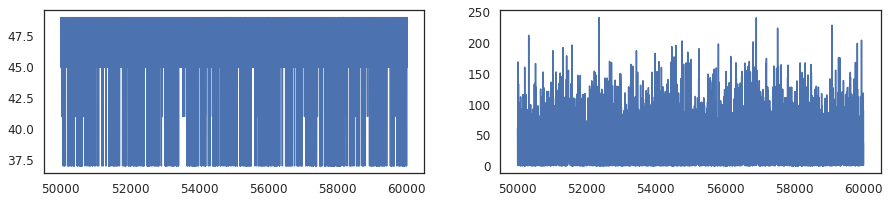

In [163]:
app = 'LORA_10'
idx_start = 50_000
idx_end = 60_000
fig, axes = plt.subplots(1, 2, figsize=(15, 3))

df_true = pd.read_csv(f"DATA/PROCESS/df_raw_{app}.csv")
axes[0].plot(df_true['length_total'].iloc[idx_start:idx_end])
axes[1].plot(df_true['time_diff'].iloc[idx_start:idx_end])

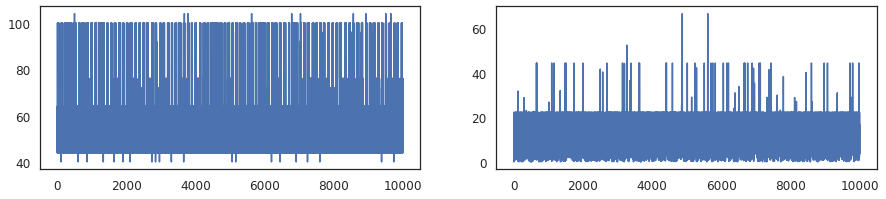

In [161]:
app = 'LORA_1'
idx_start = 0
idx_end = 10_000
fig, axes = plt.subplots(1, 2, figsize=(15, 3))

df_true = pd.read_csv(f"DATA/PROCESS/df_raw_{app}.csv")
axes[0].plot(df_true['length_total'].iloc[idx_start:idx_end])
axes[1].plot(df_true['time_diff'].iloc[idx_start:idx_end])

In [ ]:
# 'frequency', 'snr', 'spreading_factor', 'rssi'
# Evaluer les combinsaison deux à deux
#plt.scatter(x=df_gen['spreading_factor_lstm'], y=df_gen['rssi_lstm'])

##### 4.1 SNR to RSSI

<AxesSubplot:xlabel='Count', ylabel='snr_lstm'>

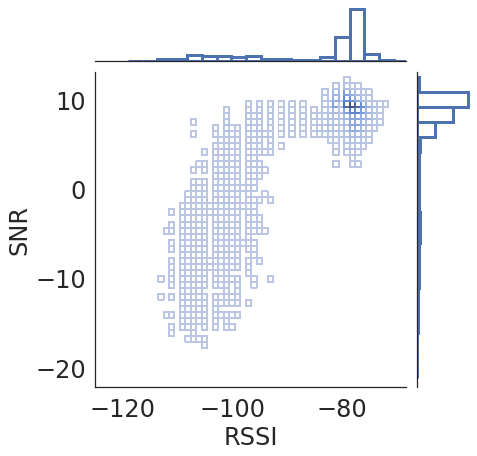

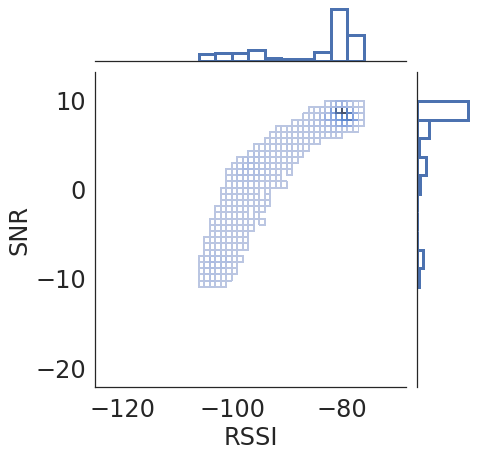

In [76]:
# With LORA_1 it's better

########## PARAMS ############
LABEL_FONTSIZE = 24
TICK_FONTSIZE = 24
TITLE_FONTSIZE = 24
LEGEND_FONTSIZE = 24

YLIM = [0, 1.1]

COEFF = 0.05 # To increase upper limit

LINEWIDTH = 3
sns.set_style("white")
##############################

snr_min_true = df_true['snr'].min() + df_true['snr'].min()*COEFF
snr_max_true = df_true['snr'].max() + df_true['snr'].max()*COEFF

snr_min_gen = df_gen['snr_lstm'].min() + df_gen['snr_lstm'].min()*COEFF
snr_max_gen = df_gen['snr_lstm'].min() + df_gen['snr_lstm'].min()*COEFF

rssi_min_true = df_true['rssi'].min() + df_true['rssi'].min()*COEFF
rssi_max_true = df_true['rssi'].max() + df_true['rssi'].max()*COEFF

rssi_min_gen = df_gen['rssi_lstm'].min() + df_gen['rssi_lstm'].min()*COEFF
rssi_max_gen = df_gen['rssi_lstm'].max() + df_gen['rssi_lstm'].max()*COEFF

# DATA TRUE

bins = 50
bins_dist = 20

g = sns.JointGrid()

sns.histplot(x=df_true['rssi'], 
             y=df_true['snr'], 
             ec="b", fc="none",
             bins=bins,

             pthresh=.05, #pmax=.9,
             discrete=(True, False),
             
             linewidth=1,
             ax=g.ax_joint)
g.ax_joint.set_xlabel(
    "RSSI", fontsize=LABEL_FONTSIZE)
g.ax_joint.set_ylabel(
    "SNR", fontsize=LABEL_FONTSIZE)
g.ax_joint.tick_params(
    labelsize=TICK_FONTSIZE)
g.ax_joint.set_xlim(
    [min(rssi_min_true, rssi_min_gen), 
     max(rssi_max_true, rssi_max_gen)])
g.ax_joint.set_ylim(
    [min(snr_min_true, snr_min_gen), 
     max(snr_max_true, snr_max_gen)])

sns.histplot(x=df_true['rssi'], 
             fill=False, 
             linewidth=LINEWIDTH, 
             bins=bins_dist, 
             ax=g.ax_marg_x)

sns.histplot(y=df_true['snr'], 
             fill=False, 
             linewidth=LINEWIDTH,
             bins=bins_dist,
             ax=g.ax_marg_y)

# DATA GEN

bins = 30
bins_dist = 10
coeff = 0.05

g = sns.JointGrid()

sns.histplot(x=df_gen['rssi_lstm'], 
             y=df_gen['snr_lstm'], 
             ec="b", fc="none",
             bins=bins,
             linewidth=1,
             ax=g.ax_joint)
g.ax_joint.set_xlabel(
    "RSSI", fontsize=LABEL_FONTSIZE)
g.ax_joint.set_ylabel(
    "SNR", fontsize=LABEL_FONTSIZE)
g.ax_joint.tick_params(
    labelsize=TICK_FONTSIZE)
g.ax_joint.set_xlim(
    [min(rssi_min_true, rssi_min_gen), 
     max(rssi_max_true, rssi_max_gen)])
g.ax_joint.set_ylim(
    [min(snr_min_true, snr_min_gen), 
     max(snr_max_true, snr_max_gen)])

sns.histplot(x=df_gen['rssi_lstm'], 
             fill=False, 
             linewidth=LINEWIDTH, 
             bins=bins_dist, 
             ax=g.ax_marg_x)

sns.histplot(y=df_gen['snr_lstm'], 
             fill=False, 
             linewidth=LINEWIDTH,
             bins=bins_dist,
             ax=g.ax_marg_y)

##### 4.2 Spreading factor with SNR

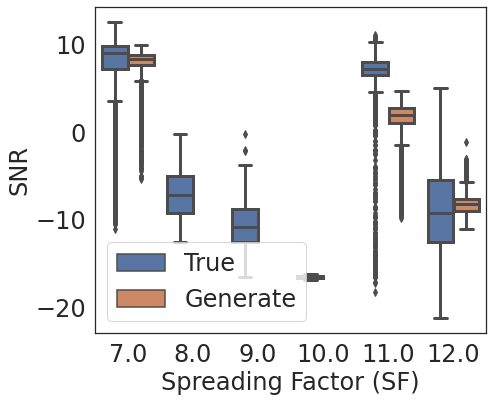

In [87]:
# DATA TRUE

########## PARAMS ############
LABEL_FONTSIZE = 24
TICK_FONTSIZE = 24
TITLE_FONTSIZE = 24
LEGEND_FONTSIZE = 24

YLIM = [0, 1.1]

COEFF = 0.05 # To increase upper limit

LINEWIDTH = 3
sns.set_style("white")
##############################

df_plot_true = pd.concat(
    [df_true['spreading_factor'], 
     df_true['snr']], axis=1)
df_plot_true['Dataset'] = "True"

# DATA GEN

df_plot_gen =  pd.concat(
    [df_gen[['spreading_factor_lstm']].rename(
        columns={'spreading_factor_lstm':'spreading_factor'}), 
     df_gen[['snr_lstm']].rename(
        columns={'snr_lstm':'snr'}) ], axis=1)
df_plot_gen['Dataset'] = "Generate"

df_plot = pd.concat(
    [df_plot_true, 
     df_plot_gen], axis=0)

fig, ax = plt.subplots(1, 1, figsize=(7, 6))

sns.boxplot(x="spreading_factor", y="snr", hue="Dataset",
            data=df_plot, 
            linewidth=LINEWIDTH, 
            ax=ax)
ax.set_xlabel("Spreading Factor (SF)", fontsize=LABEL_FONTSIZE)
ax.set_ylabel("SNR", fontsize=LABEL_FONTSIZE)
ax.legend(fontsize=LEGEND_FONTSIZE)#['True', 'Generate'], fontsize=LEGEND_FONTSIZE)
ax.tick_params(
    labelsize=TICK_FONTSIZE)

In [ ]:
# PLOT DATA

fig, ax = plt.subplots(
        1, 1, figsize=(6, 5.5))

# True
sns.ecdfplot(data=df_true[['spreading_factor']], 
             x='spreading_factor', 
             ax=ax, 
             linewidth=2.5,
             palette="tab10")

# Generate
sns.ecdfplot(data=df_gen[['spreading_factor_lstm']], 
             x='spreading_factor_lstm', 
             ax=ax, 
             linewidth=2.5,
             palette="tab10")

ax.set_xlabel("IPT (in second)")
ax.set_title(f"{app}")
ax.legend(['True', 'Generate'])#, loc="upper left")


if (app == "SNMP"):
    ax.set_xlim([-100, 1000])
    ax.set_ylim([0.998, 1.])

In [ ]:
# Mettre carré de zoom (pour un ou deux)
# Faire tableau avec pourcentage (différence avec la courbe d'origine avec métrique)
# Couper les graphes sur l'axes des x 99% des valeurs

### 4.2 Rate byte/s

In [21]:
# EXTRACT GEN RATE
df_gen_rate = df_gen[['timesteps_lstm', 'length_total_lstm']].copy()
df_gen_rate['datetime'] = df_gen_rate['timesteps_lstm'].map(map_time)
df_gen_rate = df_gen_rate.set_index('datetime').sort_index()
gen_rate = df_gen_rate['length_total_lstm'].resample(
                '1s').sum().values

# EXTRACT TRUE RATE
# df_true.iloc[3000:5000] -> For SNMP
df_true_rate = df_true[['timestamps', 'length_total']].copy()
df_true_rate['datetime'] = df_true_rate['timestamps'].map(map_time)
df_true_rate = df_true_rate.set_index('datetime').sort_index()
true_rate = df_true_rate['length_total'].resample(
                '1s').sum().values#.reset_index(drop=True) 

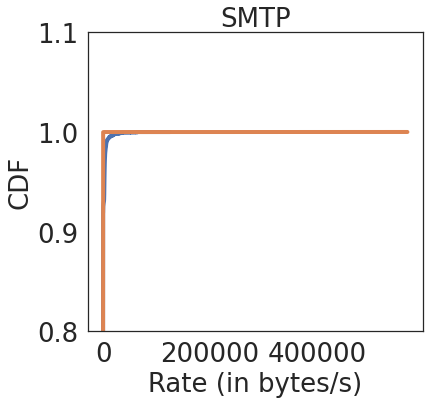

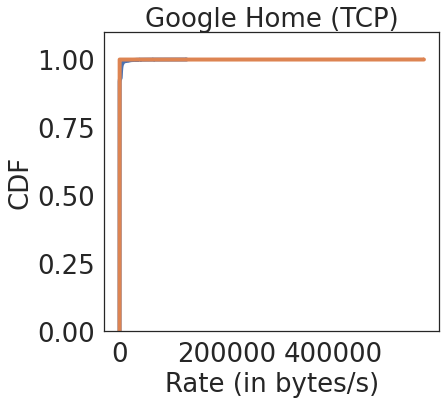

In [22]:
# PLOT DATA

for i in range(2):

    fig, ax = plt.subplots(
            1, 1, figsize=(6, 5.5))

    # True
    sns.ecdfplot(x=true_rate, 
                 ax=ax, 
                 linewidth=LINEWIDTH,
                 palette="tab10")

    # Generate
    sns.ecdfplot(x=gen_rate, 
                 ax=ax, 
                 linewidth=LINEWIDTH,
                 palette="tab10")

    ax.set_xlabel("Rate (in bytes/s)", fontsize=LABEL_FONTSIZE)
    ax.set_ylabel("CDF", fontsize=LABEL_FONTSIZE)
    ax.tick_params(
        labelsize=TICK_FONTSIZE)
    #ax.legend(['True', 'Generate'], fontsize=LEGEND_FONTSIZE, loc="upper left")
    ax.set_ylim([0, YLIM[-1]])
    #ax.set_title(f"LORA (fport: 1)", fontsize=TITLE_FONTSIZE)
    ax.set_title(f"{app}", fontsize=TITLE_FONTSIZE)
    #ax.set_title(f"Google Home (UDP)", fontsize=TITLE_FONTSIZE)
    ax.set_title(f"Google Home (TCP)", fontsize=TITLE_FONTSIZE)
    #ax.set_title(f"LoraWAN (fport: 1)", fontsize=TITLE_FONTSIZE)
    
    if (i == 0):
    

        if (app == "HTTP"):
            ax.set_xlim([-10000, 175_000])
            ax.set_ylim([0.80, YLIM[-1]+0.01])
            ax.set_title(f"{app}", fontsize=TITLE_FONTSIZE)
        elif (app == 'SMTP'):
            ax.set_ylim([0.80, YLIM[-1]])
            ax.set_title(f"{app}", fontsize=TITLE_FONTSIZE)
        elif (app == "LORA_1"):
            ax.set_ylim([0.8, YLIM[-1]])
            ax.set_title(f"LORA (fport: 1)", fontsize=TITLE_FONTSIZE)
        elif (app == "LORA_10"):
            ax.set_ylim([0.8, YLIM[-1]])
            ax.set_title(f"LORA (fport: 10)", fontsize=TITLE_FONTSIZE)
        elif (app == "LORA_10"):
            ax.set_ylim([0.8, YLIM[-1]])
            ax.set_title(f"LORA (fport : 10)", fontsize=TITLE_FONTSIZE)
        elif (app == "TCP_GOOGLE_HOME"):
            ax.set_ylim([0.9, YLIM[-1]])
            ax.set_title(f"Google Home (TCP)", fontsize=TITLE_FONTSIZE)
        elif (app == "UDP_GOOGLE_HOME"):
            ax.set_ylim([0.7, YLIM[-1]])
            ax.set_title(f"Google Home (UDP)", fontsize=TITLE_FONTSIZE)
        elif (app == "SNMP"):
            ax.set_ylim([0.95, 1.05])
            ax.set_title(f"{app}", fontsize=TITLE_FONTSIZE)

### 4.2 Rate packet/s

In [23]:
# EXTRACT GEN RATE
df_gen_rate = df_gen[['timesteps_lstm', 'length_total_lstm']].copy()
df_gen_rate['datetime'] = df_gen_rate['timesteps_lstm'].map(map_time)
df_gen_rate = df_gen_rate.set_index('datetime').sort_index()
gen_rate = df_gen_rate['length_total_lstm'].resample(
                '1s').count().values

# EXTRACT TRUE RATE
df_true_rate = df_true[['timestamps', 'length_total']].copy()
df_true_rate['datetime'] = df_true_rate['timestamps'].map(map_time)
df_true_rate = df_true_rate.set_index('datetime').sort_index()
true_rate = df_true_rate['length_total'].resample(
                '1s').count().values#.reset_index(drop=True) 

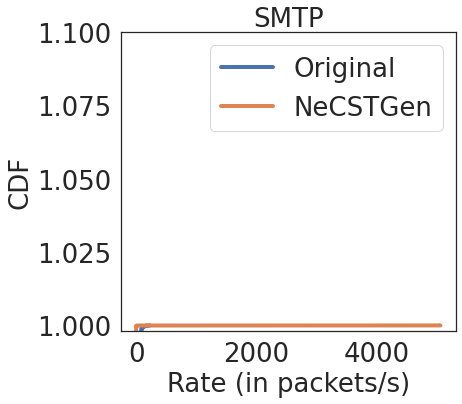

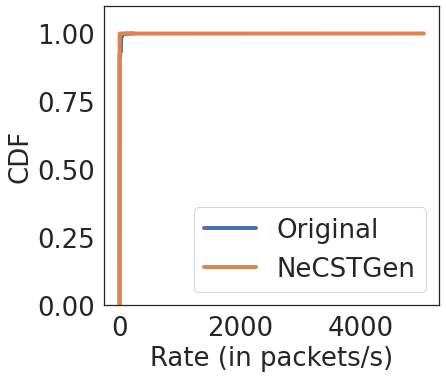

In [25]:
# PLOT DATA

for i in range(2):

    fig, ax = plt.subplots(
            1, 1, figsize=(6, 5.5))

    # True
    sns.ecdfplot(x=true_rate, 
                 ax=ax, 
                 linewidth=LINEWIDTH,
                 palette="tab10")

    # Generate
    sns.ecdfplot(x=gen_rate, 
                 ax=ax, 
                 linewidth=LINEWIDTH,
                 palette="tab10")

    ax.set_xlabel("Rate (in packets/s)", fontsize=LABEL_FONTSIZE)
    ax.set_ylabel("CDF", fontsize=LABEL_FONTSIZE)
    ax.tick_params(
        labelsize=TICK_FONTSIZE)
    ax.set_ylim([0, YLIM[-1]])
    ax.legend(['Original', 'NeCSTGen'], fontsize=LEGEND_FONTSIZE)#, loc="upper left")

    if (i == 0):
    
        if (app == "LORA_1"):
            ax.set_ylim([0.9, YLIM[-1]])
            ax.set_title(f"LORA (fport : 1)", fontsize=TITLE_FONTSIZE)
        if (app == "LORA_10"):
            ax.set_ylim([0.9, YLIM[-1]])
            ax.set_title(f"LORA (fport : 10)", fontsize=TITLE_FONTSIZE)
        elif (app == 'SMTP'):
            ax.set_ylim([0.998, YLIM[-1]])
            ax.set_title(f"{app}", fontsize=TITLE_FONTSIZE)
        elif (app == "HTTP"):
            ax.set_ylim([0.98, YLIM[-1]])
            ax.set_title(f"{app}", fontsize=TITLE_FONTSIZE)
        elif (app == "TCP_GOOGLE_HOME"):
            ax.set_ylim([0.9, YLIM[-1]])
            ax.set_title(f"GOOGLE HOME (TCP)", fontsize=TITLE_FONTSIZE)
        elif (app == "SNMP"):
            ax.set_ylim([0.8, YLIM[-1]])
            ax.set_title(f"{app}", fontsize=TITLE_FONTSIZE)

### 4.2 Rate packets/flow

In [152]:
# EXTRACT GEN RATE
df_gen_rate = df_gen[['timesteps', 'count_total']].copy()
df_gen_rate['datetime'] = df_gen_rate['timesteps'].map(map_time)
df_gen_rate = df_gen_rate.set_index('datetime').sort_index()
gen_rate = df_gen_rate['count_total'].resample(
                '1s').sum().values

# EXTRACT TRUE RATE
df_true_rate = df_true[['timesteps', 'flow_id_count']].copy()
df_true_rate['datetime'] = df_true_rate['timesteps'].map(map_time)
df_true_rate = df_true_rate.set_index('datetime').sort_index()
true_rate = df_true_rate['flow_id_count'].resample(
                '1s').sum().values#.reset_index(drop=True) 

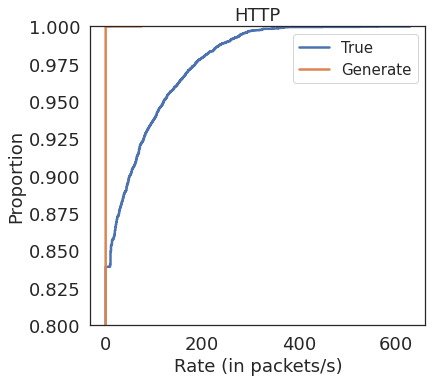

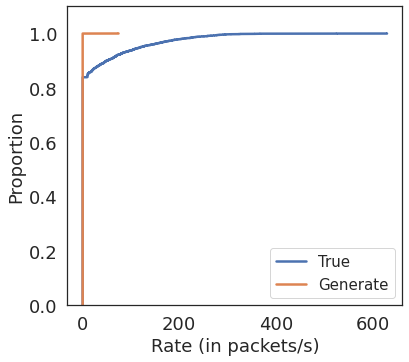

In [153]:
# PLOT DATA

for i in range(2):

    fig, ax = plt.subplots(
            1, 1, figsize=(6, 5.5))

    # True
    sns.ecdfplot(x=true_rate, 
                 ax=ax, 
                 linewidth=LINEWIDTH,
                 palette="tab10")

    # Generate
    sns.ecdfplot(x=gen_rate, 
                 ax=ax, 
                 linewidth=LINEWIDTH,
                 palette="tab10")

    ax.set_xlabel("Rate (in packets/s)", fontsize=LABEL_FONTSIZE)
    ax.set_ylabel("CDF", fontsize=LABEL_FONTSIZE)
    ax.tick_params(
        labelsize=TICK_FONTSIZE)
    ax.legend(['True', 'Generate'], fontsize=LEGEND_FONTSIZE)#, loc="upper left")
    ax.set_ylim([0, YLIM[-1]])

    if (i == 0):
    
        if (app == "HTTP"):
            #ax.set_xlim([-100, 1000])
            ax.set_ylim([0.8, YLIM[-1]])
            ax.set_title(f"{app}", fontsize=TITLE_FONTSIZE)

### 4.2 Rate flows/s

In [150]:
# EXTRACT GEN RATE
df_gen_rate = df_gen[['timesteps', 'count_total']].copy()
df_gen_rate['datetime'] = df_gen_rate['timesteps'].map(map_time)
df_gen_rate = df_gen_rate.set_index('datetime').sort_index()
gen_rate = df_gen_rate['count_total'].resample(
                '1s').count().values

# EXTRACT TRUE RATE
df_true_rate = df_true[['timesteps', 'flow_id_count']].copy()
df_true_rate['datetime'] = df_true_rate['timesteps'].map(map_time)
df_true_rate = df_true_rate.set_index('datetime').sort_index()
true_rate = df_true_rate['flow_id_count'].resample(
                '1s').count().values

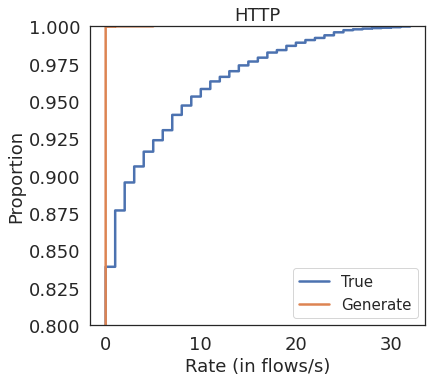

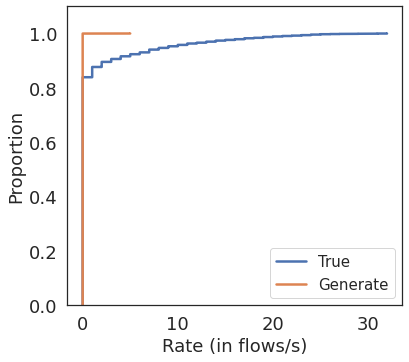

In [151]:
# PLOT DATA

for i in range(2):

    fig, ax = plt.subplots(
            1, 1, figsize=(6, 5.5))

    # True
    sns.ecdfplot(x=true_rate, 
                 ax=ax, 
                 linewidth=LINEWIDTH,
                 palette="tab10")

    # Generate
    sns.ecdfplot(x=gen_rate, 
                 ax=ax, 
                 linewidth=LINEWIDTH,
                 palette="tab10")

    ax.set_xlabel("Rate (in flows/s)", fontsize=LABEL_FONTSIZE)
    ax.set_ylabel("CDF", fontsize=LABEL_FONTSIZE)
    ax.tick_params(
        labelsize=TICK_FONTSIZE)
    ax.legend(['True', 'Generate'], fontsize=LEGEND_FONTSIZE)#, loc="upper left")
    ax.set_ylim([0, YLIM[-1]])

    if (i == 0):
    
        if (app == "HTTP"):
            #ax.set_xlim([-100, 1000])
            ax.set_ylim([0.8, YLIM[-1]])
            ax.set_title(f"{app}", fontsize=TITLE_FONTSIZE)

### 4.3 Inter packet time distribution (time_diff)

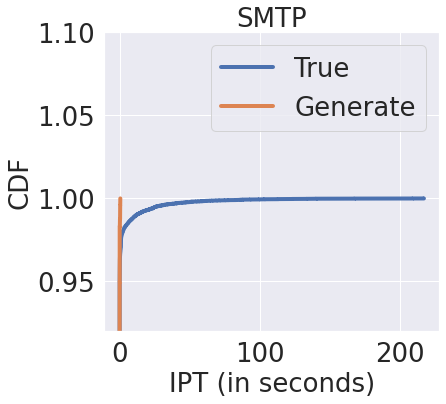

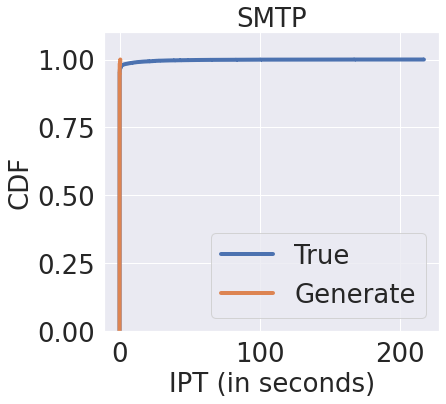

In [137]:
# PLOT DATA

for i in range(2):

    fig, ax = plt.subplots(
            1, 1, figsize=(6, 5.5))

    # True
    g_true = sns.ecdfplot(data=df_true[['time_diff']], 
                 x='time_diff', 
                 ax=ax, 
                 linewidth=LINEWIDTH,
                 palette="tab10")

    # Generate
    g_gen = sns.ecdfplot(data=df_gen[['time_diff_lstm']], 
                 x='time_diff_lstm', 
                 ax=ax, 
                 linewidth=LINEWIDTH,
                 palette="tab10")

    ax.set_xlabel("IPT (in seconds)", fontsize=LABEL_FONTSIZE)
    ax.set_ylabel("CDF", fontsize=LABEL_FONTSIZE)
    ax.tick_params(
        labelsize=TICK_FONTSIZE)
    ax.legend(['True', 'Generate'], fontsize=LEGEND_FONTSIZE)#, loc="upper left")
    ax.set_ylim([0, YLIM[-1]])
    #ax.set_title(f"Google Home (TCP)", fontsize=TITLE_FONTSIZE)
    ax.set_title(f"Google Home (UDP)", fontsize=TITLE_FONTSIZE)
    ax.set_title(f"{app}", fontsize=TITLE_FONTSIZE)
    
    
    if (i == 0):

        if (app == "SNMP"):
            ax.set_xlim([-100, 1000])
            ax.set_ylim([0.90, YLIM[-1]])
            ax.set_title(f"{app}", fontsize=TITLE_FONTSIZE)
        elif (app == "SMTP"):
            #ax.set_xlim([-100, 1000])
            ax.set_ylim([0.92, YLIM[-1]])
            ax.set_title(f"{app}", fontsize=TITLE_FONTSIZE)
        elif (app == "HTTP"):
            ax.set_xlim([-10, 50])
            ax.set_ylim([0.95, YLIM[-1]])
            ax.set_title(f"{app}", fontsize=TITLE_FONTSIZE)
        elif (app == "LORA_1"):
            ax.set_title(f"LORA (fport: 1)", fontsize=TITLE_FONTSIZE)
        elif (app == "LORA_10"):
            ax.set_title(f"LORA (fport: 10)", fontsize=TITLE_FONTSIZE)
        elif (app == "TCP_GOOGLE_HOME"):
            ax.set_xlim([-1, 20])
            ax.set_ylim([0.90, YLIM[-1]])
            ax.set_title(f"Google Home (TCP)", fontsize=TITLE_FONTSIZE)
        elif (app == "UDP_GOOGLE_HOME"):
            ax.set_xlim([-1, 20])
            ax.set_ylim([0.85, 1.05])
            ax.set_title(f"Google Home (UDP)", fontsize=TITLE_FONTSIZE)

### 4.4 Packet length

KeyError: "None of [Index(['length_total_lstm'], dtype='object')] are in the [columns]"

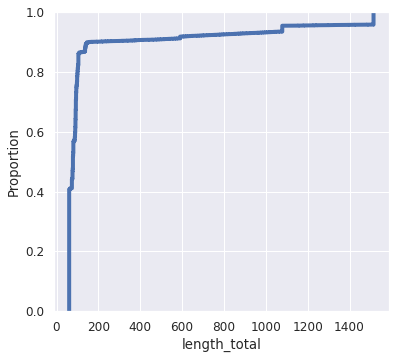

In [133]:
# PLOT DATA

for i in range(2):
    
    fig, ax = plt.subplots(
        1, 1, figsize=(6, 5.5))

    # True
    g_true = sns.ecdfplot(data=df_true[['length_total']], 
                 x='length_total', 
                 ax=ax, 
                 linewidth=LINEWIDTH,
                 palette="tab10")

    # Generate
    g_gen = sns.ecdfplot(data=df_gen[['length_total_lstm']], 
                 x='length_total_lstm', 
                 ax=ax, 
                 linewidth=LINEWIDTH,
                 palette="tab10")

    ax.set_xlabel("Packet length", fontsize=LABEL_FONTSIZE)
    ax.set_ylabel("CDF", fontsize=LABEL_FONTSIZE)
    ax.tick_params(
        labelsize=TICK_FONTSIZE)
    ax.legend(['True', 'Generate'], fontsize=LEGEND_FONTSIZE) #, loc="upper left")
    ax.set_ylim([0, YLIM[-1]])
    
    # Rétrécissement que pour la version ZOOME !
    if (i == 0):
        
        if (app == "LORA_1"):
            ax.set_title(f"LORA (fport: 1)", fontsize=TITLE_FONTSIZE)
        elif (app == "LORA_10"):
            ax.set_title(f"LORA (fport : 10)", fontsize=TITLE_FONTSIZE)
        elif (app == "TCP_GOOGLE_HOME"):
            ax.set_title(f"Google Home (TCP)", fontsize=TITLE_FONTSIZE)
        elif (app == "UDP_GOOGLE_HOME"):
            ax.set_title(f"Google Home (UDP)", fontsize=TITLE_FONTSIZE)
        elif (app == "SNMP"):
            #ax.set_xlim([120, 200])
            ax.set_title(f"{app}", fontsize=TITLE_FONTSIZE)
        else:
            ax.set_title(f"{app}", fontsize=TITLE_FONTSIZE)

In [ ]:
# PLOT DATA RAW FUNCTION OF FLAGS

fig, axes = plt.subplots(
        1, 2, figsize=(13, 5))

# DATA GEN
sns.ecdfplot(data=df_gen, 
             x='length_total_lstm', 
             ax=axes[0], hue='flags', 
             linewidth=2.5,
             palette="tab10")
axes[0].set_xlabel("Packet length", fontsize=LABEL_FONTSIZE)
axes[0].set_ylabel("CDF", fontsize=LABEL_FONTSIZE)
axes[0].tick_params(
    labelsize=TICK_FONTSIZE)
axes[0].set_ylim([0, YLIM[-1]])
#axes[0].legend(fontsize=LEGEND_FONTSIZE)

# DATA TRUE
sns.ecdfplot(data=df_true, 
             x='length_total', 
             ax=axes[1], hue='flags',
             linewidth=2.5,
             palette="tab10")
axes[1].set_xlabel("Packet length", fontsize=LABEL_FONTSIZE)
axes[1].set_ylabel("Packet length", fontsize=LABEL_FONTSIZE)
axes[1].tick_params(
    labelsize=TICK_FONTSIZE)
axes[1].set_ylim([0, YLIM[-1]])

if (app == "TCP_GOOGLE_HOME"):
    axes[0].set_title(f"GOOGLE HOME Generate", fontsize=TITLE_FONTSIZE)  
    axes[1].set_title(f"GOOGLE HOME True", fontsize=TITLE_FONTSIZE)  
else:
    axes[0].set_title(f"{app} Generate", fontsize=TITLE_FONTSIZE)
    axes[1].set_title(f"{app} True", fontsize=TITLE_FONTSIZE)

### 4.3 RTT

In [426]:
# Compute RTT (use direction and time)... => donc direction pour SNMP et GOOGLE HOME et TCP GOOGLE HOME !

In [34]:
def get_rtt(df_raw):
    
    flows_id = df_raw[
        'flow_id'].value_counts().index
    list_rtt = []
    list_flow_id = []
    list_time_diff = []
    
    df_results = pd.DataFrame()
    
    for f in tqdm(flows_id):
        cond = (df_raw['flow_id'] == f)
        df_pos_rtt = df_raw[
            cond].reset_index(drop=True)
        
        df_pos_rtt['diff_direction'] = df_pos_rtt[
            'direction'].diff(1).abs().fillna(0)
        df_pos_rtt.at[0, 'time_diff'] = 0

        for i in range(df_pos_rtt.shape[0]):
            value = df_pos_rtt[
                'diff_direction'].iloc[i]

            #if (value == 0):
            list_time_diff.append(
                    df_pos_rtt['time_diff'].iloc[i])
            #else:
            if (value != 0):
                list_rtt.append(
                    sum(list_time_diff))
                list_flow_id.append(f)
                #print("[DEBUG] list_rtt : ", list_rtt)
                #print("[DEBUG] list_flow_id : ", list_flow_id)
                list_time_diff = []
                
        # Reset if no answers ! 
        list_time_diff = []
    
    df_results['flow_id'] = list_flow_id
    df_results['rtt'] = list_rtt
    
    return df_results

In [35]:
df_true_rtt = get_rtt(df_true)
df_gen_rtt = get_rtt(df_gen)

100%|██████████| 117/117 [00:00<00:00, 197.23it/s]


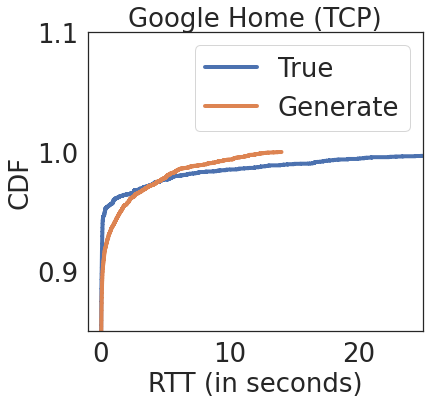

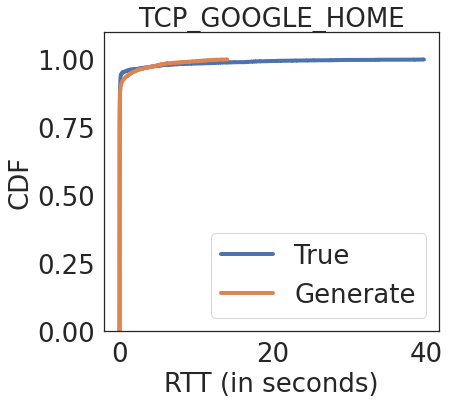

In [39]:
# PLOT DATA

for i in range(2):

    fig, ax = plt.subplots(
            1, 1, figsize=(6, 5.5))

    # True
    sns.ecdfplot(data=df_true_rtt, 
                 x='rtt', 
                 ax=ax, 
                 linewidth=LINEWIDTH,
                 palette="tab10")

    # Generate
    sns.ecdfplot(data=df_gen_rtt, 
                 x='rtt', 
                 ax=ax, 
                 linewidth=LINEWIDTH,
                 palette="tab10")

    ax.set_xlabel("RTT (in seconds)", fontsize=LABEL_FONTSIZE)
    ax.set_ylabel("CDF", fontsize=LABEL_FONTSIZE)
    ax.tick_params(
        labelsize=TICK_FONTSIZE)
    ax.legend(['True', 'Generate'], fontsize=LEGEND_FONTSIZE) #, loc="upper left")
    ax.set_ylim(YLIM)
    ax.set_title(f"{app}", fontsize=TITLE_FONTSIZE)
    #ax.set_title(f"Google Home (TCP)", fontsize=TITLE_FONTSIZE)
    #ax.set_title(f"Google Home (UDP)", fontsize=TITLE_FONTSIZE)

    if (i == 0):

        if (app == "TCP_GOOGLE_HOME"):
            ax.set_title(f"Google Home (TCP)", fontsize=TITLE_FONTSIZE)
            ax.set_xlim([-1, 25])
            ax.set_ylim([0.85, 1.1])
        if (app == "UDP_GOOGLE_HOME"):
            ax.set_title(f"Google Home (UDP)", fontsize=TITLE_FONTSIZE)
            ax.set_xlim([-1, 10])
            ax.set_ylim([0.75, 1.05])
        elif (app == "HTTP"):
            ax.set_title(f"{app}", fontsize=TITLE_FONTSIZE)
            #ax.set_xlim([-100, 1000])
            ax.set_ylim([0.99, 1.0005])
        elif (app == "SMTP"):
            ax.set_title(f"{app}", fontsize=TITLE_FONTSIZE)
            #ax.set_xlim([-100, 1000])
            ax.set_ylim([0.93, 1.05])
        elif (app == "SNMP"):
            ax.set_title(f"{app}", fontsize=TITLE_FONTSIZE)
            ax.set_xlim([-1, 10])
            ax.set_ylim([0.90, 1.05])
        #else:
        #    ax.set_title(f"{app}", fontsize=TITLE_FONTSIZE)

### 4.3 Wavelet Analysis

In [286]:
# Trace a une seconde constant
# Trace 8 secondes par exemple
# TRace un tous seul
# Poisonniens (loi e Poisson)

# Generer les courbes sur une échelle de temps défini (1h/2h)
# -> source de PB pour des trafic humain

# Faire les séries temporelles de débit (TO DO)
# -> avec les meme echelles de temps 
# -> Permet d'introduire les différentes échelles de temps (Wavelet).

# L'outils peur bien faire l'aspect proto mais mal laspect humaine
# -> Faire le lien durant Wevelet (Pb de HTTP/SMTP)
# -> PB de variablitité des différentes échelles de temps.

# CDF -> Mettre + de 1.0 (1.1) set_ylim()
# DONE !

# Insister sur les coté réalistes (corr avec les variables exogènes).

# Mettre tableau pour les frags OU courbe de succession de bonne séquence (cohérence séquentielle SYN/SYN-ACK/ACK)
# -> FAIRE TABLEAU !!! X% pour chaque type de traffic
# NON FAIRE GRAPHE !! %  de bonnes cohérence séquentielle

# Si plus de SYN SYN/ACK faire bareeplot pour montre la distribution (superposer)
# DIre ensuite que 90% des connxxion des 

# SI c'est différent on fait plusieurs ligne dans le tableau pas besoin de mettre plusieurs lignes
# -> SInon mettre petite figure

# Faire une tableau de synthèse
# -> Avec pourcentage de différence entre les valeurs vrai et la génération.
# => QUE POUR packet/s ? ou ailleurs ? (si pas de place !)

# PRIOTIRT2 : génération constante ondelette !
# -> Courbe droite etrange ! (Peut etre en secours)
# -> Intéréssant pour de l'IoT

# Petite comparaison
# -> Insister sur le coté généraliste

# Faire une différence de CDF et mesurer l'ecart en pourcentage sur 95 %  des valeurs ?

In [104]:
def get_cis(data, alpha=0.95, 
            normalize=False, 
            return_stats=False,
            n_iterations=1000):
    
    stats = {}
    cis = {}
    keys = data.columns.values
    for k in keys:
        #stats[k] = [0]*n_iterations
        cis[k] = [0, 0]
        
    for i in range(n_iterations):
        data_sample = data.sample(frac=0.65, replace=True)
        data_counts = data_sample.shape[0] #.values.reshape(1, -1)
        for k in data_sample.columns:
            #stats[k][i] = data_counts[k].values
            stats[k] = np.log2(
                data_sample[k].values.std())
        
    # confidence intervals
    for k in keys:
        p = ((1.0-alpha)/2.0)# * 100
        lower = np.percentile(stats[k], p)
        p = (alpha+((1.0-alpha)/2.0))# * 100
        upper = np.percentile(stats[k], p)
        cis[k] = [lower, upper]
    
    if(return_stats):
        return cis, stats
    else:
        return cis

In [105]:
def generate_index(data, num=10):
    df = data.copy()
    index = df.index.values
    for i in [2**i for i in range(0, num)]:
        index_new = np.repeat(index[:int(index.shape[0]/i)+10], i)
        #print("i : ", i)
        #print("index_new : ", index_new)
        #print("data.shape[0] : ", data.shape[0])
        df[f'index_{i}'] = index_new[0:data.shape[0]]
    return df

In [106]:
def extract_rate(data, app):
    cond = ((data['time_diff'] != 0) &
            (data['applications'] == app))
    min_diff = int(data[cond]['time_diff'].min() * (1e6))
    
    data_filter = data[cond].sort_index()#.reset_index(drop=True)
    
    rate = data_filter['length_total'].resample(
                 f'{min_diff}ms').sum().values
    df_rate = pd.DataFrame()
    df_rate['rate'] = rate
    return df_rate

In [55]:
df_gen_rate = df_gen[['timesteps_lstm', 'length_total_lstm']].copy()
df_gen_rate['datetime'] = df_gen_rate['timesteps_lstm'].map(map_time)
df_gen_rate = df_gen_rate.set_index('datetime').sort_index()
df_gen_rate = df_gen_rate['length_total_lstm'].resample(
                '200ms').sum()

df_gen_rate = pd.DataFrame(
    df_gen_rate.values, columns=["length_total"])
df_rate_gen = df_gen_rate
#df_rate_gen = generate_index(
#    data=df_gen_rate, num=11).rename({'length_total' : "rate"})
#df_rate_gen = df_rate_gen.iloc[0:600000]

In [271]:
df_test = pd.DataFrame()
df_test['timestamps'] = np.arange(0, 10000, 0.2)
df_test['length_total'] = ([0]*9+[10])*5000

In [49]:
df_true.iloc[0:60000]['filename'].value_counts()

week1_monday.tcpdump    40000
Name: filename, dtype: int64

In [56]:
df_true_rate = df_true[['timestamps', 'length_total']].copy() # FOR SMTP (que sur 1 jour !) !!! : .iloc[0:60000]
df_true_rate['datetime'] = df_true_rate['timestamps'].map(map_time)
df_true_rate = df_true_rate.set_index('datetime').sort_index()
df_true_rate = df_true_rate['length_total'].resample(
                '200ms').sum()

df_true_rate = pd.DataFrame(
    df_true_rate.values, columns=["length_total"])
df_rate_true = df_true_rate
#df_rate_true = generate_index(
#    data=df_true_rate, num=11).rename({'length_total' : "rate"})
#df_rate_true = df_rate_true.iloc[0:600000]

In [57]:
# df_test = pd.DataFrame()
# df_test['timestamps'] = np.arange(0, 4000, 0.1)
# df_test['length_total'] = ([0]*99+[100])*400

#[56, 40, 8, 24, 48, 48, 40, 16]
#[0, 0, 1, 1, 1, 1, 0, 0]*2

# https://www.math.aau.dk/digitalAssets/120/120646_r-2003-24.pdf
# https://mil.ufl.edu/nechyba/www/eel6562/course_materials/t5.wavelets/intro_dwt.pdf
# https://dsp.stackexchange.com/questions/44285/discrete-wavelet-transform-how-to-interpret-approximation-and-detail-coefficien

#results = pywt.wavedec(
#            [56, 40, 8, 24, 48, 48, 40, 16], #[0, 0, 1, 1, 1, 1, 0, 0]*2, #mode='constant', 
#            level=2,
#            wavelet='haar', axis=0)

#cA, cD = results[0], results[1]

In [58]:
df_plot = pd.DataFrame()

dict_val = {}
#range_k = [488e-6, 0.002, 0.0078, 0.031, 
#           0.12, 0.5, 2, 8, 32, 128, 512]
range_k = [0.002, 0.0078, 0.031, 
           0.12, 0.5, 2, 8, 
            32]#, 128]#, 512]
range_i = [2**i for i in range(0, 8)]
#range_i = [2**i for i in range(1, 10)]
keys = [str(i) for i in range(len(range_i))]


for df, t in zip([df_rate_true, df_rate_gen], 
                 ["True", "Generate"]):

    df_plot_tmp = pd.DataFrame()
    values = []
    x_values = []
    
    #range_k = range_k[:7]
    #range_i = range_i[:7]
    
    dwt_level = 1
    
    rate = df['length_total'].values.ravel()

    for k, i, key in zip(range_k,
                         range_i,
                         keys):
        
        print("")

        #rate = df[['length_total', f"index_{i}"]].groupby(
        #    f"index_{i}").sum().values

        #https://dsp.stackexchange.com/questions/44285/discrete-wavelet-transform-how-to-interpret-approximation-and-detail-coefficien
        #cA, cD = pywt.dwt(
        #    rate, mode='constant', 
        #    wavelet=f'db{db_level}') # wavedec with , level=1, , mode='constant'
        
        #x_values.append(dwt_level)
        
        coeff_dtw = pywt.wavedec(
            rate, #mode='constant', 
            level=dwt_level,
            wavelet=f'db1')[1]
        dwt_level += 2
        
        #coeff_dtw = np.concatenate(
        #        coeff_dtw[::2], axis=0)
        #coeff_dtw = coeff_dtw[0]
        #print(coeff_dtw )
        
        dict_val[f"{key}_{t}"] = coeff_dtw
        
        #dict_val[key].append(low_error)
        #dict_val[key].append(high_error)
        
        print("coeff_dtw.size : ", coeff_dtw.size)
        
        values.append(np.log2(
            (1/coeff_dtw.size)*np.sum(
                np.power(coeff_dtw, 2))))
        
        print("t ; np.std(cA) : ", t, ' ; ', values[-1])
        
        #low_error = max(np.log2(
        #    (1/coeff_dtw.size)*np.sum(
        #        np.percentile(np.power(coeff_dtw, 2), 2.5))), 0)
        #high_error = np.log2(
        #    (1/coeff_dtw.size)*np.sum(
        #        np.percentile(np.power(coeff_dtw, 2), 97.5)))
        
        #print("percentile error min; max : ", 
        #      low_error, ' ; ', high_error)
        
        x_values.append(
            np.ceil(np.log2(k)))
        
        if(x_values[-1] == -8):
            x_values[-1] = -9

    df_plot_tmp['values'] = values
    df_plot_tmp['x'] = x_values
    df_plot_tmp['type'] = t

    df_plot = pd.concat([df_plot, 
                         df_plot_tmp])  

df_plot = df_plot.reset_index(drop=True)


coeff_dtw.size :  46791
t ; np.std(cA) :  True  ;  20.332148061552218

coeff_dtw.size :  11698
t ; np.std(cA) :  True  ;  19.967969193120275

coeff_dtw.size :  2925
t ; np.std(cA) :  True  ;  20.349633110438436

coeff_dtw.size :  732
t ; np.std(cA) :  True  ;  20.618926315943543

coeff_dtw.size :  183
t ; np.std(cA) :  True  ;  23.279153972982602

coeff_dtw.size :  46
t ; np.std(cA) :  True  ;  23.75036680510002

coeff_dtw.size :  12
t ; np.std(cA) :  True  ;  23.068396329403427

coeff_dtw.size :  3
t ; np.std(cA) :  True  ;  23.864510660299608

coeff_dtw.size :  71219446
t ; np.std(cA) :  Generate  ;  15.616650014001614

coeff_dtw.size :  17804862
t ; np.std(cA) :  Generate  ;  13.722492160239417

coeff_dtw.size :  4451216
t ; np.std(cA) :  Generate  ;  12.685909780865124

coeff_dtw.size :  1112804
t ; np.std(cA) :  Generate  ;  17.568141327961964

coeff_dtw.size :  278201
t ; np.std(cA) :  Generate  ;  19.791336817097065

coeff_dtw.size :  69551
t ; np.std(cA) :  Generate  ;  21.371

In [256]:
dict_cis = {}

low_yerror_true = [] #[f"{key}_{t}"]
high_yerror_true = []

low_yerror_pred = [] #[f"{key}_{t}"]
high_yerror_pred = []

for k in tqdm(dict_val.keys()):
    df_tmp = pd.DataFrame()
    df_tmp[k] = dict_val[k].ravel()#[dict_val[k] != 0].ravel()
    result = get_cis(data=df_tmp[[k]], #.iloc[0:500000], 
                     alpha=0.95, 
                     normalize=False, 
                     #return_stats=False,
                     n_iterations=1000)
    key = list(result.keys())[0]
    
    low = result[key][0]
    high = result[key][-1]
    
    if ("True" in k):
        cond = (df_plot['type'] == 'True')
        idx = int(key.split('_')[0])
        
        ref = df_plot[
            cond].reset_index(drop=True).iloc[idx]['values']
        
        low = np.abs(low - ref)
        high = np.abs(high - ref)
        
        low_yerror_true.append(low)
        high_yerror_true.append(high)
    else:
        cond = (df_plot['type'] == 'Generate')
        idx = int(key.split('_')[0])
        
        ref = df_plot[
            cond].reset_index(drop=True).iloc[idx]['values']
        
        low = np.abs(low - ref)
        high = np.abs(high - ref)
        
        low_yerror_pred.append(low)
        high_yerror_pred.append(high)
    #dict_cis[key] = result[key]

 50%|█████     | 7/14 [00:07<00:07,  1.11s/it]


KeyboardInterrupt: 

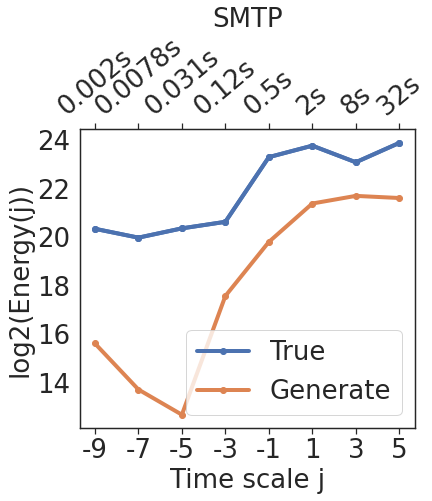

In [59]:
sns.set_style("white")

#fig, ax1 = plt.subplots(
#        1, 1, figsize=(10, 7))
fig, ax1 = plt.subplots(
        1, 1, figsize=(6, 5.5))
    
#err_true = [low_yerror_true, high_yerror_true]
#err_pred = [low_yerror_pred, high_yerror_pred]
    
ax1.errorbar(df_plot[df_plot['type'] == 'True']['x'].values.astype(int).astype(str), 
             df_plot[df_plot['type'] == 'True']["values"].values,
             linewidth=LINEWIDTH,
             fmt='o-') #, yerr=err_true)
ax1.errorbar(df_plot[df_plot['type'] == 'Generate']['x'].values.astype(int).astype(str), 
             df_plot[df_plot['type'] == 'Generate']["values"].values,
             linewidth=LINEWIDTH,
             fmt="o-") #, yerr=err_pred)
ax1.legend(['True', 'Generate'], fontsize=LEGEND_FONTSIZE)
#ax1.tick_params(labelsize=TICK_FONTSIZE)

#ax1.set_xticks(df_plot[df_plot['type'] == 'True']["x"].values)
ax1.set_xticklabels(df_plot[df_plot['type'] == 'True']["x"].values.astype(int), 
                    fontsize=LABEL_FONTSIZE, rotation=0)

for item in ax1.get_yticklabels():
    item.set_fontsize(LABEL_FONTSIZE)
    #item.set_rotation(40)

ax2 = ax1.twiny()
ax2.tick_params(labelsize=TICK_FONTSIZE)
#ax2.errorbar(["488mus", "0.002s", "0.0078s", 
#           "0.031s", "0.12s", "0.5s", "2s",
#           "8s", "32s", "128s", "512s"], 
#            df_plot[df_plot['type'] == 'True']["values"].values,
#            fmt="o-", yerr=err_true)
ax2.errorbar(["0.002s", "0.0078s", "0.031s", "0.12s", "0.5s", "2s",
             "8s", "32s"], #, "128", "512"], 
            df_plot[df_plot['type'] == 'True']["values"].values,
            fmt="o-", #yerr=err_true,
            linewidth=LINEWIDTH)
#ax2.set_xticklabels(["0.002s", "0.0078s", 
#                     "0.031s", "0.12s", "0.5s", "2s",
#                     "8s", "32s"], fontsize=LABEL_FONTSIZE)
for item in ax2.get_xticklabels():
    item.set_fontsize(LABEL_FONTSIZE)
    item.set_rotation(40)
#ax2.tick_params(axis='x', labelsize=TICK_FONTSIZE, rotation=40)
ax2.grid(False)

#labels = ax2.get_xticklabels()
#ax2.set_xticklabels(labels, rotation=360)

ax1.set_ylabel(f"log2(Energy(j))", fontsize=LABEL_FONTSIZE)
ax1.set_xlabel(f"Time scale j", fontsize=LABEL_FONTSIZE)
ax1.set_title(f"{app}", fontsize=TITLE_FONTSIZE)
#ax1.set_ylim([15, 34])

if (app == "LORA_1"):
    #x1.set_title("Test", fontsize=TITLE_FONTSIZE)
    ax1.set_title(f"LORA (fport: 1)", fontsize=TITLE_FONTSIZE)
if (app == "LORA_10"):
    #x1.set_title("Test", fontsize=TITLE_FONTSIZE)
    ax1.set_title(f"LORA (fport: 10)", fontsize=TITLE_FONTSIZE)
if (app == "UDP_GOOGLE_HOME"):
    #x1.set_title("Test", fontsize=TITLE_FONTSIZE)
    ax1.set_title(f"Google Home (UDP)", fontsize=TITLE_FONTSIZE)
if (app == "TCP_GOOGLE_HOME"):
    #x1.set_title("Test", fontsize=TITLE_FONTSIZE)
    ax1.set_title(f"Google Home (TCP)", fontsize=TITLE_FONTSIZE)

### 4.4 Compute timeseries graph

In [22]:
def get_df_plot(df_plot, time_range='1s', byte_mode=True):
    
    # Si on analyse les paquets
    if(byte_mode):
        df_plot_rolling = df_plot.rolling(time_range).sum().rename(
            columns={'length_total' : 'rate'})
        df_plot = df_plot.resample(time_range).sum().rename(
            columns={'length_total' : 'rate'})
    else:
        df_plot_rolling = df_plot.rolling(time_range).count().rename(
            columns={'length_total' : 'rate'})
        df_plot = df_plot.resample(time_range).count().rename(
            columns={'length_total' : 'rate'})
        
    return df_plot_rolling, df_plot

In [23]:
LABEL_FONTSIZE = 26
TICK_FONTSIZE = 26
TITLE_FONTSIZE = 26
LEGEND_FONTSIZE = 26

YLIM = [0, 1.1]

COEFF = 0.05 # To increase upper limit

LINEWIDTH = 4
sns.set_style("white")

In [545]:
#df_gen = df_gen_update.rename(columns={'time_lstm':'timesteps_lstm',
#                                'length_total_lstm': 'length_total'})

In [24]:
df_plot_true = df_true.copy() #.iloc[3500:10000].copy()
df_plot_gen = df_gen.rename(columns={'timesteps_lstm':'timestamps',
                                     'length_total_lstm': 'length_total'}).copy()


time_range = '1s'

df_plot_true['timestamps'] -= df_plot_true['timestamps'].min()
df_plot_true['datetime'] = df_plot_true['timestamps'].map(map_time)
#df_plot_true['datetime'] = df_plot_true['datetime'].dt.strftime('%M:%S.%f')
#df_plot_true['datetime'] = df_plot_true['datetime'].map(lambda x : x.replace(hour=0))
df_plot_true = df_plot_true.set_index('datetime').sort_index()
df_plot_true = df_plot_true[['timestamps', 'length_total']]

df_plot_gen['timestamps'] -= df_plot_gen['timestamps'].min()
df_plot_gen['datetime'] = df_plot_gen['timestamps'].map(map_time)
#df_plot_gen['datetime'] = df_plot_gen['datetime'].dt.strftime('%M:%S.%f')
#df_plot_gen['datetime'] = df_plot_gen['datetime'].map(lambda x : x.replace(hour=0))
df_plot_gen = df_plot_gen.set_index('datetime').sort_index()
df_plot_gen = df_plot_gen[['timestamps', 'length_total']]

df_plot_rolling_true, df_plot_true = get_df_plot(
    df_plot_true, time_range=time_range, byte_mode=False)
df_plot_rolling_gen, df_plot_gen = get_df_plot(
    df_plot_gen, time_range=time_range, byte_mode=False)

In [25]:
LABEL_FONTSIZE = 24
TICK_FONTSIZE = 24
TITLE_FONTSIZE = 24
LEGEND_FONTSIZE = 24

YLIM = [0, 1.1]

COEFF = 0.05 # To increase upper limit

LINEWIDTH = 3
sns.set_style("white")

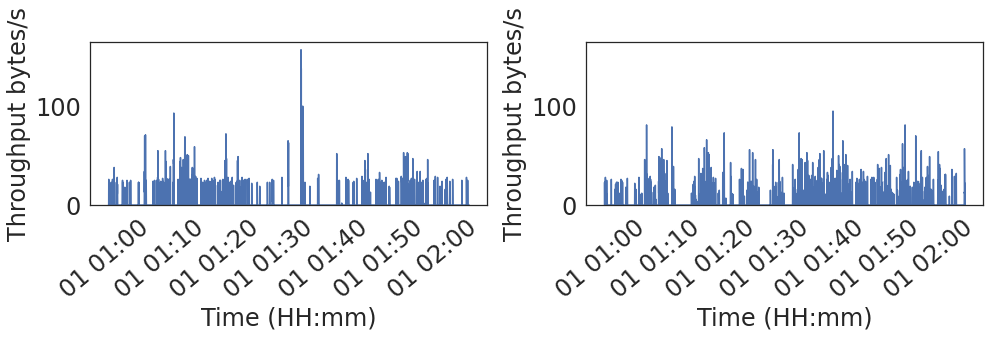

In [31]:
fig, axes = plt.subplots(
    1, 2, figsize=(16, 3))
#fig.tight_layout(rect=[0, 0, 1, 0.9])
fig.subplots_adjust(wspace=0.25, hspace=0.5)
#(left, bottom, right, top), default: (0, 0, 1, 1)
#fig.suptitle(title)

# Set start and end time
#start_time = '0:00'
#end_time = '23:00'
#df_plot_true_tmp = df_plot_true.between_time(
#    start_time, end_time)
#df_plot_gen_tmp = df_plot_gen.between_time(
#    start_time, end_time)

# Set start and end range
start_range = 40
end_range = 4000
df_plot_true_tmp = df_plot_true.iloc[
    start_range:end_range]
df_plot_gen_tmp = df_plot_gen.iloc[
    start_range:end_range]
#df_plot_true_tmp = df_plot_true.copy()
#df_plot_gen_tmp = df_plot_gen.copy()


axes[0].plot(df_plot_true_tmp['rate'].index.values, 
             df_plot_true_tmp['rate'].values)
axes[1].plot(df_plot_gen_tmp['rate'].index.values, 
             df_plot_gen_tmp['rate'].values)

for ax in axes.ravel():
    ax.set_ylabel(f"Throughput bytes/s", 
                  fontsize=LABEL_FONTSIZE)
    ax.tick_params(labelsize=TICK_FONTSIZE)
    #ax.set_xlabel(f"Time ({time_range})")
    ax.set_xlabel(f"Time (HH:mm)", 
                  fontsize=LABEL_FONTSIZE)

max_val = max([val.max() for val in [df_plot_gen_tmp['rate'].values, 
                                     df_plot_true_tmp['rate'].values]])
for ax in axes.ravel():
    ax.set_ylim([0, max_val + max_val*COEFF])
    #labels = ax.get_xticklabels()
    #ax.set_xticklabels(labels, rotation=80)
    ax.tick_params(axis='x', labelsize=TICK_FONTSIZE, rotation=40)
    #ax.xtick_params(rotation=40)
    #ax.set_ylim([0, 5000])

### 4.6 Compute flags

#### 4.6 Compute static flags

(0.0, 1.0)

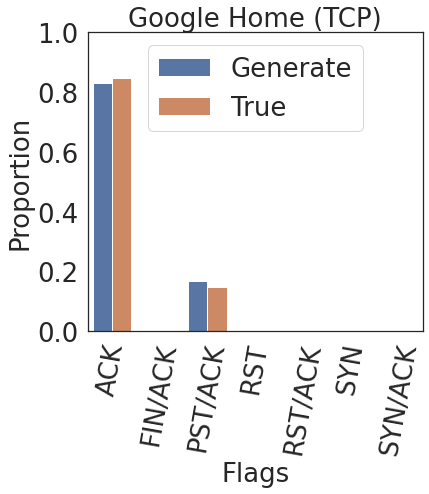

In [104]:
# Functions set flags
def set_flags_name(x):
    if(x == 0):
        return "OTHERS"
    else:
        return "/".join(functions.get_label_flags(
        value=int(x)))
    
fig, ax = plt.subplots(
        1, 1, figsize=(6, 5.5))

# Transform value ton SYN/SYN/ACK ...etc

df_plot_true = pd.DataFrame(df_true['flags'].map(
                lambda x : set_flags_name(x)))
df_plot_true['Dataset'] = 'True'

df_plot_gen = pd.DataFrame(df_gen['flags'].map(
                lambda x : set_flags_name(x)))
df_plot_gen['Dataset'] = 'Generate'

df_plot = pd.concat(
    [df_plot_true, df_plot_gen], axis=0)

# EXTRACT CI

values = df_plot_true['flags'].value_counts().values
ci_pred = functions.get_cis(df_plot_true['flags'], alpha=0.95, 
                  normalize=True, return_stats=False)
error_bar_true = [ci_pred[k][1]-ci_pred[k][0] for k in ci_pred.keys()]

values = df_plot_gen['flags'].value_counts().values
ci_pred = functions.get_cis(df_plot_gen['flags'], alpha=0.95, 
                  normalize=True, return_stats=False)
error_bar_gen = [ci_pred[k][1]-ci_pred[k][0] for k in ci_pred.keys()]

# From = https://stackoverflow.com/questions/34615854/seaborn-countplot-with-normalized-y-axis-per-group
#                     .mul(100)

df_plot_tmp = (df_plot.groupby(['Dataset'])['flags']
                     .value_counts(normalize=True)
                     .rename('Proportion')
                     .reset_index()
                     .sort_values('flags'))

# np.array([0.1, 0.2]*7).reshape((2, -1))
sns.barplot(x="flags", 
            y="Proportion", 
            hue="Dataset", 
            data=df_plot_tmp,
            #yerr=error_bar_gen
           ) #, ci=.95)

ax.set_ylabel(f"Proportion", fontsize=LABEL_FONTSIZE)
ax.set_xlabel(f"Flags", fontsize=LABEL_FONTSIZE)
#ax.set_title(f"{app}", fontsize=TITLE_FONTSIZE)
ax.set_title(f"Google Home (TCP)", fontsize=TITLE_FONTSIZE)

labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=80)
ax.tick_params(labelsize=TICK_FONTSIZE)
ax.legend(fontsize=LEGEND_FONTSIZE)
ax.set_ylim([0, 1.0]) #YLIM[-1]
#ax.legend(['True', 'Generate'], fontsize=LEGEND_FONTSIZE)

#### 4.6 Compute sequence flags

In [ ]:
# SYN-SYN/ACK-ACK
# FIN-ACK / ACK / FIN-ACK / ACK

##### 4.6.1 FIN-ACK / ACK / FIN-ACK / ACK

In [345]:
df_true_update.shape

(437221, 42)

In [346]:
df_gen_update.shape

(40000, 14)

In [347]:
# Functions set flags
def set_flags_name(x):
    if(x == 0):
        return "OTHERS"
    else:
        return "/".join(functions.get_label_flags(
        value=int(x)))

# Transform value ton SYN/SYN/ACK ...etc

df_flags_true = pd.DataFrame(df_true_update.iloc[0:40_000]['flags'].map(
                lambda x : set_flags_name(x)))

df_flags_gen = pd.DataFrame(df_gen_update['flags'].map(
                lambda x : set_flags_name(x)))

In [354]:
look_back = 3
look_ahead = 1

start_idx = 0

seq_flags_true = np.empty(
    (0, look_back, 1))
seq_flags_gen = np.empty(
    (0, look_back, 1))

for i in tqdm(range(0, look_back)):
    
    # Extract sequence block
    seq_flags_true_tmp = functions.create_windows(
        df_flags_true[start_idx:].values, 
        window_shape=look_back, 
        end_id=-look_ahead)
    seq_flags_gen_tmp = functions.create_windows(
        df_flags_gen[start_idx:].values, 
        window_shape=look_back, 
        end_id=-look_ahead)
    
    # Extract sequence block
    seq_flags_true = np.concatenate(
        (seq_flags_true, 
         seq_flags_true_tmp), axis=0)
    seq_flags_gen = np.concatenate(
        (seq_flags_gen, 
         seq_flags_gen_tmp), axis=0)
    
    start_idx += 1
    
# Extract combinaison

comb_flags_true = [
    '-'.join(row.ravel()) for row in tqdm(seq_flags_true)]
comb_flags_gen = [
    '-'.join(row.ravel()) for row in tqdm(seq_flags_gen)]

# Extract unique combinaison

values_true, counts_true = np.unique(
    comb_flags_true, return_counts=True)
counts_true_ind = np.argsort(-counts_true)
#values_true = values_true[counts_true_ind]

values_gen, counts_gen = np.unique(
    comb_flags_gen, return_counts=True)
counts_gen_ind = np.argsort(-counts_gen)


# Extract count fin ack

index_gen_fin_ack = np.where(
    values_gen == 'FIN/ACK-ACK-FIN/ACK-ACK')[0]
counts_gen_fin_ack = counts_gen[index_gen_fin_ack]

index_true_fin_ack = np.where(
    values_true == 'FIN/ACK-ACK-FIN/ACK-ACK')[0]
counts_true_fin_ack = counts_true[index_true_fin_ack]

100%|██████████| 119988/119988 [00:00<00:00, 753018.18it/s]


In [356]:
df_plot = pd.DataFrame()

# For ordering
#values_true[counts_true_ind][0:10]
#counts_true[counts_true_ind][0:10]

flags = []
counts = []
datasets = []

dict_gen_flags = {}

# Extract dict for generation
for i in range(
    counts_gen_ind.size):
    
    dict_gen_flags[
        values_gen[i]] = counts_gen[i] / counts_gen.sum()

# TRUE
for i in range(15):

    flags.append(values_true[
        counts_true_ind][i])

    datasets.append("True")

    counts.append(counts_true[
        counts_true_ind][i] / counts_true.sum())

# GENERATE
for i in range(15):
    
    flags.append(flags[i])

    datasets.append("Generate")

    counts.append(dict_gen_flags[
        flags[i]])
        
df_plot['flags'] = flags
df_plot['count'] = counts
df_plot['Dataset'] = datasets

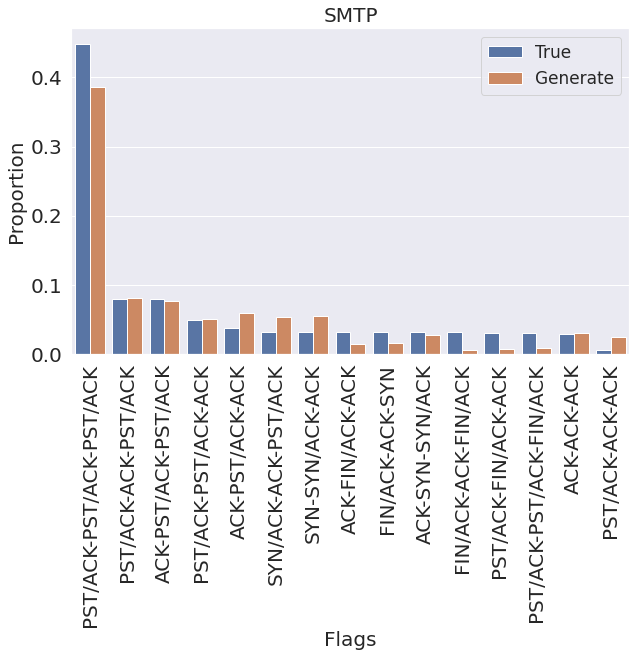

In [350]:
fig, ax = plt.subplots(
        1, 1, figsize=(10, 6))
sns.barplot(x="flags", 
            y="count", 
            hue="Dataset", 
            data=df_plot,
            #yerr=error_bar_gen
           ) #, ci=.95)

ax.set_ylabel(f"Proportion", fontsize=LABEL_FONTSIZE)
ax.set_xlabel(f"Flags", fontsize=LABEL_FONTSIZE)
ax.set_title(f"{app}", fontsize=TITLE_FONTSIZE)

labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.tick_params(labelsize=TICK_FONTSIZE)
ax.legend(fontsize=LEGEND_FONTSIZE)

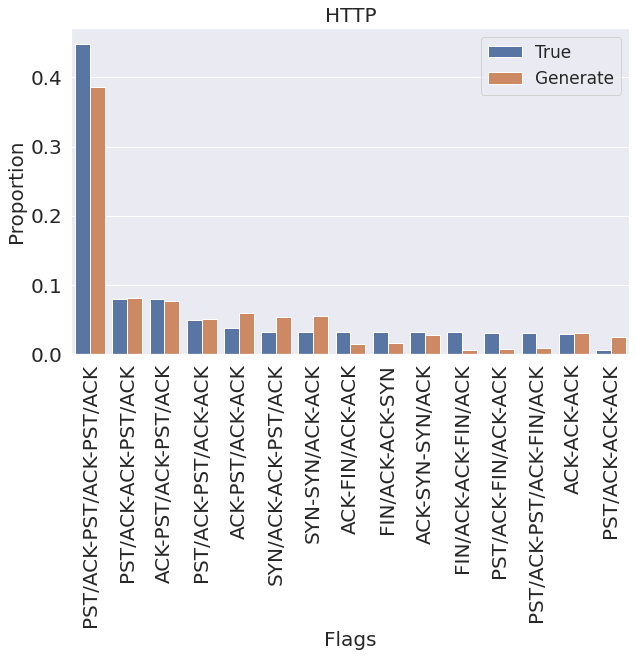

In [357]:
fig, ax = plt.subplots(
        1, 1, figsize=(10, 6))
sns.barplot(x="flags", 
            y="count", 
            hue="Dataset", 
            data=df_plot,
            #yerr=error_bar_gen
           ) #, ci=.95)

ax.set_ylabel(f"Proportion", fontsize=LABEL_FONTSIZE)
ax.set_xlabel(f"Flags", fontsize=LABEL_FONTSIZE)
ax.set_title(f"{app}", fontsize=TITLE_FONTSIZE)

labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.tick_params(labelsize=TICK_FONTSIZE)
ax.legend(fontsize=LEGEND_FONTSIZE)

In [739]:
look_back = 3
look_ahead = 1

start_idx = 0

seq_flags_true = np.empty(
    (0, look_back, 1))
seq_flags_gen = np.empty(
    (0, look_back, 1))

for i in tqdm(range(0, look_back)):
    
    # Extract sequence block
    seq_flags_true_tmp = functions.create_windows(
        df_flags_true[start_idx:].values, 
        window_shape=look_back, 
        end_id=-look_ahead)
    seq_flags_gen_tmp = functions.create_windows(
        df_flags_gen[start_idx:].values, 
        window_shape=look_back, 
        end_id=-look_ahead)
    
    # Extract sequence block
    seq_flags_true = np.concatenate(
        (seq_flags_true, 
         seq_flags_true_tmp), axis=0)
    seq_flags_gen = np.concatenate(
        (seq_flags_gen, 
         seq_flags_gen_tmp), axis=0)
    
    start_idx += 1
    
# Extract combinaison

comb_flags_true = [
    '-'.join(row.ravel()) for row in tqdm(seq_flags_true)]
comb_flags_gen = [
    '-'.join(row.ravel()) for row in tqdm(seq_flags_gen)]

# Extract unique combinaison

values_true, counts_true = np.unique(
    comb_flags_true, return_counts=True)
values_gen, counts_gen = np.unique(
    comb_flags_gen, return_counts=True)

# Extract count fin ack

index_gen_syn_ack = np.where(
    values_gen == 'SYN-SYN/ACK-ACK')[0]
counts_gen_syn_ack = counts_gen[index_gen_fin_ack]

index_true_syn_ack = np.where(
    values_true == 'SYN-SYN/ACK-ACK')[0]
counts_true_syn_ack = counts_true[index_true_fin_ack]

100%|██████████| 119988/119988 [00:00<00:00, 749711.22it/s]


In [742]:
df_plot = pd.DataFrame()

df_plot['flags'] = ["SYN-SYN/ACK-ACK", "SYN-SYN/ACK-ACK"] + \
                   ['FIN/ACK-ACK-FIN/ACK-ACK', "FIN/ACK-ACK-FIN/ACK-ACK"]
df_plot['count'] = [counts_true_syn_ack.item()/df_true_update.shape[0], 
                    counts_gen_syn_ack.item()/df_gen_update.shape[0]] + \
                   [counts_true_fin_ack.item()/df_true_update.shape[0], 
                    counts_gen_fin_ack.item()/df_gen_update.shape[0]]
df_plot['Dataset'] = ["True", "Generate"] + ["True", "Generate"]

fig, ax = plt.subplots(
        1, 1, figsize=(7, 6))
sns.barplot(x="flags", 
            y="count", 
            hue="Dataset", 
            data=df_plot,
            #yerr=error_bar_gen
           ) #, ci=.95)

ax.set_ylabel(f"Proportion", fontsize=LABEL_FONTSIZE)
ax.set_xlabel(f"Flags", fontsize=LABEL_FONTSIZE)
ax.set_title(f"{app}", fontsize=TITLE_FONTSIZE)

labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=20)
ax.tick_params(labelsize=TICK_FONTSIZE)
ax.legend(fontsize=LEGEND_FONTSIZE)

,flags,count,Dataset
0,SYN-SYN/ACK-ACK,0.000045,True
1,SYN-SYN/ACK-ACK,0.006900,Generate
2,FIN/ACK-ACK-FIN/ACK-ACK,0.191853,True
3,FIN/ACK-ACK-FIN/ACK-ACK,0.060500,Generate


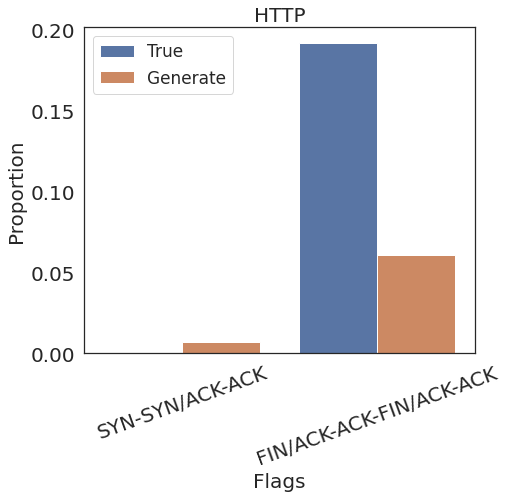

In [741]:
df_plot = pd.DataFrame()

df_plot['flags'] = ["SYN-SYN/ACK-ACK", "SYN-SYN/ACK-ACK"] + \
                   ['FIN/ACK-ACK-FIN/ACK-ACK', "FIN/ACK-ACK-FIN/ACK-ACK"]
df_plot['count'] = [counts_true_syn_ack.item()/df_true_update.shape[0], 
                    counts_gen_syn_ack.item()/df_gen_update.shape[0]] + \
                   [counts_true_fin_ack.item()/df_true_update.shape[0], 
                    counts_gen_fin_ack.item()/df_gen_update.shape[0]]
df_plot['Dataset'] = ["True", "Generate"] + ["True", "Generate"]

fig, ax = plt.subplots(
        1, 1, figsize=(7, 6))
sns.barplot(x="flags", 
            y="count", 
            hue="Dataset", 
            data=df_plot,
            #yerr=error_bar_gen
           ) #, ci=.95)

ax.set_ylabel(f"Proportion", fontsize=LABEL_FONTSIZE)
ax.set_xlabel(f"Flags", fontsize=LABEL_FONTSIZE)
ax.set_title(f"{app}", fontsize=TITLE_FONTSIZE)

labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=20)
ax.tick_params(labelsize=TICK_FONTSIZE)
ax.legend(fontsize=LEGEND_FONTSIZE)

### 4.5 Compute distance between two distribution

In [114]:
def getFactors(n):
    # Create an empty list for factors
    factors=[];

    # Loop over all factors
    for i in range(2, n + 1):
        if n % i == 0:
            factors.append(i)

    # Return the list of factors
    return factors

In [127]:
num_sample = min(
    df_true.shape[0], df_gen.shape[0]) 

In [128]:
df_gen_tmp = df_gen.sample(
    n=num_sample, replace=False)
df_gen_tmp = df_gen_tmp.sort_values(
    by='timesteps_lstm')
df_gen_tmp.iloc[0]['time_diff_lstm'] = 0
df_gen_tmp.iloc[0]['timesteps_lstm'] = 0
df_gen_tmp['timesteps'] = df_gen_tmp['time_diff_lstm'].cumsum()
df_gen_tmp['timesteps_lstm'] = df_gen_tmp['timesteps']

In [129]:
df_true_tmp = df_true.sample(
    n=num_sample, replace=False)
df_true_tmp = df_true_tmp.sort_values(
    by='timesteps')
df_true_tmp.iloc[0]['time_diff'] = 0
df_true_tmp.iloc[0]['timesteps'] = 0
df_true_tmp['timesteps'] = df_true_tmp['time_diff'].cumsum()

In [118]:
# Time diff
vector_a = df_true.sample(
    n=num_sample, replace=False)['time_diff']
vector_b = df_gen.sample(
    n=num_sample, replace=False)['time_diff_lstm']

In [130]:
# Flows/s 
## EXTRACT GEN RATE
df_gen_rate = df_gen_tmp[['timesteps', 'count_total']].copy()
df_gen_rate['datetime'] = df_gen_rate['timesteps'].map(map_time)
df_gen_rate = df_gen_rate.set_index('datetime').sort_index()
gen_rate = df_gen_rate['count_total'].resample(
                '1s').count().values

## EXTRACT TRUE RATE
df_true_rate = df_true[['timesteps', 'flow_id_count']].copy()
df_true_rate['datetime'] = df_true_rate['timesteps'].map(map_time)
df_true_rate = df_true_rate.set_index('datetime').sort_index()
true_rate = df_true_rate['flow_id_count'].resample(
                '1s').count().values

vector_a = gen_rate[:min(gen_rate.size, true_rate.size)]
vector_b = true_rate[:min(gen_rate.size, true_rate.size)]

In [124]:
# Packets/s
## EXTRACT GEN RATE
df_gen_rate = df_gen_tmp[['timesteps', 'count_total']].copy()
df_gen_rate['datetime'] = df_gen_rate['timesteps'].map(map_time)
df_gen_rate = df_gen_rate.set_index('datetime').sort_index()
gen_rate = df_gen_rate['count_total'].resample(
                '1s').sum().values

## EXTRACT TRUE RATE
df_true_rate = df_true[['timesteps', 'flow_id_count']].copy()
df_true_rate['datetime'] = df_true_rate['timesteps'].map(map_time)
df_true_rate = df_true_rate.set_index('datetime').sort_index()
true_rate = df_true_rate['flow_id_count'].resample(
                '1s').sum().values

vector_a = gen_rate[:min(gen_rate.size, true_rate.size)]
vector_b = true_rate[:min(gen_rate.size, true_rate.size)]

In [192]:
if (vector_a.size > vector_b.size):
    vector_a = np.random.choice(
        vector_a , vector_b.size)
else:
    vector_b = np.random.choice(
        vector_b , vector_a.size)

In [26]:
#np.log10(df_true['time_diff'].iloc[1:]).hist(bins=100)

In [27]:
#np.log10(df_gen['time_diff_lstm'].iloc[1:]).hist(bins=100)

In [28]:
#plt.plot(vector_a[:-1])

In [29]:
#plt.plot(vector_b)

In [119]:
vector_a = np.sort(vector_a)
vector_a_norm = vector_a / np.linalg.norm(vector_a)

vector_b = np.sort(vector_b)
vector_b_norm = vector_b / np.linalg.norm(vector_b)

In [132]:
# Pourcentage of conrrespondance
np.dot(vector_a_norm, 
       vector_b_norm, 
       out = None)

0.9684385804708975

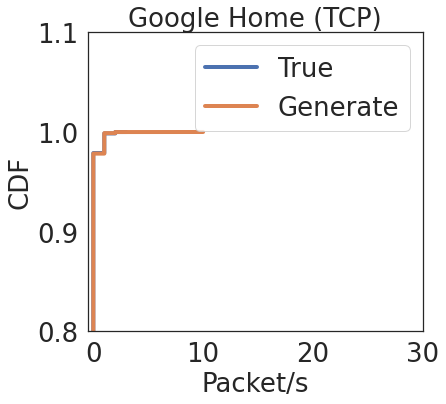

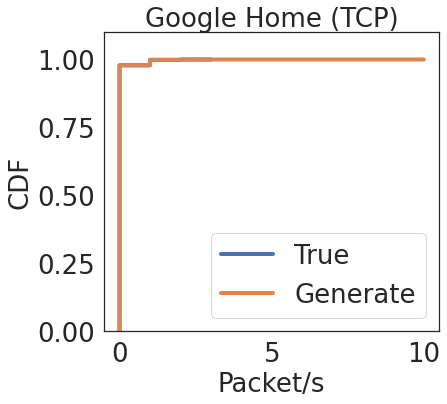

In [131]:
# PLOT DATA

for i in range(2):
    
    fig, ax = plt.subplots(
        1, 1, figsize=(6, 5.5))

    # True
    g_true = sns.ecdfplot(x=vector_a, 
                          ax=ax, 
                          linewidth=LINEWIDTH,
                          palette="tab10")

    # Generate
    g_gen = sns.ecdfplot(x=vector_b, 
                         ax=ax, 
                         linewidth=LINEWIDTH,
                         palette="tab10")

    ax.set_xlabel("Packet/s", fontsize=LABEL_FONTSIZE)
    #ax.set_xlabel("Flows/s", fontsize=LABEL_FONTSIZE)
    #ax.set_xlabel("IFT (in seconds)", fontsize=LABEL_FONTSIZE)
    ax.set_ylabel("CDF", fontsize=LABEL_FONTSIZE)
    ax.tick_params(
        labelsize=TICK_FONTSIZE)
    ax.legend(['True', 'Generate'], fontsize=LEGEND_FONTSIZE) #, loc="upper left")
    ax.set_ylim([0, YLIM[-1]])
    #ax.set_title(f"{app}", fontsize=TITLE_FONTSIZE)
    #ax.set_title(f"Google Home (UDP)", fontsize=TITLE_FONTSIZE)
    ax.set_title(f"Google Home (TCP)", fontsize=TITLE_FONTSIZE)
    
    # Rétrécissement que pour la version ZOOME !
    if (i == 0):
        
        if (app == "LORA_1"):
            ax.set_title(f"LORA (fport: 1)", fontsize=TITLE_FONTSIZE)
        elif (app == "LORA_10"):
            ax.set_title(f"LORA (fport : 10)", fontsize=TITLE_FONTSIZE)
        elif (app == "TCP_GOOGLE_HOME"):
            ax.set_xlim([-0.5, 30])
            ax.set_ylim([0.8, 1.1])
            ax.set_title(f"Google Home (TCP)", fontsize=TITLE_FONTSIZE)
        elif (app == "UDP_GOOGLE_HOME"):
            #ax.set_xlim([-3, 300])
            #ax.set_xlim([-0.5, 8])
            ax.set_xlim([-0.5, 30])
            ax.set_ylim([0.75, 1.1])
            ax.set_title(f"Google Home (UDP)", fontsize=TITLE_FONTSIZE)
        elif (app == "SNMP"):
            #ax.set_xlim([120, 200])
            ax.set_title(f"{app}", fontsize=TITLE_FONTSIZE)
        elif (app == "HTTP"):
            ax.set_ylim([0.75, 1.1])
            ax.set_xlim([-3, 40])
            ax.set_title(f"{app}", fontsize=TITLE_FONTSIZE)
        elif (app == "SMTP"):
            ax.set_ylim([0.75, 1.1])
            ax.set_xlim([-10, 200])
            ax.set_title(f"{app}", fontsize=TITLE_FONTSIZE)
        else:
            ax.set_title(f"{app}", fontsize=TITLE_FONTSIZE)

In [ ]:
df_true.head()

In [106]:
df_true.head()

,flow_id_count,length_total_sum,length_total_std,timestamps_min,header_length_std,payload_length_std,time_diff,rate,rolling_rate_byte_sec,rolling_rate_byte_min,rolling_rate_packet_sec,rolling_rate_packet_min,timesteps
0,49,5812,178.915229,9.202932e+08,1.106567,179.027814,0.000000,0.000000,5812.0,5812.0,1.0,1.0,0.000000
1,24,3136,210.164877,9.202932e+08,1.129319,210.284831,0.551357,10541.263963,3136.0,8948.0,1.0,2.0,0.551357
2,49,6330,206.005428,9.202932e+08,1.106567,206.120313,0.826938,3792.302410,6330.0,15278.0,1.0,3.0,1.378295
3,49,4880,125.501148,9.202932e+08,1.106567,125.611135,0.774907,8168.726027,11210.0,20158.0,2.0,4.0,2.153202
4,148,66369,617.628053,9.202932e+08,0.650851,617.696846,3.156147,1546.189070,66369.0,86527.0,1.0,5.0,5.309349


### Processing flow information !

In [ ]:
def set_flow(data):
    columns = ['ip_src', 'ip_dst', 'sport', 'dport']

    df_test = data.copy()

    sessions = df_test.groupby( #[condition]
        columns).size().reset_index().rename(
        columns={0:'count'})

    for i in tqdm(range(sessions.shape[0])): #result.shape[0]
        '''condition_flow = (((df_test['ip_src'] == sessions['ip_src'].iloc[i]) &
                         (df_test['ip_dst'] == sessions['ip_dst'].iloc[i]) &
                         (df_test['sport'] == sessions['sport'].iloc[i]) &
                         (df_test['dport'] == sessions['dport'].iloc[i]) &
                         (df_test['applications'] == sessions['applications'].iloc[i])) |
                        ((df_test['ip_src'] == sessions['ip_dst'].iloc[i]) &
                         (df_test['ip_dst'] == sessions['ip_src'].iloc[i]) &
                         (df_test['sport'] == sessions['dport'].iloc[i]) &
                         (df_test['dport'] == sessions['sport'].iloc[i]) &
                         (df_test['applications'] == sessions['applications'].iloc[i])))'''
        
        condition_flow = (((df_test['ip_src'] == sessions['ip_src'].iloc[i]) &
                         (df_test['ip_dst'] == sessions['ip_dst'].iloc[i]) &
                         (df_test['sport'] == sessions['sport'].iloc[i]) &
                         (df_test['dport'] == sessions['dport'].iloc[i])) |
                        ((df_test['ip_src'] == sessions['ip_dst'].iloc[i]) &
                         (df_test['ip_dst'] == sessions['ip_src'].iloc[i]) &
                         (df_test['sport'] == sessions['dport'].iloc[i]) &
                         (df_test['dport'] == sessions['sport'].iloc[i])))
        
        # Add flow id
        df_test.loc[condition_flow, "flow_id"] = i

    #flows = df_test[
    #    'flow_id'].value_counts().sort_index().index.values

    return df_test

In [ ]:
# On met la direction en identifiant à partir du client !

In [ ]:
app = 'UDP_GOOGLE_HOME'
df_true = pd.read_csv(f"DATA/PROCESS/df_raw_{app}.csv")

In [ ]:
app = "HTTP"
data_raw = pd.read_csv(f"DATA/PROCESS/df_raw_flows_{app}.csv")
data = pd.read_csv(f"DATA/PROCESS/df_process_flows_{app}.csv")

In [ ]:
# FLOW RE ORDERING


condition_application = (data_raw['applications'] == PROTO)
df_raw = data_raw[
    condition_application].reset_index(drop=True).copy()

# Extraction d'un dictonnaire avec flux -> taille
df_new = df_raw[['flow_id', 'timestamps']].groupby(
                ['flow_id']).min().rename(columns={'timestamps': 'flow_id_count'})

# Utilisation de map function pour flux -> taille
dict_map = df_new.to_dict()['flow_id_count']
df_raw['flow_count'] = df_raw['flow_id'].map(dict_map)

# Utilisation de map function pour timestamps + nombre de jour qui correpsond à l'ID
df_min = df_raw[['flow_id', 'timestamps']].groupby(
    ['flow_id']).min().rename(columns={'timestamps': 'min'})
df_min['pad'] = df_min.index.values*100000
    #'min'].map(lambda x : np.random.randint(0, 5000, size=(1,))[0])
dict_pad = df_min.to_dict()['pad']

def some_func(a, b):
    #print(dict_pad[a])
    return b+dict_pad[a]

df_raw['timestamps_update'] = df_raw[['flow_id', 'timestamps']].apply(
    lambda x: some_func(a=x['flow_id'], b=x['timestamps']), axis=1)

# On sort en fonction de la timestamps (les flux sont autamiquement groupe)
df_raw = df_raw.sort_values(by=['timestamps_update'], ascending=True)
indexes_update = df_raw.index.values

# J'applique l'insertion pour récuperer les index proprement
# Mettre les la numerotation des index
df_raw = df_raw.reset_index(drop=True)
arr_update = arr[indexes_update]

## On extrait les index max de chaque flux (voir index result)
indexes = df_raw.duplicated(subset=['flow_id'], keep='first')
index_val = df_raw.index[~indexes].values
index_min = index_val.copy()

## On créer les index min de chaque flux (voir index result) ET on fait la diff
indexes = df_raw.duplicated(subset=['flow_id'], keep='last')
index_val = df_raw.index[~indexes].values
index_max = index_val.copy()

## On attribue les index_min et les index_max
df_new = df_raw[['flow_id']].drop_duplicates(subset=['flow_id'], keep='first')
df_new['index_min'] = index_min
df_new['index_max'] = index_max
df_new = df_new.set_index('flow_id')

dict_index_min = df_new[["index_min"]].to_dict()['index_min']
dict_index_max = df_new[["index_max"]].to_dict()['index_max']
df_raw['index_min'] = df_raw['flow_id'].map(dict_index_min)
df_raw['index_max'] = df_raw['flow_id'].map(dict_index_max)

In [ ]:
# IDNETIFICATION FOR FIRST AND LAST PART


indexes_flow = df_raw[['index_min', 'index_max']] \
                .drop_duplicates(subset=['index_min', 'index_max'],
                                 keep='first') \
                .reset_index(drop=True)
indexes_flow['quantity'] = indexes_flow['index_max'] - \
            indexes_flow['index_min']

# Extract the different index of flow
# The first and last four
for i in range(LIMIT_FLOW_PART):
    df_raw[f"index_min_{i}"] = df_raw['index_min']+i - df_raw.index.values
    indexes_flow[f"index_min_{i}"] = indexes_flow['index_min']+i

    df_raw[f"index_max_{i}"] = df_raw['index_max']-i - df_raw.index.values
    indexes_flow[f"index_max_{i}"] = indexes_flow['index_max']-i

In [ ]:
decoder = tf.keras.models.load_model(f"{MODELS_DIR}decoder_vae_{TIME_LENGTH}_T{TIMESTEPS}_{PROTO}_FINAL.h5",
                                  custom_objects={"LeakyReLU": tf.keras.layers.LeakyReLU})
vae = VAE(encoder, decoder)



# PREDICT MODEL



z_mean, z_log_var = vae.encoder.predict(data.iloc[
    indexes_update][columns].values)
Z_sampling = Sampling()([z_mean, z_log_var]).numpy()



# CONCAT DATA



cols = [f"columns_{i}" for i in range(Z_sampling.shape[-1])]
df_sampling = pd.DataFrame()

for i, col in enumerate(cols):
    df_sampling[col] = Z_sampling[:, i]
    #df_sampling[col] = z_mean[:, i]
df_concat = pd.concat([df_raw, df_sampling], axis=1)
# Pour obtenir le rank au sein du flow
df_concat['flow_index'] = df_concat.index.values - \
        df_concat['index_min']


In [ ]:
# For each flow id we set to zero (first index)
cond_first = (df_concat['index_min_0'] == 0)
df_concat.loc[cond_first, 'time_diff'] = 0

# Compute time diff for each flow and set Nan to 0
df_concat['time_diff'] = df_concat['timestamps'].diff(1)
df_concat.loc[cond_first, 'time_diff'] = 0


# ECHANTILLONNAGE des clusters

In [ ]:
# Extraire la direction a partir des ports
# 1 si dport c'est 80
if (PROTO == "HTTP"):
    cond = (data_raw['sport'] == 80)
    data["direction"] = 0
    data.loc[cond, "direction"] = 1
elif (PROTO == "SNMP"):
    cond = (data_raw['sport'] == 161)
    data["direction"] = 0
    data.loc[cond, "direction"] = 1
elif (PROTO == "SMTP"):
    cond = ((data_raw['sport'] == 25) | (data_raw['sport'] == 587))
    data["direction"] = 0
    data.loc[cond, "direction"] = 1
else:
    df_flow_first = data_raw.groupby(
        "flow_id").first()

    # By default direction is 0
    data["direction"] = 0

    for i in tqdm(range(df_flow_first.shape[0])):
        ip_src = df_flow_first.iloc[i]['ip_src']
        ip_dst = df_flow_first.iloc[i]['ip_dst']
        sport = df_flow_first.iloc[i]['sport']
        dport = df_flow_first.iloc[i]['dport']

        cond = ((data_raw['ip_src'] == ip_dst) &
                (data_raw['ip_dst'] == ip_src) &
                (data_raw['sport'] == dport) &
                (data_raw['dport'] == sport))

        data.loc[cond, "direction"] = 1

In [ ]:
df_flow_first = df_true.groupby(
    "flow_id").first()

#cond = (data_raw['sport'] == 80)
#data["direction"] = 0
#data.loc[cond, "direction"] = 1

# By default direction is 0
df_true["direction"] = 0

for i in tqdm(range(df_flow_first.shape[0])):
    ip_src = df_flow_first.iloc[i]['ip_src']
    ip_dst = df_flow_first.iloc[i]['ip_dst']
    sport = df_flow_first.iloc[i]['sport']
    dport = df_flow_first.iloc[i]['dport']
    
    cond = ((df_true['ip_src'] == ip_dst) &
             (df_true['ip_dst'] == ip_src) &
             (df_true['sport'] == dport) &
             (df_true['dport'] == sport)) 
    
    df_true.loc[cond, "direction"] = 1

In [ ]:
# Reordering data to get same structure as df_concat
data = data.iloc[
     indexes.ravel()].reset_index(drop=True)

# For each flow id we set to zero (first index)
cond_first = (df_concat['index_min_0'] == 0)
df_concat.loc[cond_first, 'time_diff'] = 0

# Compute time diff for each flow and set Nan to 0
df_concat['time_diff'] = df_concat['timestamps'].diff(1)
df_concat.loc[cond_first, 'time_diff'] = 0


# Compute log               
df_concat['time_diff'] = np.log10(
        df_concat['time_diff'].values)

inf_val = data['time_diff'].mean()

df_concat.replace( # Imputation par la moyenne
        -np.inf, inf_val, inplace=True)

df_concat = df_concat.fillna(0)

# Normalize
df_concat['time_diff'] = standardize(
                   df_concat['time_diff'], min_x=df_concat['time_diff'].min(),
                   max_x=df_concat['time_diff'].max(), a=0, b=1)

# Set values to	data
data['time_diff'] = df_concat['time_diff'].values


In [ ]:
#df_true['layers_6'].value_counts()

In [ ]:
app = 'UDP_GOOGLE_HOME'
df_true = pd.read_csv(f"DATA/PROCESS/df_raw_{app}.csv")
df_results = set_flow(df_true) #.value_counts()

In [ ]:
app = 'SNMP'
df_true = pd.read_csv(f"DATA/PROCESS/df_raw_{app}.csv")

In [ ]:
df_true['flow_id'].value_counts()

In [ ]:
#df_results.to_csv(f"DATA/PROCESS/df_raw_{app}.csv", index=False)

### 4.3 Packet based analysis

#### 4.3.1 RATE

In [ ]:
def plot_cdf(dfs, col, titles, 
             figsize=(6, 5), hue=None, 
             xlims=None):
    fig, axes = plt.subplots(
        1, len(dfs), figsize=figsize)
    #fig.tight_layout(rect=[0, 0, 1, 0.9])
    fig.subplots_adjust(wspace=0.25, hspace=0)
    #(left, bottom, right, top), default: (0, 0, 1, 1)
    #fig.suptitle(title)
    
    if(len(dfs) > 1):
        axes_ravel = axes.ravel()
    else:
        axes_ravel = [axes]
        
    for df, ax, title, xlim in zip(
        dfs, axes_ravel, titles, xlims):
        sns.ecdfplot(
            data=df, x=col, ax=ax, hue=hue, palette="tab10")
        #ax.set_xlabel(f"{col}")
        ax.set_title(title) 
        if (xlim[0] is not None):
            ax.set_xlim(xlim)
    
# https://stackoverflow.com/questions/6677332/using-f-with-strftime-in-python-to-get-microseconds
def map_time(timestamp):
    local_time = time.localtime(timestamp)
    mlsec = repr(timestamp).split('.')[1][:6]
    return pd.Timestamp(pd.to_datetime(
                        time.strftime("%Y%d%m %H:%M:%S.{}".format(mlsec), local_time), 
                        format='%Y%d%m %H:%M:%S.%f'))

In [ ]:
data_true = pd.read_csv(f"./DATA/GOOGLE_HOME/media_pcap_anonymized/df_media_pcap_anonymized.csv")

In [ ]:
data_true = pd.read_csv(f"./DATA/GOOGLE_HOME/media_pcap_anonymized/df_media_pcap_anonymized.csv")

In [ ]:
cond_filename = (data_true['filename'] == 'media_692_pcap_anonymize.pcap')
df_results = data_true[cond_filename].sort_values(by='timestamps')

In [ ]:
df_results[df_results['layers_2'] == 'UDP']['layers_4'].val

In [ ]:
df_results[df_results['layers_2'] == 'TCP']['ip_dst'].value_counts()

In [ ]:
df_results[df_results['layers_2'] == 'UDP']['ip_dst'].value_counts()

In [ ]:
data_true['filename'].value_counts().shape

In [ ]:
df_results['layers_2'].map({"TCP":0, "UDP":1}).plot()

In [ ]:
data_gen = pd.read_csv(f"./RESULTS/DF_GEN_FLOWS_UDP_GOOGLE_HOME_FINAL_4.csv")
data_true = pd.read_csv(f"./RESULTS/DF_TRUE_FLOWS_UDP_GOOGLE_HOME_FINAL.csv")
data_true['applications'] = "UDP_GOOGLE_HOME"
data_true = data_true.iloc[0:data_gen.shape[0]]

In [ ]:
# UDP GOOGLE HOME !

In [ ]:
num_sample = 1000
col = 'count'

hue_val = ['UDP_GOOGLE_HOME']
titles = []
for val in hue_val:
    titles.append(
        f"Pack. len. dist. for {val}")

columns = [col, 'Data']
df_plot_all = []

for val in hue_val:
    
    titles = [f"Flow pack. count dist. {val}",
              f"Flow byte count dist. {val}"]
    
    df_plot_true = data_true[
        data_true['applications'] == val]#.iloc[36228:46228]#.sample(num_sample)#[['timestamps', 'length_total']]
    df_plot_gen = data_gen[
        data_gen['applications'] == val]#.sample(num_sample)
    
    df_plot_true['Data'] = "True"
    df_plot_gen['Data'] = "Generate"

    df_plot_true_packet = df_plot_true[['flow_id', 'length_total', 'applications', 'Data']].groupby( #[condition]
                    ['flow_id', 'applications', 'Data']).size().reset_index().rename(
                    columns={0:'count'}) # 'Packet'
    df_plot_true_byte = df_plot_true[['flow_id', 'length_total', 'applications', 'Data']].groupby( #[condition]
                    ['flow_id', 'applications', 'Data']).sum().reset_index().rename(
                    columns={'length_total':'count'}) # 'Bytes'

    df_plot_gen_packet = df_plot_gen[['flow_id', 'length_total', 'applications', 'Data']].groupby( #[condition]
                    ['flow_id', 'applications', 'Data']).size().reset_index().rename(
                    columns={0:'count'})
    df_plot_gen_byte = df_plot_gen[['flow_id', 'length_total', 'applications', 'Data']].groupby( #[condition]
                    ['flow_id', 'applications', 'Data']).sum().reset_index().rename(
                    columns={'length_total':'count'}) # 'Bytes'
    
    df_plot_all_packet = pd.concat([df_plot_true_packet[columns], 
                                    df_plot_gen_packet[columns]])
    
    df_plot_all_byte = pd.concat([df_plot_true_byte[columns], 
                                 df_plot_gen_byte[columns]])
    
    plot_cdf(dfs=[df_plot_all_packet, df_plot_all_byte], 
             col=col, hue='Data', 
             titles=titles, figsize=(12, 4),
             xlims=[[-5, 100], [-5000, 60000]]) # [[-5, 100], [-5000, 60000]]

In [ ]:
num_sample = 1000
col = 'count'

hue_val = ['HTTP']
titles = []
for val in hue_val:
    titles.append(
        f"Pack. len. dist. for {val}")

columns = [col, 'type']
df_plot_all = []

for val in hue_val:
    
    titles = [f"Flow pack. count dist. {val}",
              f"Flow byte count dist. {val}"]
    
    df_plot_true = data_true[
        data_true['applications'] == val].iloc[36228:46228]#.sample(num_sample)#[['timestamps', 'length_total']]
    df_plot_gen = data_gen[
        data_gen['applications'] == val].sample(num_sample)
    
    df_plot_true['type'] = "True"
    df_plot_gen['type'] = "Generate"

    df_plot_true_packet = df_plot_true[['flow_id', 'length_total', 'applications', 'type']].groupby( #[condition]
                    ['flow_id', 'applications', 'type']).size().reset_index().rename(
                    columns={0:'count'})
    df_plot_true_byte = df_plot_true[['flow_id', 'length_total', 'applications', 'type']].groupby( #[condition]
                    ['flow_id', 'applications', 'type']).sum().reset_index().rename(
                    columns={'length_total':'count'})

    df_plot_gen_packet = df_plot_gen[['flow_id', 'length_total', 'applications', 'type']].groupby( #[condition]
                    ['flow_id', 'applications', 'type']).size().reset_index().rename(
                    columns={0:'count'})
    df_plot_gen_byte = df_plot_gen[['flow_id', 'length_total', 'applications', 'type']].groupby( #[condition]
                    ['flow_id', 'applications', 'type']).sum().reset_index().rename(
                    columns={'length_total':'count'})
    
    df_plot_all_packet = pd.concat([df_plot_true_packet[columns], 
                                    df_plot_gen_packet[columns]])
    
    df_plot_all_byte = pd.concat([df_plot_true_byte[columns], 
                                 df_plot_gen_byte[columns]])
    
    plot_cdf(dfs=[df_plot_all_packet, df_plot_all_byte], 
             col=col, hue='type', 
             titles=titles, figsize=(12, 4))

In [ ]:
num_sample = 100000
col = 'count'

hue_val = ['TELNET']
titles = []
for val in hue_val:
    titles.append(
        f"Pack. len. dist. for {val}")

columns = [col, 'type']
df_plot_all = []

for val in hue_val:
    
    titles = [f"Flow pack. count dist. {val}",
              f"Flow byte count dist. {val}"]
    
    df_plot_true = data_true[
        data_true['applications'] == val].iloc[425900:435900]#.sample(num_sample)#[['timestamps', 'length_total']]
    df_plot_gen = data_gen[
        data_gen['applications'] == val]#.sample(num_sample)
    
    df_plot_true['type'] = "True"
    df_plot_gen['type'] = "Generate"

    df_plot_true_packet = df_plot_true[['flow_id', 'length_total', 'applications', 'type']].groupby( #[condition]
                    ['flow_id', 'applications', 'type']).size().reset_index().rename(
                    columns={0:'count'})
    df_plot_true_byte = df_plot_true[['flow_id', 'length_total', 'applications', 'type']].groupby( #[condition]
                    ['flow_id', 'applications', 'type']).sum().reset_index().rename(
                    columns={'length_total':'count'})

    df_plot_gen_packet = df_plot_gen[['flow_id', 'length_total', 'applications', 'type']].groupby( #[condition]
                    ['flow_id', 'applications', 'type']).size().reset_index().rename(
                    columns={0:'count'})
    df_plot_gen_byte = df_plot_gen[['flow_id', 'length_total', 'applications', 'type']].groupby( #[condition]
                    ['flow_id', 'applications', 'type']).sum().reset_index().rename(
                    columns={'length_total':'count'})
    
    df_plot_all_packet = pd.concat([df_plot_true_packet[columns], 
                                    df_plot_gen_packet[columns]])
    
    df_plot_all_byte = pd.concat([df_plot_true_byte[columns], 
                                 df_plot_gen_byte[columns]])
    
    plot_cdf(dfs=[df_plot_all_packet, df_plot_all_byte], 
             col=col, hue='type', 
             titles=titles, figsize=(12, 4))

In [ ]:
num_sample = 100000
col = 'count'

hue_val = ['SSH']
titles = []
for val in hue_val:
    titles.append(
        f"Pack. len. dist. for {val}")

columns = [col, 'type']
df_plot_all = []

for val in hue_val:
    
    titles = [f"Flow pack. count dist. {val}",
              f"Flow byte count dist. {val}"]
    
    df_plot_true = data_true[
        data_true['applications'] == val].iloc[42643:52643]#.sample(num_sample)#[['timestamps', 'length_total']]
    df_plot_gen = data_gen[
        data_gen['applications'] == val]#.sample(num_sample)
    
    df_plot_true['type'] = "True"
    df_plot_gen['type'] = "Generate"

    df_plot_true_packet = df_plot_true[['flow_id', 'length_total', 'applications', 'type']].groupby( #[condition]
                    ['flow_id', 'applications', 'type']).size().reset_index().rename(
                    columns={0:'count'})
    df_plot_true_byte = df_plot_true[['flow_id', 'length_total', 'applications', 'type']].groupby( #[condition]
                    ['flow_id', 'applications', 'type']).sum().reset_index().rename(
                    columns={'length_total':'count'})

    df_plot_gen_packet = df_plot_gen[['flow_id', 'length_total', 'applications', 'type']].groupby( #[condition]
                    ['flow_id', 'applications', 'type']).size().reset_index().rename(
                    columns={0:'count'})
    df_plot_gen_byte = df_plot_gen[['flow_id', 'length_total', 'applications', 'type']].groupby( #[condition]
                    ['flow_id', 'applications', 'type']).sum().reset_index().rename(
                    columns={'length_total':'count'})
    
    df_plot_all_packet = pd.concat([df_plot_true_packet[columns], 
                                    df_plot_gen_packet[columns]])
    
    df_plot_all_byte = pd.concat([df_plot_true_byte[columns], 
                                 df_plot_gen_byte[columns]])
    
    plot_cdf(dfs=[df_plot_all_packet, df_plot_all_byte], 
             col=col, hue='type', 
             titles=titles, figsize=(12, 4))

In [ ]:
num_sample = 100000
col = 'count'

hue_val = ['SMTP']
titles = []
for val in hue_val:
    titles.append(
        f"Pack. len. dist. for {val}")

columns = [col, 'type']
df_plot_all = []

for val in hue_val:
    
    titles = [f"Flow pack. count dist. {val}",
              f"Flow byte count dist. {val}"]
    
    df_plot_true = data_true[
        data_true['applications'] == val].iloc[26947:36947]#.sample(num_sample)#[['timestamps', 'length_total']]
    df_plot_gen = data_gen[
        data_gen['applications'] == val]#.sample(num_sample)
    
    df_plot_true['type'] = "True"
    df_plot_gen['type'] = "Generate"

    df_plot_true_packet = df_plot_true[['flow_id', 'length_total', 'applications', 'type']].groupby( #[condition]
                    ['flow_id', 'applications', 'type']).size().reset_index().rename(
                    columns={0:'count'})
    df_plot_true_byte = df_plot_true[['flow_id', 'length_total', 'applications', 'type']].groupby( #[condition]
                    ['flow_id', 'applications', 'type']).sum().reset_index().rename(
                    columns={'length_total':'count'})

    df_plot_gen_packet = df_plot_gen[['flow_id', 'length_total', 'applications', 'type']].groupby( #[condition]
                    ['flow_id', 'applications', 'type']).size().reset_index().rename(
                    columns={0:'count'})
    df_plot_gen_byte = df_plot_gen[['flow_id', 'length_total', 'applications', 'type']].groupby( #[condition]
                    ['flow_id', 'applications', 'type']).sum().reset_index().rename(
                    columns={'length_total':'count'})
    
    df_plot_all_packet = pd.concat([df_plot_true_packet[columns], 
                                    df_plot_gen_packet[columns]])
    
    df_plot_all_byte = pd.concat([df_plot_true_byte[columns], 
                                 df_plot_gen_byte[columns]])
    
    plot_cdf(dfs=[df_plot_all_packet, df_plot_all_byte], 
             col=col, hue='type', 
             titles=titles, figsize=(12, 4))

In [ ]:
num_sample = 100000
col = 'count'

hue_val = ['SNMP']
titles = []
for val in hue_val:
    titles.append(
        f"Pack. len. dist. for {val}")

columns = [col, 'type']
df_plot_all = []

for val in hue_val:
    
    titles = [f"Flow pack. count dist. {val}",
              f"Flow byte count dist. {val}"]
    
    df_plot_true = data_true[
        data_true['applications'] == val].iloc[15220:25220]#.sample(num_sample)#[['timestamps', 'length_total']]
    df_plot_gen = data_gen[
        data_gen['applications'] == val]#.sample(num_sample)
    
    df_plot_true['type'] = "True"
    df_plot_gen['type'] = "Generate"

    df_plot_true_packet = df_plot_true[['flow_id', 'length_total', 'applications', 'type']].groupby( #[condition]
                    ['flow_id', 'applications', 'type']).size().reset_index().rename(
                    columns={0:'count'})
    df_plot_true_byte = df_plot_true[['flow_id', 'length_total', 'applications', 'type']].groupby( #[condition]
                    ['flow_id', 'applications', 'type']).sum().reset_index().rename(
                    columns={'length_total':'count'})

    df_plot_gen_packet = df_plot_gen[['flow_id', 'length_total', 'applications', 'type']].groupby( #[condition]
                    ['flow_id', 'applications', 'type']).size().reset_index().rename(
                    columns={0:'count'})
    df_plot_gen_byte = df_plot_gen[['flow_id', 'length_total', 'applications', 'type']].groupby( #[condition]
                    ['flow_id', 'applications', 'type']).sum().reset_index().rename(
                    columns={'length_total':'count'})
    
    df_plot_all_packet = pd.concat([df_plot_true_packet[columns], 
                                    df_plot_gen_packet[columns]])
    
    df_plot_all_byte = pd.concat([df_plot_true_byte[columns], 
                                 df_plot_gen_byte[columns]])
    
    plot_cdf(dfs=[df_plot_all_packet, df_plot_all_byte], 
             col=col, hue='type', 
             titles=titles, figsize=(12, 4))

In [ ]:
# Debit en fonction du temps pour tous les traffics + par appli (les plus majoritaire et après les OTHERS !)
# Generation en volume d'applications (bareplot + interval de confiance)
# Generation en nombre d'applications (bareplot)
# Generation en nombre de flux en fonction du temps (lineplot)

### 4.5 Scaling analysis

In [ ]:
def generate_index(data, num=10):
    df = data.copy()
    index = df.index.values
    for i in [2**i for i in range(0, num)]:
        index_new = np.repeat(index[:int(index.shape[0]/i)+10], i)
        #print("i : ", i)
        #print("index_new : ", index_new)
        #print("data.shape[0] : ", data.shape[0])
        df[f'index_{i}'] = index_new[0:data.shape[0]]
    return df

In [ ]:
def extract_rate(data, app):
    cond = ((data['time_diff'] != 0) &
            (data['applications'] == app))
    min_diff = int(data[cond]['time_diff'].min() * (1e6))
    
    data_filter = data[cond].sort_index()#.reset_index(drop=True)
    
    rate = data_filter['length_total'].resample(
                 f'{min_diff}ms').sum().values
    df_rate = pd.DataFrame()
    df_rate['rate'] = rate
    return df_rate

In [ ]:
data_rate_true = pd.read_csv(f"./RESULTS/DF_TRUE_TIMESTAMPS_{app}_FINAL_SHORT.csv")
data_rate_gen = pd.read_csv(
    f"./RESULTS/DF_GEN_TIMESTAMPS_{app}_FINAL_SHORT.csv")

In [ ]:
data_rate_gen = pd.read_csv(
    f"./RESULTS/DF_GEN_TIMESTAMPS_{app}_FINAL_2_SHORT.csv")

In [ ]:
data_rate_gen.iloc[400000:500000].plot()

In [ ]:
data_rate_gen.iloc[400000:500000].plot()

In [ ]:
num_sample = 200
col = 'length_total'
app = 'UDP_GOOGLE_HOME'

# N0_DF_GEN_PCAP_MONDAY_BL100_T11_S251009_E351009_LORA_1_LORA_1_FINAL_2.csv
# N0_DF_GEN_PCAP_MONDAY_BL100_T11_S58405_E408405_LORA_1_LORA_1_FINAL.csv

columns = ['values', 'type']
df_plot_all = []

#data_rate_true = pd.read_csv(f"./RESULTS/DF_TRUE_TIMESTAMPS_{app}_FINAL_SHORT.csv")
data_rate_true = pd.read_csv(f"./RESULTS/DF_TRUE_TIMESTAMPS_{app}_FINAL.csv")
data_rate_true = data_rate_true.iloc[0:600000]
#data_rate_true = pd.read_csv(f"./RESULTS/DF_TRUE_TIMESTAMPS_{app}_FINAL_week1_monday.tcpdump.csv")
#data_rate_true = pd.DataFrame()
#for week in ["week1", "week3"]:
#    for day in ["monday", 'tuesday', 'wednesday', 
#                'thursday', 'friday']:
#        try:
#            data_rate_true_tmp = pd.read_csv(
#                f"./RESULTS/DF_TRUE_TIMESTAMPS_{app}_FINAL_{week}_{day}.tcpdump.csv")
#            data_rate_true = pd.concat([data_rate_true, data_rate_true_tmp], axis=0)
#        except:
#            pass
        
#data_rate_true = data_rate_true.reset_index(drop=True)
        
        
#data_rate_true = pd.read_csv(f"{RESULTS_DIR}df_week1_monday_TIMESTAMPS_{app}.csv")
#data_rate_true = data_rate_true.iloc[
#    20000:100000].reset_index(drop=True)
#data_rate_true = data_true_date[['length_total']].resample(
#    f'488us').sum().rename({'length_total' : "rate"})
data_rate_true = generate_index(
    data=data_rate_true, num=11).rename({'length_total' : "rate"}) # 11


#data_rate_gen = pd.read_csv(
#    f"./RESULTS/DF_GEN_TIMESTAMPS_{app}_FINAL_2_SHORT.csv")
data_rate_gen = pd.read_csv(
    f"./RESULTS/DF_GEN_TIMESTAMPS_{app}_FINAL.csv")
data_rate_gen = data_rate_gen.iloc[0:600000]
#data_rate_gen = pd.read_csv(f"{RESULTS_DIR}DF_ALL_FLOWS_4_TIMESTAMPS_{app}.csv")
#data_rate_gen = data_rate_gen.iloc[
#    20000:100000].reset_index(drop=True)
#data_rate_gen = data_gen_date[['length_total']].resample(
#    f'488us').sum().rename({'length_total' : "rate"})
data_rate_gen = generate_index(
    data=data_rate_gen, num=11).rename({'length_total' : "rate"})

df_plot_full = pd.DataFrame(columns=['type', 'x', 'values']) # , 'applications'

df_plot = pd.DataFrame(
    columns=['type', 'x', 'values', 'applications'])

In [ ]:
data_rate_gen['length_total'] = data_rate_gen['total_length']

In [ ]:
data_rate_gen.shape

In [ ]:
data_rate_true.shape

In [ ]:
data_rate_gen = data_rate_gen[]
data_rate_true = data_rate_true[]

In [ ]:
df_plot = pd.DataFrame()

#np.percentile(dict_val["0"][dict_val["0"] != 0], 2.5)
dict_val = {}
range_k = [488e-6, 0.002, 0.0078, 0.031, 
           0.12, 0.5, 2, 8, 32, 128, 512]
range_i = [2**i for i in range(0, 11)]
keys = [str(i) for i in range(len(range_i))]
#for k in keys:
#    dict_val[k] = []

for df, t in zip([data_rate_true, data_rate_gen], 
                 ["True", "Generate"]):

    df_plot_tmp = pd.DataFrame()
    values = []
    x_values = []
    
    #range_k = range_k[:7]
    #range_i = range_i[:7]

    for k, i, key in zip(range_k,
                        range_i,
                        keys):

        rate = df[['length_total', f"index_{i}"]].groupby(
            f"index_{i}").sum().values

        cA, cD = pywt.dwt(
            rate, mode='constant', wavelet=f'db1') # wavedec with , level=1, , mode='constant'
        
        low_error = np.percentile(cA, 2.5)
        high_error = np.percentile(cA, 97.5)
        
        print("t ; np.std(cA) : ", t, ' ; ', np.std(cA))
        print("percentile error min; max : ", 
              low_error, ' ; ', high_error)
        
        dict_val[f"{key}_{t}"] = cA
        
        #dict_val[key].append(low_error)
        #dict_val[key].append(high_error)
        
        values.append(np.log2(np.std(cA)))
        x_values.append(np.ceil(np.log2(k)))
        if(x_values[-1] == -8):
            x_values[-1] = -9.0

    df_plot_tmp['values'] = values
    df_plot_tmp['x'] = x_values
    df_plot_tmp['type'] = t

    df_plot = pd.concat([df_plot, 
                         df_plot_tmp])  

df_plot = df_plot.reset_index(drop=True)

In [ ]:
df_plot

In [ ]:
df_plot.to_csv("save_google_home.csv", index=False)

In [ ]:
def get_cis(data, alpha=0.95, 
            normalize=False, 
            return_stats=False,
            n_iterations=1000):
    
    stats = {}
    cis = {}
    keys = data.columns.values
    for k in keys:
        #stats[k] = [0]*n_iterations
        cis[k] = [0, 0]
        
    for i in range(n_iterations):
        data_sample = data.sample(frac=0.65, replace=True)
        data_counts = data_sample.shape[0] #.values.reshape(1, -1)
        for k in data_sample.columns:
            #stats[k][i] = data_counts[k].values
            stats[k] = np.log2(
                data_sample[k].values.std())
        
    # confidence intervals
    for k in keys:
        p = ((1.0-alpha)/2.0)# * 100
        lower = np.percentile(stats[k], p)
        p = (alpha+((1.0-alpha)/2.0))# * 100
        upper = np.percentile(stats[k], p)
        cis[k] = [lower, upper]
    
    if(return_stats):
        return cis, stats
    else:
        return cis

In [ ]:
dict_cis = {}

low_yerror_true = [] #[f"{key}_{t}"]
high_yerror_true = []

low_yerror_pred = [] #[f"{key}_{t}"]
high_yerror_pred = []

for k in tqdm(dict_val.keys()):
    df_tmp = pd.DataFrame()
    df_tmp[k] = dict_val[k].ravel()#[dict_val[k] != 0].ravel()
    result = get_cis(data=df_tmp[[k]].iloc[0:500000], 
                     alpha=0.95, 
                     normalize=False, 
                     #return_stats=False,
                     n_iterations=1000)
    key = list(result.keys())[0]
    
    low = result[key][0]
    high = result[key][-1]
    
    if ("True" in k):
        cond = (df_plot['type'] == 'True')
        idx = int(key.split('_')[0])
        
        ref = df_plot[
            cond].reset_index(drop=True).iloc[idx]['values']
        
        low = np.abs(low - ref)
        high = np.abs(high - ref)
        
        low_yerror_true.append(low)
        high_yerror_true.append(high)
    else:
        cond = (df_plot['type'] == 'Generate')
        idx = int(key.split('_')[0])
        
        ref = df_plot[
            cond].reset_index(drop=True).iloc[idx]['values']
        
        low = np.abs(low - ref)
        high = np.abs(high - ref)
        
        low_yerror_pred.append(low)
        high_yerror_pred.append(high)
    #dict_cis[key] = result[key]

In [ ]:
fig, ax1 = plt.subplots(
        1, 1, figsize=(9, 7))
       #1, 1, figsize=(7.9, 3)) 
    
#ax1.errobar(df_plot[df_plot['type'] == 'True']['x'].values, 
#         df_plot[df_plot['type'] == 'True']["values"].values,
#         fmt="o-",
#         yerr=yerror_true)
#ax1.errobar(df_plot[df_plot['type'] == 'Generate']['x'].values, 
#         df_plot[df_plot['type'] == 'Generate']["values"].values,
#         fmt="o-",
#         yerr=yerror_pred)
err_true = [low_yerror_true, high_yerror_true]
err_pred = [low_yerror_pred, high_yerror_pred]
    
ax1.errorbar(df_plot[df_plot['type'] == 'True']['x'].values, 
             df_plot[df_plot['type'] == 'True']["values"].values,
             #"o-",
             fmt='o-',
             yerr=err_true)
ax1.errorbar(df_plot[df_plot['type'] == 'Generate']['x'].values, 
         df_plot[df_plot['type'] == 'Generate']["values"].values,
         fmt="o-",
         yerr=err_pred)
ax1.legend(['True', 'Generate'])

ax1.set_xticks(df_plot[df_plot['type'] == 'True']["x"].values)
ax2 = ax1.twiny()
ax2.errorbar(["488mus", "0.002s", "0.0078s", 
           "0.031s", "0.12s", "0.5s", "2s",
           "8s", "32s", "128s", "512s"], 
         df_plot[df_plot['type'] == 'True']["values"].values,
         fmt="o-", 
         yerr=err_true)
ax2.grid(False)

#labels = ax2.get_xticklabels()
#ax2.set_xticklabels(labels, rotation=360)

ax1.set_ylabel(f"log2(Energy(j))")
ax1.set_xlabel(f"Time scale j")
ax1.set_title(f"{app}")

### 4.6 QoS/QoE analysis

In [ ]:
app = "HTTP"
data_gen = pd.read_csv(f"./RESULTS/DF_GEN_FLOWS_{app}_FINAL.csv")
data_true = pd.read_csv(f"./RESULTS/DF_TRUE_FLOWS_{app}_FINAL.csv")
data_true['applications'] = app
#data_true = data_true.iloc[0:data_gen.shape[0]]

In [ ]:
num_sample = 80000
titles = [f"RTT distribution per flow"]
col = 'count'
day = 'monday' # /!\ Ou remise a 0 du rate pour chaque jour !!!

index_start_true = np.random.randint(
    0, max(1, data_true[data_true['applications'] == app].shape[0]-num_sample), size=(1,))[0]
index_start_gen = np.random.randint(
    0, max(1, data_gen[data_gen['applications'] == app].shape[0]-num_sample), size=(1,))[0]

df_plot_true = data_true[data_true['applications'] == app].iloc[index_start_true:index_start_true+num_sample]
df_plot_gen = data_gen[data_gen['applications'] == app].iloc[index_start_gen:index_start_gen+num_sample]

flows_gen = df_plot_gen['flow_id'].value_counts().index.values
flows_true = df_plot_true['flow_id'].value_counts().index.values

# The result of extraction
data_result = pd.DataFrame(columns=['rtt', 'type'])

for df_plot, flows, data_type in zip([df_plot_true, df_plot_gen],
                                     [flows_true, flows_gen],
                                     ["True", "Gen"]):
    nb_flows = []
    rtt_values = []
    data_tmp = pd.DataFrame(columns=['rtt'])
    
    for flow_id in tqdm(flows):
        condition = (df_plot['flow_id'] == flow_id)
        flow = df_plot[condition]

        for i, f in enumerate(
            flow.index.values):

            # If two packets are consecutives
            condition_rtt = flow.iloc[
                i:i+2]['ip_src'].value_counts().shape[0]

            if(condition_rtt == 2):
                rtt_value = flow['timestamps'].iloc[i+1] - flow['timestamps'].iloc[i]
                rtt_values.append(rtt_value)

    data_tmp["rtt"] = rtt_values
    data_tmp["type"] = data_type
    data_tmp["type"]  = data_type
    
    data_result = pd.concat([data_result, data_tmp])
    

#plot_cdf(dfs=[df_plot], 
#         col="rtt", hue=None, 
#         titles=titles, figsize=(9, 7.5))

In [ ]:
def plot_cdf_tmp(dfs, col, titles, 
                 figsize=(6, 5), hue=None):
    fig, axes = plt.subplots(
        1, len(dfs), figsize=figsize)
    #fig.tight_layout(rect=[0, 0, 1, 0.9])
    fig.subplots_adjust(wspace=0.25, hspace=0)
    #(left, bottom, right, top), default: (0, 0, 1, 1)
    #fig.suptitle(title)
    
    if(len(dfs) > 1):
        axes_ravel = axes.ravel()
    else:
        axes_ravel = [axes]
        
    for df, ax, title in zip(
        dfs, axes_ravel, titles):
        sns.ecdfplot(
            data=df, x=col, ax=ax, hue=hue, palette="tab10")
        ax.set_xlabel(f"{col}")
        ax.set_title(title) 
        ax.set_xscale('log')
        #ax.set_xlim([-0.05, 0.1])
        #ax.set_ylim([0.9, 1.1])

In [ ]:
plot_cdf_tmp(dfs=[data_result], 
             col="rtt", hue='type', 
             titles=titles, figsize=(9, 7.5))

In [ ]:
plot_cdf_tmp(dfs=[data_result], 
             col="rtt", hue='type', 
             titles=titles, figsize=(9, 7.5))

In [ ]:
plot_cdf_tmp(dfs=[data_result], 
             col="rtt", hue='type', 
             titles=titles, figsize=(9, 7.5))

In [ ]:
# Voir la cohérence au niveau de la combinaison des en-têtes
# check_coherence TO DO !

### 4.7 Latent space VAE

In [ ]:
app = 'SMTP'
data_process = pd.read_csv(f"./DATA/PROCESS/df_week1_monday_process_{app}.csv")
arr = np.load(f"{MAIN_DIR}arr_week1_monday_bit.npy", mmap_mode='r')

In [ ]:
app = 'HTTP'
data_process = pd.read_csv(f"./DATA/PROCESS/df_process_{app}.csv")
data_raw = pd.read_csv(f"./DATA/PROCESS/df_raw_{app}.csv")
arr = np.load(f"./DATA/PROCESS/arr_process_{app}_bit.npy", mmap_mode='r')

In [ ]:
columns = ['layers_2', 'layers_3', 'layers_4', 'layers_5', 'flags', 'sport', 
           'dport', 'length_total', 'time_diff', 'rate', "rolling_rate_byte_sec", 'rolling_rate_byte_min',
            'rolling_rate_packet_sec', 'rolling_rate_packet_min', 'header_length', 'payload_length']

In [ ]:
columns = ['fport', 'mtype', 'code_rate', 'size', 'bandwidth',
           'spreading_factor', 'frequency', 'crc_status', 
           'length_total', 'time_diff', 'snr', 'rssi', 
            'rate', 'rolling_rate_byte_sec', 'rolling_rate_byte_min',
            'rolling_rate_packet_sec', 'rolling_rate_packet_min',
            'header_length', 'payload_length', 'fcnt']

In [ ]:
look_back = TIMESTEPS
look_ahead = TIMESTEPS # A AUGMENTER !

arr_mask = np.zeros(arr.shape, dtype=np.uint8)
for i in tqdm(range(arr_mask.shape[0])):
    header_length = int(data_true["header_length"].iloc[i] * 8)
    arr_mask[i, :header_length] = np.ones((1, header_length))

indexes = data_true[
    data_true['applications'] == 'HTTP'].index.values
arr_masked = arr[indexes] * arr_mask[indexes]
X = arr_masked[:, :58*8]#arr_masked[range_fit[0]:range_fit[1], :58*8]
X = np.concatenate((data_process[['time_diff', 'rate', "rolling_rate_byte_sec", 'rolling_rate_byte_min',
            'rolling_rate_packet_sec', 'rolling_rate_packet_min']].values, X), axis=-1)

X_seq = functions.create_windows(X, window_shape=look_back, end_id=-look_ahead)
#X_train_idx, X_val_idx, X_test_idx = functions.train_val_test_split( # functions.
#    X=X_seq, y=X_seq, train_size=0.85, random_state=42)
X_idx = np.arange(0, X_seq.shape[0])
X_train_idx, X_val_idx, _, _ = sklearn.model_selection.train_test_split(X_idx, X_idx,
                                random_state=42, test_size=0.1,
                                shuffle=True)

print(f"X shape : {X.shape}")
print(f"X_seq shape : {X_seq.shape}")

In [ ]:
%%time 
app = 'SMTP'
#data_process = pd.read_csv(f"./DATA/PROCESS/df_week1_monday_process_{app}.csv")
encoder = tf.keras.models.load_model(f"{MODELS_DIR}encoder_vae_{TIME_LENGTH}_T{TIMESTEPS}_{app}.h5", 
                                  custom_objects={"LeakyReLU": tf.keras.layers.LeakyReLU})
decoder = tf.keras.models.load_model(f"{MODELS_DIR}decoder_vae_{TIME_LENGTH}_T{TIMESTEPS}_{app}.h5", 
                                  custom_objects={"LeakyReLU": tf.keras.layers.LeakyReLU})
vae = VAE(encoder, decoder, gamma=1)

z_mean, z_log_var = vae.encoder.predict(data_process[columns].values)
Z_sampling = Sampling()([z_mean, z_log_var]).numpy()

In [ ]:
%%time 
app = 'HTTP'
#columns_update = columns + ['time_diff', 'rate', 'rolling_rate_byte_sec',
#                            'rolling_rate_byte_min', 'rolling_rate_packet_sec',
#                            'rolling_rate_packet_min']
encoder = tf.keras.models.load_model(f"{MODELS_DIR}encoder_vae_{TIME_LENGTH}_T{TIMESTEPS}_{app}_FINAL.h5", 
                                  custom_objects={"LeakyReLU": tf.keras.layers.LeakyReLU})
decoder = tf.keras.models.load_model(f"{MODELS_DIR}decoder_vae_{TIME_LENGTH}_T{TIMESTEPS}_{app}_FINAL.h5", 
                                  custom_objects={"LeakyReLU": tf.keras.layers.LeakyReLU})
vae = VAE(encoder, decoder, gamma=1)

z_mean, z_log_var = vae.encoder.predict(data_process[columns].values)
Z_sampling = Sampling()([z_mean, z_log_var]).numpy()

In [ ]:
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, framealpha=1, ncol=1, 
            bbox_to_anchor=(1.02,1), loc=2, fontsize=8, borderaxespad=0.)

for legend_handle in lgd.legendHandles:
    legend_handle.set_sizes([50])

In [ ]:
sns.set_style("whitegrid", {'axes.grid' : False})
#sns.set_style('white')

In [ ]:
%%time
#app = 'HTTP'
gmm = joblib.load(f"{MODELS_DIR}gmm_{FULL_NAME}_{app}_FINAL.sav")
seq_labels = gmm.predict(Z_sampling)

In [ ]:
from sklearn.cluster import KMeans, DBSCAN
from itertools import groupby
from sklearn.neighbors import KernelDensity

class Estimator():
    def __init__(self):
        pass
    
    ####################
    # GENERATOR FUNCTION
    ####################
    
    def get_joint_count(self, labels, forward_steps=3):
        dict_proba = defaultdict(list)
        unique_labels, _ = np.unique(
                labels, return_counts=True)

        mat_count = np.zeros(
            (len(unique_labels),)*forward_steps)

        # Add a values at the end and remove it
        labels = np.append(labels, 0)
        labels_windows = functions.create_windows(
            labels, window_shape=forward_steps, end_id=-1)
        labels = labels[0:-1]

        def my_func(a, unique_labels):
            idx = []
            for el in a:
                idx.append(np.where(el == unique_labels)[0])
            idx = np.array(idx).ravel()
            return idx

        index_labels = np.apply_along_axis(
            my_func, 1, labels_windows, unique_labels)

        # Prepare array for slicing
        index_slicing = []
        for step in range(index_labels.shape[1]):
            index_slicing.append(index_labels[:, step, 0])
        index_slicing = np.array(index_slicing)

        def my_func(a, mat_count):
            idx = a.reshape(
                a.shape[0], 1).tolist()
            mat_count[idx] = mat_count[idx] + 1

        np.apply_along_axis(
            my_func, 1, [index_slicing], mat_count)

        return mat_count
        
    def fit_generator(self, seq_labels, forward_steps=3):
        self.seq_labels = seq_labels
        self.joint_count = self.get_joint_count(
            labels=seq_labels, forward_steps=forward_steps)
        
    def predict_generator(self, length=10):
        timesteps = len(self.joint_count.shape)
        unique_labels, _ = np.unique(
                self.seq_labels, return_counts=True)
        sample_list = []
        sample_index = [] # get index of each element in array

        for i in range(length):
            try:
                idx = np.array(sample_index[-(timesteps-1):])
                idx = idx.reshape(idx.size, -1) # Reshape for index format
            except:
                idx = np.arange(0, self.joint_count.shape[0])

            count = self.joint_count[idx.tolist()]
            count = np.squeeze(count)

            # On somme les axes jusqu'a obtenir une ligne...
            if(len(count.shape) > 1):
                count = count.sum(
                    axis=tuple(i for i in range(len(count.shape)))[1:]) 

            proba = count / count.sum(axis=-1)
            sample = np.random.choice(
                    np.arange(0, self.joint_count.shape[0]), 1, p=proba)[0]
            sample_index.append(sample)
            sample_list.append(unique_labels[sample_index[-1]])

        return sample_list
    
       
    ####################
    # ANALYSIS FUNCTION
    ####################
    
    def plot_seq_labels(self, seq_pred, 
                         seq_true):
        seq_pred = np.array(seq_pred)
        seq_true = np.array(seq_true)
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        sns.lineplot(x=np.arange(0, seq_pred.size), y=seq_pred, ax=axes[0])
        sns.lineplot(x=np.arange(0, seq_pred.size), y=seq_true, ax=axes[1])
        
        axes[0].set_title("Generation")
        axes[0].set_ylim([0, seq_pred.max()])
        
        axes[1].set_title("Original")
        axes[1].set_ylim([0, seq_true.max()])
        
        
    def plot_seq_hist(self, seq_pred, 
                  seq_true):
        seq_pred = np.array(seq_pred)
        seq_true = np.array(seq_true)
        
        fig, axes = plt.subplots(1, 2, figsize=(13, 4))
        sns.histplot(
            data=seq_pred, stat="probability", ax=axes[0], bins=seq_true.max())
        sns.histplot(
            data=seq_true, stat="probability", ax=axes[1], bins=seq_true.max())
        
        axes[0].set_title("Generation")
        #axes[0].set_ylim([0, seq_pred.max()])
        
        axes[1].set_title("Original")
        #axes[1].set_ylim([0, seq_true.max()])
        
        
    def plot_seq_joint_proba(self):
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        sns.heatmap(np.around(self.joint_count, decimals=2), 
                    linewidths=.3, vmin=0, vmax=1, annot=True)
        
    def plot_joint_proba(self):
        # https://github.com/mGalarnyk/Python_Tutorials/blob/master/Request/Heat%20Maps%20using%20Matplotlib%20and%20Seaborn.ipynb
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        sns.heatmap(np.around(self.joint_count, decimals=2), 
                    linewidths=.3, vmin=0, vmax=1, annot=True)

In [ ]:
# GENRATION DE l'aggregation de "FLUX"
gen = Estimator()
seq_app_true = seq_labels[30000:31000]#(data['applications'].values*(len(APP_LIST)-1)).astype(int)[0:10000]

gen.fit_generator(seq_labels=seq_app_true, forward_steps=7)

seq_app_pred = gen.predict_generator(length=1000)
seq_app_pred = np.array(seq_app_pred)

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(5, 5))
#fig.tight_layout(rect=[0, 0, 1, 0.9])
fig.subplots_adjust(wspace=0.2, hspace=0.7)

axes[0].plot(seq_app_true[0:100])
#axes[0].set_title("TRUE")
axes[0].set_xlabel("Timesteps")
axes[0].set_ylabel("ID clusters")

axes[1].plot(seq_app_pred[0:100])
#axes[1].set_title("GENERATE")
axes[1].set_xlabel("Timesteps")
axes[1].set_ylabel("ID clusters")

In [ ]:
def plot_gmm(X, index, title, gmm, s=.8):
    means = gmm.means_
    covariances = gmm.covariances_
    Y_ = gmm.predict(X)

    color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    for i, (mean, covar) in enumerate(zip( #, color
            means, covariances)):#, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        ax.scatter(X[Y_ == i, 0], X[Y_ == i, 1], s=s)#, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle)#, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

    #ax.set_title(title)
    ax.set_xlabel("Latent variable 1")
    ax.set_ylabel("Latent variable 2")

In [ ]:
plot_gmm(X=Z_sampling, 
         index=0, #seq_labels,
         gmm=gmm, 
         title='test', s=20)

In [ ]:
plot_gmm(X=Z_sampling, 
         index=0, #seq_labels,
         gmm=gmm, 
         title='test', s=20)

In [ ]:
g = sns.displot(x=Z_sampling[:, 0], y=Z_sampling[:, 1], height=6, aspect=1)
#g.grid(False)
g.set(xlabel="Latent variable 1", 
      ylabel="Latent variable 2")
#lgd = ax.legend([ax], ['Packet'],
#          loc='upper left', 
#          frameon=True)
#ax.set_xlabel("Latent variable 1")
#ax.set_ylabel("Latent variable 2")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

#points = ax.hist2d(x=Z_sampling[:, 0], y=Z_sampling[:, 1], bins=200)#, cmap=plt.cm.BuGn_r)
        #.scatter(x=Z_sampling[:, 0], 
        #y=Z_sampling[:, 1],
        #s=20)
        
nbins = 20  
from scipy.stats import kde
k = kde.gaussian_kde(Z_sampling.T)
xi, yi = np.mgrid[Z_sampling[:, 0].min():Z_sampling[:, 0].max():nbins*1j, 
                  Z_sampling[:, 1].min():Z_sampling[:, 1].max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

points = ax.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud')

#.hist2d(x=Z_sampling[:, 0], y=Z_sampling[:, 1], bins=200)
ax.contour(xi, yi, zi.reshape(xi.shape))
#lgd = ax.legend([points], ['Packet'],
#          loc='upper left', 
#          frameon=True)
ax.set_xlabel("Latent variable 1")
ax.set_ylabel("Latent variable 2")

#handles, labels = ax.get_legend_handles_labels()
#lgd = ax.legend(handles, labels, framealpha=1, ncol=1, 
#            bbox_to_anchor=(1.02,1), loc=2, fontsize=8, borderaxespad=0.)

for legend_handle in lgd.legendHandles:
    legend_handle.set_sizes([20])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

points = ax.scatter(x=Z_sampling[:, 0], 
        y=Z_sampling[:, 1],
        s=20) 
lgd = ax.legend([points], ['Packet'],
          loc='upper left', 
          frameon=True)
ax.set_xlabel("Latent variable 1")
ax.set_ylabel("Latent variable 2")

#handles, labels = ax.get_legend_handles_labels()
#lgd = ax.legend(handles, labels, framealpha=1, ncol=1, 
#            bbox_to_anchor=(1.02,1), loc=2, fontsize=8, borderaxespad=0.)

for legend_handle in lgd.legendHandles:
    legend_handle.set_sizes([20])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

points = ax.scatter(x=Z_sampling[:, 0], 
        y=Z_sampling[:, 1],
        s=20) 
lgd = ax.legend([points], ['Packet'],
          loc='upper left', 
          frameon=True)
ax.set_xlabel("Latent variable 1")
ax.set_ylabel("Latent variable 2")

#handles, labels = ax.get_legend_handles_labels()
#lgd = ax.legend(handles, labels, framealpha=1, ncol=1, 
#            bbox_to_anchor=(1.02,1), loc=2, fontsize=8, borderaxespad=0.)

for legend_handle in lgd.legendHandles:
    legend_handle.set_sizes([20])

In [ ]:
data_true[
    data_true['applications'] == 'HTTP']['flags'].value_counts()

In [ ]:
data_true = pd.read_csv("./DATA/PROCESS/df_raw_HTTP.csv")

In [ ]:
flags_val = []
for i in labels_str:
    flag_tmp = functions.get_label_flags(value=int(i))
    
    if(len(flag_tmp) >= 2):
        flag_tmp = "/".join(flag_tmp)
    else:
        flag_tmp = flag_tmp[0]
        
    flags_val.append(flag_tmp)

In [ ]:
data_process['layers_4'].values.shape

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

labels = np.unique(
    data_process['layers_4'].values, return_counts=False)
labels_str = np.unique(data_true[
    data_true['applications'] == 'HTTP']['layers_4'].values, return_counts=False)

points = []

for l in labels:
    cond = (data_process['layers_4'] == l)
    indexes = data_process[cond].index.values
    points.append(ax.scatter(
        x=Z_sampling[indexes, 0], 
        y=Z_sampling[indexes, 1],
        s=20, 
        #c=c
    ))#, 
        #cmap=colours)
        
#ax.axis('equal')

# specify the lines and labels of the first legend
ax.legend(points, labels_str, # flags_val
          loc='upper left', 
          frameon=True)
ax.set_xlabel("Latent variable 1")
ax.set_ylabel("Latent variable 2")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

#labels = np.unique(
#    data_process['layers_3'].values, return_counts=False)
#labels_str = np.unique(data_true[
#    data_true['applications'] == 'HTTP']['layers_3'].values, return_counts=False)
#data_proto = data_true[data_true['applications'] == 'HTTP'].reset_index(drop=True)
data_proto = data_process.copy()

points = []
col = 'rolling_rate_byte_sec'

tab = [0, 5, 95, 100]
tab_range = []
for i in range(1, len(tab)):
    tab_range.append((
        np.percentile(
            data_proto[col].values, tab[i-1]), 
        np.percentile(
            data_proto[col].values, tab[i])))

for t in tab_range:
    cond = ((data_proto[col] >= t[0]) & 
            (data_proto[col] < t[1]))
    indexes = data_process[cond].index.values
    points.append(ax.scatter(
        x=Z_sampling[indexes, 0], 
        y=Z_sampling[indexes, 1],
        s=20, 
        #c=c
    ))#, 
    #cmap=colours)
        
#ax.axis('equal')

# specify the lines and labels of the first legend
tab_range_str = []
for t in tab_range:
    tab_range_str.append(f"[{t[0]}; {t[1]}[ bytes/s")

tab_range_str = [""]    

ax.legend(points, ["0-5 percentile bytes/s", 
                   "5-95 percentile bytes/s", 
                   "95-100 percentile bytes/s"],#tab_range_str,
          loc='lower left', 
          frameon=True)
ax.set_xlabel("Latent variable 1")
ax.set_ylabel("Latent variable 2")

# TMP GRAPH (for report)

In [ ]:
app = 'HTTP'

X = data_process[columns].values#[range_fit[0]:range_fit[1]]

X_seq = functions.create_windows(X, window_shape=look_back, end_id=-look_ahead)
#X_train_idx, X_val_idx, X_test_idx = functions.train_val_test_split( # functions.
#    X=X_seq, y=X_seq, train_size=0.85, random_state=42)
X_idx = np.arange(0, X_seq.shape[0])
X_train_idx, X_val_idx, _, _ = sklearn.model_selection.train_test_split(X_idx, X_idx,
                                random_state=42, test_size=0.1,
                                shuffle=True)

print(f"X shape : {X.shape}")
print(f"X_seq shape : {X_seq.shape}")

encoder = tf.keras.models.load_model(f"{MODELS_DIR}encoder_vae_{TIME_LENGTH}_T{TIMESTEPS}_{app}.h5", 
                                  custom_objects={"LeakyReLU": tf.keras.layers.LeakyReLU})
decoder = tf.keras.models.load_model(f"{MODELS_DIR}decoder_vae_{TIME_LENGTH}_T{TIMESTEPS}_{app}.h5", 
                                  custom_objects={"LeakyReLU": tf.keras.layers.LeakyReLU})
vae = VAE(encoder, decoder, gamma=1)

z_mean, z_log_var = vae.encoder.predict(data[columns].values)
Z_sampling = Sampling()([z_mean, z_log_var]).numpy()

In [ ]:
data_true = pd.read_csv(f"./RESULTS/DF_TRUE_TIMESTAMPS_SMTP_FINAL_week1_friday.tcpdump.csv")
data_gen = pd.read_csv(f"./RESULTS/DF_GEN_TIMESTAMPS_SMTP_FINAL.csv")
#arr = np.load(f"./DATA/PROCESS/arr_process_{app}_bit.npy", mmap_mode='r')

In [ ]:
time_range = '1s'
num_sample = 2000
byte_mode = True
col = 'rate'
day = 'monday' # /!\ Ou remise a 0 du rate pour chaque jour !!!
titles = [f"Rate distribution for {time_range} TRUE", 
          f"Rate distribution for {time_range} GEN", 
          f"Rolling rate distribution for {time_range} TRUE",
          f"Rolling rate distribution for {time_range} GEN"]
hue_val = ['HTTP']


#data_day = data_raw.reset_index(drop=True)
data_true_day = data_true[(data_true['applications'] == hue_val[0])].reset_index(drop=True)
data_gen_day = data_gen[(data_gen['applications'] == hue_val[0])].reset_index(drop=True)

df_plot_true = data_true_day.iloc[42643:43643] #[21424:31424]
df_plot_true['datetime'] = df_plot_true['timestamps'].map(map_time)
df_plot_true = df_plot_true.set_index('datetime').sort_index()
df_plot_true = df_plot_true[['timestamps', 'length_total', 'applications']]

df_plot_gen = data_gen_day.iloc[10424:11424]
df_plot_gen['datetime'] = df_plot_gen['timestamps'].map(map_time)
df_plot_gen = df_plot_gen.set_index('datetime').sort_index()
df_plot_gen = df_plot_gen[['timestamps', 'length_total', 'applications']]

df_plot_rolling_true, df_plot_true = get_df_plot(
    df_plot_true, time_range=time_range)
df_plot_rolling_gen, df_plot_gen = get_df_plot(
    df_plot_gen, time_range=time_range)

plot_line_hue(dfs=[df_plot_true, df_plot_gen, 
                   df_plot_rolling_true, df_plot_rolling_gen], 
          x='datetime', y='rate', hue='applications', hue_val=hue_val,
          xlabels=[f"Time ({time_range})", f"Packet ({time_range})", 
                   f"Time ({time_range})", f"Packet ({time_range})"], 
          ylabels=[f"Throughput bytes/s", f"Throughput bytes/s", 
                   f"Throughput bytes/s", f"Throughput bytes/s"],
          figsize=(19, 8), titles=titles)

In [ ]:
def get_df_plot(df_plot, time_range='1s', byte_mode=True):
    
    # Si on analyse les paquets
    if(byte_mode):
        df_plot_rolling = df_plot.rolling(time_range).sum().rename(
            columns={'length_total' : 'rate'})
        df_plot = df_plot.resample(time_range).sum().rename(
            columns={'length_total' : 'rate'})
    else:
        df_plot_rolling = df_plot.rolling(time_range).count().rename(
            columns={'length_total' : 'rate'})
        df_plot = df_plot.resample(time_range).count().rename(
            columns={'length_total' : 'rate'})
        
    return df_plot_rolling, df_plot

In [ ]:
time_range = '1s'
num_sample = 2000
byte_mode = True
col = 'rate'
day = 'monday' # /!\ Ou remise a 0 du rate pour chaque jour !!!
titles = [f"Rate distribution for {time_range} TRUE", 
          f"Rate distribution for {time_range} GEN", 
          f"Rolling rate distribution for {time_range} TRUE",
          f"Rolling rate distribution for {time_range} GEN"]
hue_val = ['SMTP']


#data_day = data_raw.reset_index(drop=True)
data_true_day = data_true[(data_true['applications'] == hue_val[0])].reset_index(drop=True)
data_gen_day = data_gen[(data_gen['applications'] == hue_val[0])].reset_index(drop=True)

df_plot_true = data_true_day.iloc[22643:32743] #[21424:31424]
df_plot_true['timestamps'] -= df_plot_true['timestamps'].min()
df_plot_true['datetime'] = df_plot_true['timestamps'].map(map_time)
#df_plot_true['datetime'] = df_plot_true['datetime'].dt.strftime('%M:%S.%f')
#df_plot_true['datetime'] = df_plot_true['datetime'].map(lambda x : x.replace(hour=0))
df_plot_true = df_plot_true.set_index('datetime').sort_index()
df_plot_true = df_plot_true[['timestamps', 'length_total', 'applications']]

df_plot_gen = data_gen_day.iloc[20424:38524]
df_plot_gen['timestamps'] -= df_plot_gen['timestamps'].min()
df_plot_gen['datetime'] = df_plot_gen['timestamps'].map(map_time)
#df_plot_gen['datetime'] = df_plot_gen['datetime'].dt.strftime('%M:%S.%f')
#df_plot_gen['datetime'] = df_plot_gen['datetime'].map(lambda x : x.replace(hour=0))
df_plot_gen = df_plot_gen.set_index('datetime').sort_index()
df_plot_gen = df_plot_gen[['timestamps', 'length_total']]

df_plot_rolling_true, df_plot_true = get_df_plot(
    df_plot_true, time_range=time_range)
df_plot_rolling_gen, df_plot_gen = get_df_plot(
    df_plot_gen, time_range=time_range)

#df_plot_gen['datetime'] = df_plot_gen.index.values 
#df_plot_gen['datetime'] = df_plot_gen['datetime'].dt.strftime('%M')
#df_plot_gen = df_plot_gen.set_index("datetime")
#df_plot_gen['applications'] = hue_val[0]

#df_plot_true['datetime'] = df_plot_true.index.values 
#df_plot_true['datetime'] = df_plot_true['datetime'].dt.strftime('%M')
#df_plot_true = df_plot_true.set_index("datetime")
#df_plot_true['applications'] = hue_val[0]

In [ ]:
fig, axes = plt.subplots(
    1, 2, figsize=(19, 4))
#fig.tight_layout(rect=[0, 0, 1, 0.9])
fig.subplots_adjust(wspace=0.2, hspace=0.5)
#(left, bottom, right, top), default: (0, 0, 1, 1)
#fig.suptitle(title)


axes[0].plot(df_plot_true['rate'].index.values, 
             df_plot_true['rate'].values)
axes[1].plot(df_plot_gen['rate'].index.values, 
             df_plot_gen['rate'].values)

for ax in axes.ravel():
    ax.set_ylabel(f"Throughput bytes/s")
    ax.set_xlabel(f"Time ({time_range})")
    #ax.legend(hue_val)

max_val = max([val.max() for val in [df_plot_gen['rate'].values, df_plot_true['rate'].values]])
for ax in axes.ravel():
    ax.set_ylim([0, max_val])
    #ax.set_ylim([0, 5000])

In [ ]:
data_gen.loc[0, 'time_diff'] = 0
for i in tqdm(range(1, data_gen.shape[0])):
    data_gen.loc[i, 'timestamps'] = data_gen.loc[:i]['time_diff'].sum()

In [ ]:
data_gen = data_gen.fillna(0)

In [ ]:
data_gen.to_csv("./RESULTS/DF_LORA.csv", index=False)

## Plot graph dynamique paquet

In [ ]:
app = "UDP_GOOGLE_HOME"
data_true = pd.read_csv(f"./DATA/PROCESS/df_raw_{app}.csv")
data_gen = pd.read_csv(f"./RESULTS/DF_{app}_FINAL_4.csv")
data_true = data_true.iloc[0:data_gen.shape[0]]

#data_true['timestamps'] -= data_true['timestamps'].min()
#data_gen['timestamps'] -= data_gen['timestamps'].min()
#arr = np.load(f"./DATA/PROCESS/arr_process_{app}_bit.npy", mmap_mode='r')

In [ ]:
class Processing():
    def __init__(self, df, arr, columns_enc=['layers_0', 'layers_1', 
                                       'layers_2', 'layers_3', 
                                       'layers_4', 'layers_5', 
                                       'flags', 'sport',
                                       'dport', 'applications'], 
                 columns_add=['length_total', 'time_diff', 
                              'rate', 'rolling_rate_byte_sec', 'rolling_rate_byte_min',
                               'rolling_rate_packet_sec', 'rolling_rate_packet_min']):
        self.df_raw = df
        self.arr_raw = arr
        
        self.df_process = self.df_raw[
            columns_enc+columns_add].copy()
        self.X = None
        
        self.columns_enc =  columns_enc
        self.columns_add =  columns_add
        
        self.dict_le = {}
        
    def transform_le(self, col, normalize):
        le = preprocessing.LabelEncoder()
        self.dict_le[col] = le
        self.df_process[col] = le.fit_transform(self.df_process[col])
        
        if (normalize and len(le.classes_)>1):
            self.df_process[col] = functions.standardize(
              self.df_process[col], min_x=self.df_process[col].min(),
                max_x=self.df_process[col].max(), a=0, b=1)
            
        return le
            
    #def reverse_transform_le(self, col, normalize, le):
    #    self.df_process[col] = le.inverse_transform(self.df_process[col])
    #    
    #    if (normalize):
    #        self.df_process[col] = functions.standardize(
    #          self.df_process[col], min_x=self.df_process[col].min(),
    #            max_x=self.df_process[col].max(), a=0, b=1)
              
    # self.dict_map_layers_0[k]
    
    def process(self, normalize=True):
        #self.df_process['time_diff'] = self.df_raw['timestamps'].diff(1)
        #self.df_process['time_diff'] = self.df_process['time_diff'].fillna(0)
        # We set it to default array !
        #self.df_raw['time_diff'] = self.df_process['time_diff']
        
        for col in tqdm(self.columns_add):
            self.df_process[col] = functions.standardize(
                  self.df_process[col], min_x=self.df_process[col].min(),
                   max_x=self.df_process[col].max(), a=0, b=1)
        #self.df_process = self.df_process.drop(['timestamps'], axis=1)
      
        #self.df_process["length_total"] = functions.standardize(
        #      self.df_process["length_total"], min_x=self.df_process["length_total"].min(),
        #       max_x=self.df_process["length_total"].max(), a=0, b=1)
          
        if (('sport' in self.columns_enc) and ('dport' in self.columns_enc)):
            for col in ['sport', 'dport']:
                condition_sport = (self.df_process[col] < 1024)
                self.df_process.loc[~condition_sport, col] = 0
            
        for col in tqdm(self.columns_enc):
            self.transform_le(
                col=col, normalize=True)

    def get_data_learning(self): 
        return self.df_process[self.columns]
    
    def transform_array_to_df(self, x): 
        # Digitize need to be done manually
        # X_new = self.digitize(x)
        
        # Transforme to df
        df = pd.DataFrame()
        for i, col in enumerate(self.columns_enc+self.columns_add):
            df[col] = np.reshape(
                x, (-1, len((self.columns_enc+self.columns_add))))[:, i]
        
        # Reverse standardization
        df = self.reverse_standardize(df)
        
        # Reverse label encoding
        df = self.reverse_transform_le(df)
                
        return df
    
    def reverse_transform_le(self, df):
        df_new = df.copy()
        for col in self.columns_enc:
            df_new[col] = self.dict_le[col].inverse_transform(
                df_new[col].values.ravel().astype(int))
        return df_new
                
    def digitize(self, x):
        unique = self.df_process[self.columns_enc].nunique().values
        x_digitize = np.empty((x.shape[0], x.shape[1], 0))
        for i in range(len(self.columns_enc)):
            bins = np.linspace(0, 1, unique[i])
            centers = (bins[1:]+bins[:-1])/2

            feat_digitize = bins[np.digitize(x[:, :, i:i+1], centers)]
            x_digitize = np.concatenate((x_digitize, feat_digitize), axis=-1)
        
        # Voit si on standardize les deux dernière colonnes ?
        x_digitize = np.concatenate((x_digitize, x[:, :, -2:]), axis=-1)
        return x_digitize
    
    def reverse_standardize(self, df):
        # Creer un tableau pour récolter les résultats
        df_new = pd.DataFrame()
        df_copy = df.copy()
        
        # For encoded features
        for col in self.columns_enc:    
            df_new[col] = functions.standardize(
                       df_copy[col], min_x=0,
                       max_x=1, a=0,
                       b=len(self.dict_le[col].classes_)-1)

        # For columns added
        for col in self.columns_add:    
            df_new[col] = functions.standardize(
                       df_copy[col], min_x=0,
                       max_x=1, a=self.df_raw[col].min(),
                       b=self.df_raw[col].max())

        return df_new

In [ ]:
df_raw = data_true.reset_index(drop=True)

#df_raw['time_diff'] = np.log10(
#    df_raw['time_diff'].values)

for f in tqdm(df_raw['filename'].value_counts().index.values):
    cond_f = (df_raw['filename'] == f)
    for c in ['time_diff', 'rate', 'rolling_rate_byte_sec', 
              'rolling_rate_byte_min', 'rolling_rate_packet_sec', 
              'rolling_rate_packet_min']:

        df_raw.loc[cond_f, c] = np.log10(
            df_raw[cond_f][c].values)

        #inf_val = df_raw[cond_f][c].iloc[1:].mean()

        df_tmp = df_raw[cond_f].sort_values(
            by="count_pkt").reset_index(drop=True)
        itemindex = np.where(df_tmp[c].values == -np.inf)[0]
        inf_val = df_tmp.loc[
            df_tmp.index.difference(itemindex), c].mean()

        df_raw[cond_f] = df_raw[cond_f].replace( # Imputation par la moyenne
            -np.inf, inf_val, inplace=False).values

In [ ]:
df_raw['layers_5'] = df_raw['layers_5'].astype(str)
df_raw['layers_4'] = df_raw['layers_4'].astype(str)
df_raw['applications'] = "UDP_GOOGLE_HOME" 
df_raw['applications'] = df_raw['applications'].astype(str)

In [ ]:
#df_raw['layers_5'] = df_raw['layers_5'].astype(str)
processing = Processing(df=df_raw, 
                        arr=None,#arr_raw,
                        columns_enc=['layers_0', 'layers_1', 
                                       'layers_2', 'layers_3', 
                                       'layers_4', 'layers_5', 
                                       #'flags',
                                      'applications', 
                                       'count_pkt'], # , 
                         columns_add=['length_total', 'time_diff', 
                              'rate', 'rolling_rate_byte_sec', 'rolling_rate_byte_min',
                               'rolling_rate_packet_sec', 'rolling_rate_packet_min',
                                     'header_length', 'payload_length'
                                     ])
processing.process(normalize=True)
processing.df_process = processing.df_process.fillna(0)

In [ ]:
processing.df_process.to_csv(f"./DATA/PROCESS/df_process_{app}.csv", index=False)

In [ ]:
data_gen['length_total'] = data_gen['total_length']

In [ ]:
# https://stackoverflow.com/questions/6677332/using-f-with-strftime-in-python-to-get-microseconds
def map_time(timestamp):
    local_time = time.localtime(timestamp)
    mlsec = repr(timestamp).split('.')[1][:6]
    return pd.Timestamp(pd.to_datetime(
                        time.strftime("%Y%d%m %H:%M:%S.{}".format(mlsec), local_time),
                        format='%Y%d%m %H:%M:%S.%f'))

In [ ]:
# FOR GOOGLE HOME or multiple file (test pour SMTP ou SNMP !)

# Replace 0 in time diff by mean of eath file (groupby unique id)
cond = (data_true['time_diff'] == 0)
indexes = data_true[cond].index.values
cond_index = (data_true.index.isin(indexes))
mean_val = data_true[~cond_index]['time_diff'].mean()

for f in tqdm(data_true['filename'].value_counts().index.values):
    cond_f = (data_true['filename'] == f)
    for c in ['time_diff']:

        #data_true.loc[cond_f, c] = np.log10(
        #    data_true[cond_f][c].values)

        #inf_val = df_raw[cond_f][c].iloc[1:].mean()

        df_tmp = data_true[cond_f].sort_values(
            by="count_pkt").reset_index(drop=True)
        itemindex = np.where(data_true[c].values == -np.inf)[0]
        inf_val = df_tmp.loc[
            df_tmp.index.difference(itemindex), c].mean()

        data_true[cond_f] = data_true[cond_f].replace( # Imputation par la moyenne
            -np.inf, inf_val, inplace=False).values

#data_true.loc[cond, 'time_diff'] = mean_val


# Reset timestamps based on time diff
data_true.at[0, 'timestamps'] = 0
data_true['time_diff'] = data_true['time_diff'].astype(np.float64)

for i in tqdm(range(1, data_true.shape[0])):
    sum_tmp = data_true['time_diff'].iloc[:i].values.sum()
    #df_test.iloc[i, "timestamps"] = sum_tmp
    data_true.at[i, "timestamps"] = sum_tmp

In [ ]:
#data_gen_timestamps = data_gen.iloc[1700:2000].sort_values(
#    'timestamps').reset_index(drop=True)
#data_true_timestamps = data_true.iloc[59700:60000].sort_values(
#    'timestamps').reset_index(drop=True)

In [ ]:
#data_true_date = data_true.iloc[0:10000].set_index('timestamps')
#data_gen_date = data_gen.iloc[0:10000].set_index('timestamps')
data_gen_timestamps = data_gen.sort_values( # [2000:12000]
    'timestamps').reset_index(drop=True)
data_true_timestamps = data_true.sort_values( # [24000:34000]
    'timestamps').reset_index(drop=True)

data_gen_timestamps['timestamps'] = data_gen_timestamps['timestamps'] - \
        data_gen_timestamps['timestamps'].min()
data_gen['datetime'] = data_gen_timestamps['timestamps'].map(map_time)
data_gen_date = data_gen.set_index('datetime')
#data_gen_date.index.values -= data_gen_date.index.values.min()

data_true_timestamps['timestamps'] = data_true_timestamps[
    'timestamps'].values -  data_true_timestamps['timestamps'].min()
data_true['datetime'] = data_true_timestamps['timestamps'].map(map_time)
data_true_date = data_true.set_index('datetime')

In [ ]:
data_rate_gen = data_gen_date[['length_total']].resample(
    f'1s').sum().rename(columns={'length_total' : "rate"}) # 488us

data_rate_true = data_true_date[['length_total']].resample(
    f'1s').sum().rename(columns={'length_total' : "rate"}) # 488us

In [ ]:
data_rate_gen = data_gen_date[['length_total']].resample(
    f'1s').count().rename(columns={'length_total' : "count"}) # 488us

data_rate_true = data_true_date[['length_total']].resample(
    f'1s').count().rename(columns={'length_total' : "count"}) # 488us

In [ ]:
df_plot_true = data_rate_true
df_plot_gen = data_rate_gen

## Plot temporal

In [ ]:
fig, axes = plt.subplots(
    1, 2, figsize=(19, 4))
#fig.tight_layout(rect=[0, 0, 1, 0.9])
fig.subplots_adjust(wspace=0.2, hspace=0.5)
#(left, bottom, right, top), default: (0, 0, 1, 1)
#fig.suptitle(title)
time_range = '1s'

axes[0].plot(df_plot_true['rate'].index.values, 
             df_plot_true['rate'].values)
axes[1].plot(df_plot_gen['rate'].index.values, 
             df_plot_gen['rate'].values)

for ax in axes.ravel():
    ax.set_ylabel(f"Throughput bytes/s")
    ax.set_xlabel(f"Time ({time_range})")
    #ax.legend(hue_val)

max_val = max([val.max() for val in [df_plot_gen['rate'].values, df_plot_true['rate'].values]])
for ax in axes.ravel():
    ax.set_ylim([0, max_val])
    #ax.set_ylim([0, 5000])

## Plot CDF time diff

In [ ]:
def plot_cdf(dfs, col, titles, 
             figsize=(6, 5), hue=None):
    fig, axes = plt.subplots(
        1, len(dfs), figsize=figsize)
    #fig.tight_layout(rect=[0, 0, 1, 0.9])
    fig.subplots_adjust(wspace=0.3, hspace=0)
    #(left, bottom, right, top), default: (0, 0, 1, 1)
    #fig.suptitle(title)
    
    if(len(dfs) > 1):
        axes_ravel = axes.ravel()
    else:
        axes_ravel = [axes]
        
    for df, ax, title in zip(
        dfs, axes_ravel, titles):
        sns.ecdfplot(
            data=df, x=col, ax=ax, hue=hue, palette="tab10")
        #ax.set_xlabel(f"{col}")
        ax.set_title(title)  
        
        ax.set_xlabel("Inter packet time in second")
        ax.set_ylabel("")
        
        ax.set_xlim([-5, 25])
        ax.set_ylim([0.5, 1.1])
        
num_sample = 30000
col = 'time_diff'

hue_val = ['UDP_GOOGLE_HOME']
titles = []
for val in hue_val:
    titles.append(
        f"{val}") # Pack. len. dist. for 

columns = ['time_diff', 'Data', 'applications']
df_plot_all = []

df_plot_gen = data_gen
df_plot_true = data_true
df_plot_gen['applications'] = 'UDP_GOOGLE_HOME'
df_plot_true['applications'] = 'UDP_GOOGLE_HOME'

#data_gen['length_total'] = data_gen["total_length"]

for val in hue_val:

    # [data_gen['applications'] == val]
    #df_plot_gen = data_gen.sample(num_sample)
    df_plot_gen['Data'] = "Generate"

    #condition_true = (data_true['applications'] == val) 
    # [condition_true]
    #df_plot_true = data_true.sample(num_sample)#[['timestamps', 'length_total']]
    df_plot_true['Data'] = "True"
    
    df_plot_full = pd.concat([df_plot_gen[columns], 
                              df_plot_true[columns]])

    df_plot_all.append(df_plot_full)
    
plot_cdf(dfs=df_plot_all, 
         col=col, hue='Data', 
         titles=titles, figsize=(8, 6))

## Plot CDF packet /s

In [ ]:
def plot_cdf(dfs, col, titles, 
             figsize=(6, 5), hue=None):
    fig, axes = plt.subplots(
        1, len(dfs), figsize=figsize)
    #fig.tight_layout(rect=[0, 0, 1, 0.9])
    fig.subplots_adjust(wspace=0.3, hspace=0)
    #(left, bottom, right, top), default: (0, 0, 1, 1)
    #fig.suptitle(title)
    
    if(len(dfs) > 1):
        axes_ravel = axes.ravel()
    else:
        axes_ravel = [axes]
        
    for df, ax, title in zip(
        dfs, axes_ravel, titles):
        sns.ecdfplot(
            data=df, x=col, ax=ax, hue=hue, palette="tab10")
        #ax.set_xlabel(f"{col}")
        ax.set_title(title)  
        
        ax.set_xlabel("Rate packets/s")
        ax.set_ylabel("")
        
num_sample = 10000
col = 'count'

hue_val = [app]
titles = []
for val in hue_val:
    titles.append(
        f"{val}") # Pack. len. dist. for 

columns = ['count', 'Data', 'applications']
df_plot_all = []

df_plot_gen['applications'] = app
df_plot_true['applications'] = app
#data_gen['length_total'] = data_gen["total_length"]

for val in hue_val:

    # [data_gen['applications'] == val]
    #df_plot_gen = data_gen.sample(num_sample)
    df_plot_gen['Data'] = "Generate"

    #condition_true = (data_true['applications'] == val) 
    # [condition_true]
    #df_plot_true = data_true.sample(num_sample)#[['timestamps', 'length_total']]
    df_plot_true['Data'] = "True"
    
    df_plot_full = pd.concat([df_plot_gen[columns], 
                              df_plot_true[columns]])

    df_plot_all.append(df_plot_full)
    
plot_cdf(dfs=df_plot_all, 
         col=col, hue='Data', 
         titles=titles, figsize=(8, 6))

## Plot CDF rate 1s

In [ ]:
def plot_cdf(dfs, col, titles, 
             figsize=(6, 5), hue=None):
    fig, axes = plt.subplots(
        1, len(dfs), figsize=figsize)
    #fig.tight_layout(rect=[0, 0, 1, 0.9])
    fig.subplots_adjust(wspace=0.3, hspace=0)
    #(left, bottom, right, top), default: (0, 0, 1, 1)
    #fig.suptitle(title)
    
    if(len(dfs) > 1):
        axes_ravel = axes.ravel()
    else:
        axes_ravel = [axes]
        
    for df, ax, title in zip(
        dfs, axes_ravel, titles):
        sns.ecdfplot(
            data=df, x=col, ax=ax, hue=hue, palette="tab10")
        #ax.set_xlabel(f"{col}")
        ax.set_title(title)  
        
        ax.set_xlabel("Rate bytes/s")
        ax.set_ylabel("")
        
num_sample = 10000
col = 'rate'

hue_val = [app]
titles = []
for val in hue_val:
    titles.append(
        f"{val}") # Pack. len. dist. for 

columns = ['rate', 'Data', 'applications']
df_plot_all = []

df_plot_gen['applications'] = app
df_plot_true['applications'] = app
#data_gen['length_total'] = data_gen["total_length"]

for val in hue_val:

    # [data_gen['applications'] == val]
    #df_plot_gen = data_gen.sample(num_sample)
    df_plot_gen['Data'] = "Generate"

    #condition_true = (data_true['applications'] == val) 
    # [condition_true]
    #df_plot_true = data_true.sample(num_sample)#[['timestamps', 'length_total']]
    df_plot_true['Data'] = "True"
    
    df_plot_full = pd.concat([df_plot_gen[columns], 
                              df_plot_true[columns]])

    df_plot_all.append(df_plot_full)
    
plot_cdf(dfs=df_plot_all, 
         col=col, hue='Data', 
         titles=titles, figsize=(8, 6))

## Plot CDF packet length

In [ ]:
def plot_cdf(dfs, col, titles, 
             figsize=(6, 5), hue=None):
    fig, axes = plt.subplots(
        1, len(dfs), figsize=figsize)
    #fig.tight_layout(rect=[0, 0, 1, 0.9])
    fig.subplots_adjust(wspace=0.3, hspace=0)
    #(left, bottom, right, top), default: (0, 0, 1, 1)
    #fig.suptitle(title)
    
    if(len(dfs) > 1):
        axes_ravel = axes.ravel()
    else:
        axes_ravel = [axes]
        
    for df, ax, title in zip(
        dfs, axes_ravel, titles):
        sns.ecdfplot(
            data=df, x=col, ax=ax, hue=hue, palette="tab10")
        #ax.set_xlabel(f"{col}")
        ax.set_title(title)  
        
        ax.set_xlabel("Packet length")
        ax.set_ylabel("")

num_sample = 1000
col = 'length_total'

hue_val = [app]
titles = []
for val in hue_val:
    titles.append(
        f"{val}") # Pack. len. dist. for 

columns = ['length_total', 'Data', 'applications']
df_plot_all = []

#data_true['applications'] = 'LORA'
#data_gen['length_total'] = data_gen["total_length"]

for val in hue_val:

    # [data_gen['applications'] == val]
    df_plot_gen = data_gen.sample(num_sample)
    df_plot_gen['Data'] = "Generate"

    #condition_true = (data_true['applications'] == val) 
    # [condition_true]
    df_plot_true = data_true.sample(num_sample)#[['timestamps', 'length_total']]
    df_plot_true['Data'] = "True"
    
    df_plot_full = pd.concat([df_plot_gen[columns], 
                              df_plot_true[columns]])

    df_plot_all.append(df_plot_full)
    
plot_cdf(dfs=df_plot_all, 
         col=col, hue='Data', 
         titles=titles, figsize=(8, 6))

## Packet analysis

In [ ]:
def count_plot(data, col="layers_0",
               log_scale=False, title="No title", 
               figsize=(6, 5)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    values = data[col].value_counts().values
    ci_pred = functions.get_cis(data[col], alpha=0.95, 
                      normalize=True, return_stats=False)
    error_bar = [ci_pred[k][1]-ci_pred[k][0] for k in ci_pred.keys()]
    values_norm= values / values.sum()
    
    # Faire un array !
    g = sns.barplot(y=values_norm, 
                    x=data[col].value_counts().index.values,
                    yerr=error_bar,
                    ax=ax)

    #print(values.max())
    y_upper_lim = values_norm.max() + 0.1
    y_lower_lim = 0

    if(log_scale):
        y_upper_lim = np.log10(y_upper_lim) + np.log10(0.1)
        g.set_yscale("log")

    #g_0.set_yscale("log")
    labels = ax.get_xticklabels()
    ax.set_xticklabels(labels, rotation=70)
    ax.set_ylabel('Proportion')
    ax.set_xlabel(col)
    ax.set_ylim([y_lower_lim, y_upper_lim])
    ax.set_title(title)

In [ ]:
app = "SMTP"
data_true = pd.read_csv(f"./DATA/PROCESS/df_raw_{app}.csv")[0:100000]
data_gen = pd.read_csv(f"./RESULTS/DF_{app}_FINAL.csv")[0:100000]

data_true['applications'] = app
data_gen['applications'] = app

In [ ]:
data_gen['flags'] = data_gen['flags'].fillna(0)#.isna().sum()

In [ ]:
def set_flags_name(x):
    if(x == 0):
        return "OTHERS"
    else:
        return "/".join(functions.get_label_flags(
        value=int(x)))
    
#hue_val = ['HTTP', 'SMTP', 'SNMP', 'TELNET', 'SSH'] #'TELNET', 'SSH',
hue_val = ['SMTP']
# hue_val = ['HTTP', 'SMTP', 'SNMP', 'TELNET', 'SSH'] #'TELNET', 'SSH',

for h in hue_val:
    condition_gen = (data_gen['applications'] == h)
    condition_true = (data_true['applications'] == h)

    df_plot_true = pd.DataFrame(data_true[condition_true]['flags'].map(
                lambda x : set_flags_name(x)))

    df_plot_gen = pd.DataFrame(data_gen[condition_gen]['flags'].map(
                lambda x : set_flags_name(x)))

    count_plot(df_plot_true, col=f"flags", 
               log_scale=False, title=f"Count plot TRUE for {h}")
    count_plot(df_plot_gen, col=f"flags", 
               log_scale=False, title=f"Count plot GEN for {h}")

In [ ]:
def plot_cdf(dfs, col, titles, 
             figsize=(6, 5), hue=None):
    fig, axes = plt.subplots(
        1, len(dfs), figsize=figsize)
    #fig.tight_layout(rect=[0, 0, 1, 0.9])
    fig.subplots_adjust(wspace=0.3, hspace=0)
    #(left, bottom, right, top), default: (0, 0, 1, 1)
    #fig.suptitle(title)
    
    if(len(dfs) > 1):
        axes_ravel = axes.ravel()
    else:
        axes_ravel = [axes]
        
    for df, ax, title in zip(
        dfs, axes_ravel, titles):
        sns.ecdfplot(
            data=df, x=col, ax=ax, hue=hue, palette="tab10")
        #ax.set_xlabel(f"{col}")
        ax.set_title(title)  
        
        ax.set_xlabel(f"{col}")
        ax.set_ylabel("")

num_sample = 40000
col = 'code_rate'

hue_val = ['LORA_1']
titles = []
for val in hue_val:
    titles.append(
        f"{val}") # Pack. len. dist. for 

columns = ['code_rate', 'Data', 'applications']
df_plot_all = []

data_true['applications'] = 'LORA_1'
data_gen['applications'] = 'LORA_1'

for val in hue_val:

    # [data_gen['applications'] == val]
    df_plot_gen = data_gen.sample(num_sample)
    df_plot_gen['Data'] = "Generate"

    #condition_true = (data_true['applications'] == val) 
    # [condition_true]
    df_plot_true = data_true.sample(num_sample)#[['timestamps', 'length_total']]
    df_plot_true['Data'] = "True"
    
    df_plot_full = pd.concat([df_plot_gen[columns], 
                              df_plot_true[columns]])

    df_plot_all.append(df_plot_full)
    
plot_cdf(dfs=df_plot_all, 
         col=col, hue='Data', 
         titles=titles, figsize=(8, 6))

## FLow packet/byte count

In [ ]:
app = "LORA_1"
data_true = pd.read_csv(f"./DATA/PROCESS/df_raw_{app}.csv")
data_gen = pd.read_csv(f"./RESULTS/DF_{app}_FINAL.csv")

data_true['applications'] = app
data_gen['applications'] = app

In [ ]:
num_sample = 100000
col = 'count'

hue_val = ['HTTP', 'SMTP', 'SNMP', 
           'TELNET', 'SSH']
titles = []
for val in hue_val:
    titles.append(
        f"Pack. len. dist. for {val}")

columns = [col, 'type']
df_plot_all = []

for val in hue_val:
    
    titles = [f"Flow pack. count dist. {val}",
              f"Flow byte count dist. {val}"]
    
    df_plot_true = data_true[
        data_true['applications'] == val]#.sample(num_sample)#[['timestamps', 'length_total']]
    df_plot_gen = data_gen[
        data_gen['applications'] == val]#.sample(num_sample)
    
    df_plot_true['type'] = "True"
    df_plot_gen['type'] = "Generate"

    df_plot_true_packet = df_plot_true[['flow_id', 'length_total', 'applications', 'type']].groupby( #[condition]
                    ['flow_id', 'applications', 'type']).size().reset_index().rename(
                    columns={0:'count'})
    df_plot_true_byte = df_plot_true[['flow_id', 'length_total', 'applications', 'type']].groupby( #[condition]
                    ['flow_id', 'applications', 'type']).sum().reset_index().rename(
                    columns={'length_total':'count'})

    df_plot_gen_packet = df_plot_gen[['flow_id', 'length_total', 'applications', 'type']].groupby( #[condition]
                    ['flow_id', 'applications', 'type']).size().reset_index().rename(
                    columns={0:'count'})
    df_plot_gen_byte = df_plot_gen[['flow_id', 'length_total', 'applications', 'type']].groupby( #[condition]
                    ['flow_id', 'applications', 'type']).sum().reset_index().rename(
                    columns={'length_total':'count'})
    
    df_plot_all_packet = pd.concat([df_plot_true_packet[columns], 
                                    df_plot_gen_packet[columns]])
    
    df_plot_all_byte = pd.concat([df_plot_true_byte[columns], 
                                 df_plot_gen_byte[columns]])
    
    plot_cdf(dfs=[df_plot_all_packet, df_plot_all_byte], 
             col=col, hue='type', 
             titles=titles, figsize=(12, 4))

## RTT

In [ ]:
app = "UDP_GOOGLE_HOME"
data_true = pd.read_csv(f"./RESULTS/DF_TRUE_TIMESTAMPS_SMTP_FINAL_week1_friday.tcpdump.csv")
data_gen = pd.read_csv(f"./RESULTS/DF_GEN_TIMESTAMPS_SMTP_FINAL.csv")
data_true = data_true.iloc[0:data_gen.shape[0]]

In [ ]:
num_sample = 80000
titles = [f"RTT distribution per flow"]
col = 'count'
day = 'monday' # /!\ Ou remise a 0 du rate pour chaque jour !!!

index_start_true = np.random.randint(
    0, max(1, data_true[data_true['applications'] == app].shape[0]-num_sample), size=(1,))[0]
index_start_gen = np.random.randint(
    0, max(1, data_gen[data_gen['applications'] == app].shape[0]-num_sample), size=(1,))[0]

df_plot_true = data_true[data_true['applications'] == app].iloc[index_start_true:index_start_true+num_sample]
df_plot_gen = data_gen[data_gen['applications'] == app].iloc[index_start_gen:index_start_gen+num_sample]

flows_gen = df_plot_gen['flow_id'].value_counts().index.values
flows_true = df_plot_true['flow_id'].value_counts().index.values

# The result of extraction
data_result = pd.DataFrame(columns=['rtt', 'type'])

for df_plot, flows, data_type in zip([df_plot_true, df_plot_gen],
                                     [flows_true, flows_gen],
                                     ["True", "Gen"]):
    nb_flows = []
    rtt_values = []
    data_tmp = pd.DataFrame(columns=['rtt'])
    
    for flow_id in tqdm(flows):
        condition = (df_plot['flow_id'] == flow_id)
        flow = df_plot[condition]

        for i, f in enumerate(
            flow.index.values):

            # If two packets are consecutives
            condition_rtt = flow.iloc[
                i:i+2]['ip_src'].value_counts().shape[0]

            if(condition_rtt == 2):
                rtt_value = flow['timestamps'].iloc[i+1] - flow['timestamps'].iloc[i]
                rtt_values.append(rtt_value)

    data_tmp["rtt"] = rtt_values
    data_tmp["type"] = data_type
    data_tmp["type"] = data_type
    
    data_result = pd.concat([data_result, data_tmp])
    

#plot_cdf(dfs=[df_plot], 
#         col="rtt", hue=None, 
#         titles=titles, figsize=(9, 7.5))

### TEST ERROR GENERATION

In [ ]:
# PREPARE DATA
PROTO = 'SNMP'
columns = ['layers_2', 'layers_3', 'layers_4', 'layers_5', 'flags', 'sport',
           'dport', 'length_total', 'time_diff', 'rate', "rolling_rate_byte_sec", 'rolling_rate_byte_min',
            'rolling_rate_packet_sec', 'rolling_rate_packet_min', 'header_length', 'payload_length']

data = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")
data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_raw_{PROTO}.csv")
arr = np.load(f"{MAIN_DIR}PROCESS/arr_process_{PROTO}_bit.npy", mmap_mode='r')

In [ ]:
# FLOW RE ORDERING

condition_application = (data_raw['applications'] == PROTO)
df_raw = data_raw[
    condition_application].reset_index(drop=True).copy()

# Extraction d'un dictonnaire avec flux -> taille
df_new = df_raw[['flow_id', 'timestamps']].groupby(
                ['flow_id']).min().rename(columns={'timestamps': 'flow_id_count'})

# Utilisation de map function pour flux -> taille
dict_map = df_new.to_dict()['flow_id_count']
df_raw['flow_count'] = df_raw['flow_id'].map(dict_map)

# Utilisation de map function pour timestamps + nombre de jour qui correpsond à l'ID
df_min = df_raw[['flow_id', 'timestamps']].groupby(
    ['flow_id']).min().rename(columns={'timestamps': 'min'})
df_min['pad'] = df_min.index.values*100000000
    #'min'].map(lambda x : np.random.randint(0, 5000, size=(1,))[0])
dict_pad = df_min.to_dict()['pad']

def some_func(a, b):
    #print(dict_pad[a])
    return b+dict_pad[a]

df_raw['timestamps_update'] = df_raw[['flow_id', 'timestamps']].apply(
    lambda x: some_func(a=x['flow_id'], b=x['timestamps']), axis=1)

# On sort en fonction de la timestamps (les flux sont autamiquement groupe)
df_raw = df_raw.sort_values(by=['timestamps_update'], ascending=True)
indexes_update = df_raw.index.values

# J'applique l'insertion pour récuperer les index proprement
# Mettre les la numerotation des index
df_raw = df_raw.reset_index(drop=True)
arr_update = arr[indexes_update]

## On extrait les index max de chaque flux (voir index result)
indexes = df_raw.duplicated(subset=['flow_id'], keep='first')
index_val = df_raw.index[~indexes].values
index_min = index_val.copy()

## On créer les index min de chaque flux (voir index result) ET on fait la diff
indexes = df_raw.duplicated(subset=['flow_id'], keep='last')
index_val = df_raw.index[~indexes].values
index_max = index_val.copy()

## On attribue les index_min et les index_max
df_new = df_raw[['flow_id']].drop_duplicates(subset=['flow_id'], keep='first')
df_new['index_min'] = index_min
df_new['index_max'] = index_max
df_new = df_new.set_index('flow_id')

dict_index_min = df_new[["index_min"]].to_dict()['index_min']
dict_index_max = df_new[["index_max"]].to_dict()['index_max']
df_raw['index_min'] = df_raw['flow_id'].map(dict_index_min)
df_raw['index_max'] = df_raw['flow_id'].map(dict_index_max)

In [ ]:
# IDENTIFICATION FOR FIRST AND LAST PART

LIMIT_FLOW_PART = 4

indexes_flow = df_raw[['index_min', 'index_max']] \
                .drop_duplicates(subset=['index_min', 'index_max'],
                                 keep='first') \
                .reset_index(drop=True)
indexes_flow['quantity'] = indexes_flow['index_max'] - \
            indexes_flow['index_min']

# Extract the different index of flow
# The first and last four
for i in range(LIMIT_FLOW_PART):
    df_raw[f"index_min_{i}"] = df_raw['index_min']+i - df_raw.index.values
    indexes_flow[f"index_min_{i}"] = indexes_flow['index_min']+i

    df_raw[f"index_max_{i}"] = df_raw['index_max']-i - df_raw.index.values
    indexes_flow[f"index_max_{i}"] = indexes_flow['index_max']-i

In [ ]:
# LOAD MODEL

encoder = tf.keras.models.load_model(f"{MODELS_DIR}encoder_vae_{TIME_LENGTH}_T{TIMESTEPS}_{PROTO}_FINAL.h5",
                                  custom_objects={"LeakyReLU": tf.keras.layers.LeakyReLU})
decoder = tf.keras.models.load_model(f"{MODELS_DIR}decoder_vae_{TIME_LENGTH}_T{TIMESTEPS}_{PROTO}_FINAL.h5",
                                  custom_objects={"LeakyReLU": tf.keras.layers.LeakyReLU})
vae = VAE(encoder, decoder)

In [ ]:
# TRANSFORM INPUT and LOAD GMM

# Reordering data to get same structure as df_concat
data = data.iloc[
     indexes_update.ravel()].reset_index(drop=True)
data_raw = data_raw.iloc[
     indexes_update.ravel()].reset_index(drop=True)

X = data[columns].values
#z_mean, z_log_var = vae.encoder.predict(X)
#Z_sampling = Sampling()([z_mean, z_log_var]).numpy()
Z_sampling = np.zeros((X.shape[0], 2))

gmm = joblib.load(f"{MODELS_DIR}gmm_{FULL_NAME}_{PROTO}_FINAL.sav")
seq_labels = gmm.predict(Z_sampling)

In [ ]:
# CONCAT DATA

cols = [f"columns_{i}" for i in range(Z_sampling.shape[-1])]
df_sampling = pd.DataFrame()

for i, col in enumerate(cols):
    df_sampling[col] = 0 #Z_sampling[:, i]
    #df_sampling[col] = z_mean[:, i]
df_concat = pd.concat([df_raw, df_sampling], axis=1)

# Pour obtenir le rank au sein du flow
df_concat['flow_index'] = df_concat.index.values - \
        df_concat['index_min']

In [ ]:
# EXTRACT REORDERING INDEXES

def my_func(i, indexes):
    index = np.where(
        indexes == i)[0]
    return index

indexes = np.apply_along_axis(
    my_func, 1, np.arange(
        0, indexes_update.size).reshape(-1, 1),
    indexes_update)

In [ ]:
# RESET TIME DIFF

# For each flow id we set to zero (first index)
cond_first = (df_concat['index_min_0'] == 0)
#df_concat.loc[cond_first, 'time_diff'] = 0

# Compute time diff for each flow and set Nan to 0
df_concat['time_diff'] = df_concat['timestamps_update'].diff(1)
df_concat.loc[cond_first, 'time_diff'] = 0


# Compute log
df_concat['time_diff_update'] = np.log10(
        df_concat['time_diff'].values)

#inf_val = np.log10(
#        data_raw['time_diff'].values).mean()
#inf_val = np.nan_to_num(
#        inf_val, neginf=0).mean()
#print("[DEBUG] inf_val : ", inf_val)

#df_concat.replace( # Imputation par la moyenne
#        -np.inf, inf_val, inplace=True)

df_concat['time_diff_update'] = np.nan_to_num(
        df_concat['time_diff_update'].values, neginf=0)

df_concat = df_concat.fillna(0)

print("[DEBUG] df_concat['time_diff'].values after log10 : ", df_concat['time_diff_update'].values[0:20])

In [ ]:
# Normalize
df_concat['time_diff_update'] = functions.standardize(
          df_concat['time_diff_update'], min_x=df_concat['time_diff_update'].min(),
          max_x=df_concat['time_diff_update'].max(), a=0, b=1)

# Set values to data
data['time_diff'] = df_concat['time_diff_update'].values